In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
from torch.nn import init
from thop import profile

In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read FallAllD data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])

#%% Read SisFull
data_Sis_pash="D:/conda/111_1117/SisFall_DL-master/SisFall_dataset/"
df=pd.read_csv(data_Sis_pash+"SisFall_DataNameList.csv",header=0)
df_r=df[1:]

df_v=df['DataName'].values[:]


PATH = "D:/conda/111_1117/SisFull_3LayerModel.pt"
#%% Label
testmin=[]
test_waist = []
data_waist = []
label_waist = []
subject_waist = []
# for i in range(len(data)):
for i in range (len(df_r)):

#     if(data['Device'][i] == 'Waist'):
#         a = data['Acc'][i]*0.000244        
        C_df = pd.read_csv(data_Sis_pash+df['DataName'][i])
        testmin.append(len(C_df))
        C_df = C_df[:].values[:2393].astype('float64')
        a= C_df
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a))
        data_waist.append(b)        
        subject_waist.append(df['Subject'][i])
        # Class: fall = 0 ,ADL = 1 
        if (df['FALL(1)_ADL(0)'][i]): 
                label_waist.append(1)
        else:
                label_waist.append(0)

#extend

# Change list to array
data_waist = np.array(data_waist, dtype=object)            
label_waist = np.array(label_waist, dtype=object)
subject_waist = np.array(subject_waist, dtype=object)
print(data_waist.shape)
# Downsampling 1/128
down_data = []
# (start:size:step)
# def down_data_SisADD(data_waist):
#down_data = data_waist[::1,::128,::1]
# data_waist = data_waist.reshape((len(data_waist), 1, 1))
down_data = data_waist[::1, ::62, ::1]
down_data = np.array(down_data, dtype=object)
print(down_data.shape)
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]  
# The signal of each second 
per_sec = 38/20
sec = 7

(3233, 2393, 3)
(3233, 39, 3)


In [3]:
# for num in range(len(down_data)):

#     if label_waist[num] ==1:
#         # Data[index][start:end,axis]
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
#         # Label each window with class and subject
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#     else:
#         #print(down_data[num])
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:]])
#         #print(sliding_waist_data)
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])


for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])

sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 
print(sliding_waist_data.shape)
np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

(12932, 14, 3)


In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [9]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [10]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters//32, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(2, self.nb_filters//32,(3,1))
        
        print('Conv1:{}'.format(self.conv1)) 
        print('pool:{}'.format(self.pool)) 
        print('Conv2:{}'.format(self.conv2)) 
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(2*4,2)  
        #self.fc2 = nn.Linear(8,4)
        #self.fc3 = nn.Linear(8, 4)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(2, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x      
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self,config): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        # Input hyperparameter 
        self.window_size = config['window_size']
        self.drop_prob = config['drop_prob']
        self.nb_channels = config['nb_channels']
        self.nb_classes = config['nb_classes']
        self.nb_filters = config['nb_filters']
        self.filter_width = config['filter_width']
        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(1, self.nb_filters//32, 3) 
        self.pool = nn.MaxPool2d([2,1])
        self.conv2 = nn.Conv2d(2, self.nb_filters//32,(3,1))
        
        print('Conv1:{}'.format(self.conv1)) 
        print('pool:{}'.format(self.pool)) 
        print('Conv2:{}'.format(self.conv2)) 
        
        # nn.Linear(input size,output size)
        self.fc1 = nn.Linear(2*4,2)  
        #self.fc2 = nn.Linear(8,4)
        #self.fc3 = nn.Linear(8, 4)
        # In this case, we need to classify 2 classes, fall and ADL, so the last output size need to be 2
        self.fc4 = nn.Linear(2, 2)
         
    # Define forward propagation    
    def forward(self, x):  
        # Reshape input size (batch, input channels, window size, window channels)
        x = x.view(-1, 1, 14, 3) 
        x = F.relu(self.conv1(x)) 
        # output(64,64,12,1)
        x = self.pool(x)
        #(64,64,6,1)
        x = F.relu(self.conv2(x))
        #(64,64,4,1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x)) 
        x = self.fc4(x)
        
        return x      
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we

In [11]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    save(config['epochs'], model, optimizer, loss)
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [12]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [13]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))   

    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    
   
    
    
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 23):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [14]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [15]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model


Subject 1
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2986 s/epoch | train loss 0.3134
| epoch   1 | 0.1987 s/epoch | train loss 0.2324
| epoch   2 | 0.2110 s/epoch | train loss 0.2270
| epoch   3 | 0.2123 s/epoch | train loss 0.2094
| epoch   4 | 0.3047 s/epoch | train loss 0.2009
| epoch   5 | 0.4504 s/epoch | train loss 0.1915
| epoch   6 | 0.2058 s/epoch | train loss 0.1850
| epoch   7 | 0.1932 s/epoch | train loss 0.1751
| epoch   8 | 0.2035 s/epoch | train loss 0.1843
| epoch   9 | 0.2028 s/epoch | train loss 0.2304
| epoch  10 | 0.2325 s/epoch | train loss 0.1841
| epoch  11 | 0.2001 s/epoch | train loss 0.2062
| epoch  12 | 0.2064 s/epoch | train loss 0.2072
| epoch  13 | 0.2134 s/epoch | train loss 0.1824
| epoch  14 | 0.2126 s/epoch | train loss 0.1666
| epoch  15 | 0.2126 s/epoch | train loss 0.1534
| epoch

| epoch 163 | 0.2163 s/epoch | train loss 0.0147
| epoch 164 | 0.2091 s/epoch | train loss 0.0186
| epoch 165 | 0.2130 s/epoch | train loss 0.0163
| epoch 166 | 0.2210 s/epoch | train loss 0.0162
| epoch 167 | 0.2154 s/epoch | train loss 0.0227
| epoch 168 | 0.2159 s/epoch | train loss 0.0164
| epoch 169 | 0.2132 s/epoch | train loss 0.0152
| epoch 170 | 0.2148 s/epoch | train loss 0.0219
| epoch 171 | 0.2188 s/epoch | train loss 0.0208
| epoch 172 | 0.2235 s/epoch | train loss 0.0180
| epoch 173 | 0.2166 s/epoch | train loss 0.0193
| epoch 174 | 0.2159 s/epoch | train loss 0.0187
| epoch 175 | 0.2198 s/epoch | train loss 0.0178
| epoch 176 | 0.2187 s/epoch | train loss 0.0159
| epoch 177 | 0.2130 s/epoch | train loss 0.0236
| epoch 178 | 0.2104 s/epoch | train loss 0.0143
| epoch 179 | 0.2142 s/epoch | train loss 0.0088
| epoch 180 | 0.2138 s/epoch | train loss 0.0161
| epoch 181 | 0.2243 s/epoch | train loss 0.0172
| epoch 182 | 0.2105 s/epoch | train loss 0.0225
| epoch 183 | 0.2172

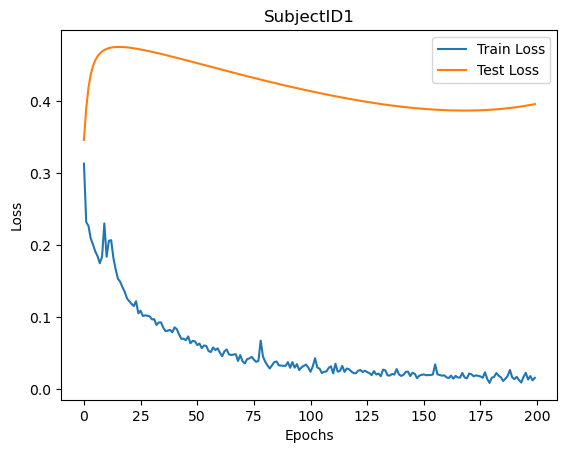

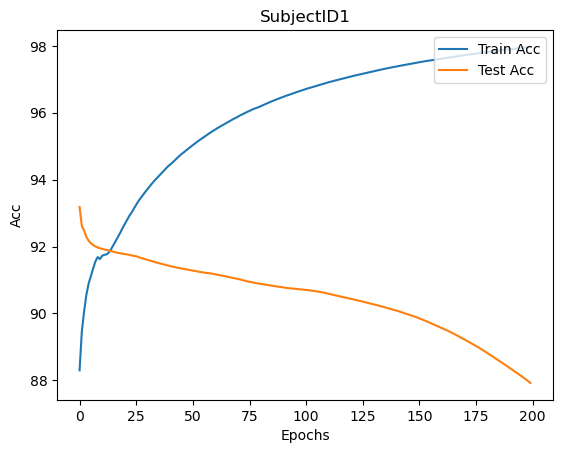

| epoch   0 | 0.0216 s/epoch | train loss 0.7074
| epoch   1 | 0.0234 s/epoch | train loss 0.6833
| epoch   2 | 0.0239 s/epoch | train loss 0.6001
| epoch   3 | 0.0220 s/epoch | train loss 0.4454
| epoch   4 | 0.0237 s/epoch | train loss 0.4103
| epoch   5 | 0.0199 s/epoch | train loss 0.4000
| epoch   6 | 0.0205 s/epoch | train loss 0.3935
| epoch   7 | 0.0210 s/epoch | train loss 0.3867
| epoch   8 | 0.0209 s/epoch | train loss 0.3814
| epoch   9 | 0.0242 s/epoch | train loss 0.3758
| epoch  10 | 0.0215 s/epoch | train loss 0.3723
| epoch  11 | 0.0218 s/epoch | train loss 0.3693
| epoch  12 | 0.0204 s/epoch | train loss 0.3657
| epoch  13 | 0.0233 s/epoch | train loss 0.3643
| epoch  14 | 0.0213 s/epoch | train loss 0.3597
| epoch  15 | 0.0234 s/epoch | train loss 0.3592
| epoch  16 | 0.0211 s/epoch | train loss 0.3573
| epoch  17 | 0.0225 s/epoch | train loss 0.3550
| epoch  18 | 0.0236 s/epoch | train loss 0.3541
| epoch  19 | 0.0230 s/epoch | train loss 0.3541
| epoch  20 | 0.0225

| epoch 168 | 0.0240 s/epoch | train loss 0.3096
| epoch 169 | 0.0219 s/epoch | train loss 0.3082
| epoch 170 | 0.0223 s/epoch | train loss 0.3064
| epoch 171 | 0.0227 s/epoch | train loss 0.3077
| epoch 172 | 0.0221 s/epoch | train loss 0.3069
| epoch 173 | 0.0181 s/epoch | train loss 0.3073
| epoch 174 | 0.0185 s/epoch | train loss 0.3064
| epoch 175 | 0.0183 s/epoch | train loss 0.3072
| epoch 176 | 0.0184 s/epoch | train loss 0.3071
| epoch 177 | 0.0180 s/epoch | train loss 0.3059
| epoch 178 | 0.0191 s/epoch | train loss 0.3069
| epoch 179 | 0.0178 s/epoch | train loss 0.3062
| epoch 180 | 0.0182 s/epoch | train loss 0.3057
| epoch 181 | 0.0180 s/epoch | train loss 0.3047
| epoch 182 | 0.0204 s/epoch | train loss 0.3044
| epoch 183 | 0.0190 s/epoch | train loss 0.3064
| epoch 184 | 0.0209 s/epoch | train loss 0.3065
| epoch 185 | 0.0225 s/epoch | train loss 0.3038
| epoch 186 | 0.0227 s/epoch | train loss 0.3053
| epoch 187 | 0.0221 s/epoch | train loss 0.3046
| epoch 188 | 0.0223

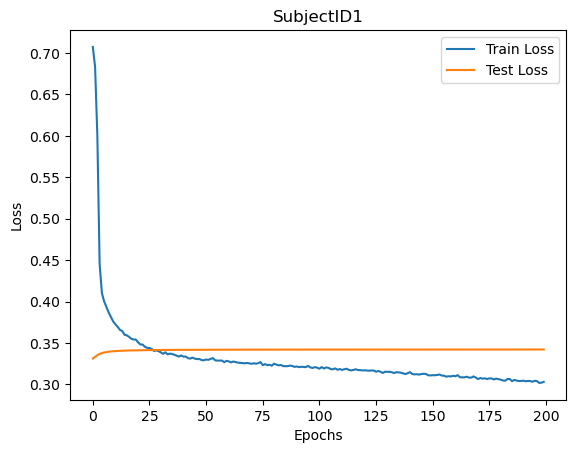

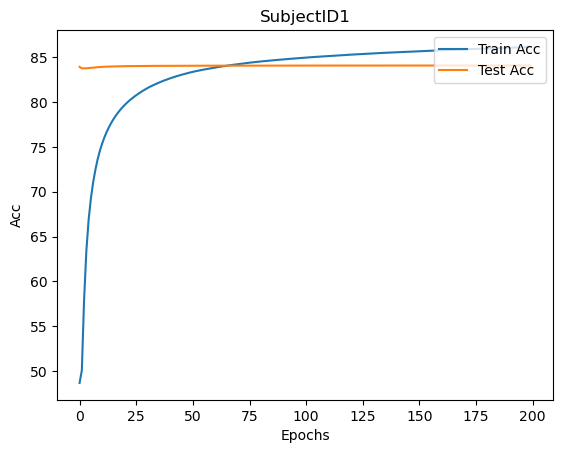


Subject 2
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2296 s/epoch | train loss 0.3131
| epoch   1 | 0.2262 s/epoch | train loss 0.2333
| epoch   2 | 0.2200 s/epoch | train loss 0.2368
| epoch   3 | 0.2096 s/epoch | train loss 0.2008
| epoch   4 | 0.2082 s/epoch | train loss 0.2056
| epoch   5 | 0.2129 s/epoch | train loss 0.1908
| epoch   6 | 0.2132 s/epoch | train loss 0.1895
| epoch   7 | 0.2111 s/epoch | train loss 0.1701
| epoch   8 | 0.2147 s/epoch | train loss 0.1682
| epoch   9 | 0.2114 s/epoch | train loss 0.1645
| epoch  10 | 0.2133 s/epoch | train loss 0.1540
| epoch  11 | 0.2151 s/epoch | train loss 0.1720
| epoch  12 | 0.2121 s/epoch | train loss 0.1439
| epoch  13 | 0.2151 s/epoch | train loss 0.1415
| epoch  14 | 0.2048 s/epoch | train loss 0.1361
| epoch  15 | 0.2036 s/epoch | train loss 0.1295
| epoch

| epoch 163 | 0.1989 s/epoch | train loss 0.0145
| epoch 164 | 0.1993 s/epoch | train loss 0.0133
| epoch 165 | 0.1994 s/epoch | train loss 0.0164
| epoch 166 | 0.2057 s/epoch | train loss 0.0143
| epoch 167 | 0.1943 s/epoch | train loss 0.0122
| epoch 168 | 0.1957 s/epoch | train loss 0.0171
| epoch 169 | 0.2036 s/epoch | train loss 0.0127
| epoch 170 | 0.1974 s/epoch | train loss 0.0152
| epoch 171 | 0.1975 s/epoch | train loss 0.0152
| epoch 172 | 0.2016 s/epoch | train loss 0.0143
| epoch 173 | 0.2025 s/epoch | train loss 0.0206
| epoch 174 | 0.1983 s/epoch | train loss 0.0184
| epoch 175 | 0.1977 s/epoch | train loss 0.0119
| epoch 176 | 0.2002 s/epoch | train loss 0.0201
| epoch 177 | 0.1981 s/epoch | train loss 0.0165
| epoch 178 | 0.2016 s/epoch | train loss 0.0147
| epoch 179 | 0.2029 s/epoch | train loss 0.0171
| epoch 180 | 0.1994 s/epoch | train loss 0.0136
| epoch 181 | 0.2034 s/epoch | train loss 0.0189
| epoch 182 | 0.2083 s/epoch | train loss 0.0231
| epoch 183 | 0.1957

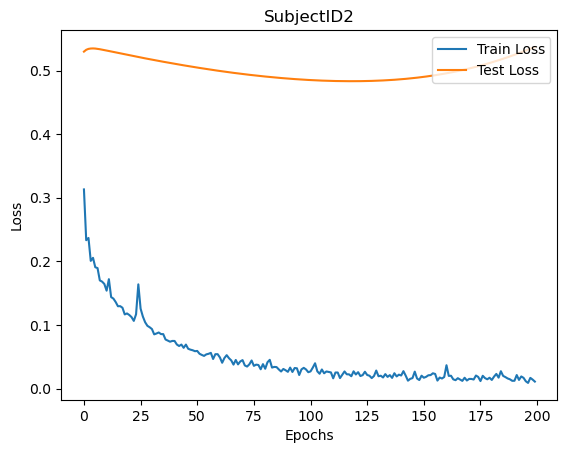

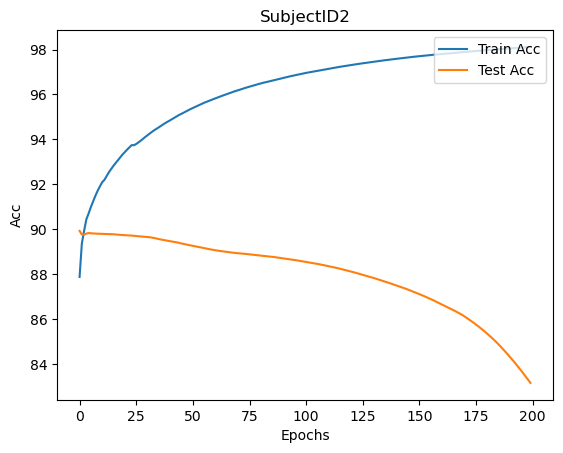

| epoch   0 | 0.0194 s/epoch | train loss 0.6993
| epoch   1 | 0.0206 s/epoch | train loss 0.6933
| epoch   2 | 0.0198 s/epoch | train loss 0.6929
| epoch   3 | 0.0204 s/epoch | train loss 0.6928
| epoch   4 | 0.0192 s/epoch | train loss 0.6929
| epoch   5 | 0.0204 s/epoch | train loss 0.6928
| epoch   6 | 0.0193 s/epoch | train loss 0.6929
| epoch   7 | 0.0192 s/epoch | train loss 0.6929
| epoch   8 | 0.0196 s/epoch | train loss 0.6928
| epoch   9 | 0.0200 s/epoch | train loss 0.6929
| epoch  10 | 0.0192 s/epoch | train loss 0.6928
| epoch  11 | 0.0188 s/epoch | train loss 0.6928
| epoch  12 | 0.0197 s/epoch | train loss 0.6928
| epoch  13 | 0.0190 s/epoch | train loss 0.6928
| epoch  14 | 0.0197 s/epoch | train loss 0.6928
| epoch  15 | 0.0203 s/epoch | train loss 0.6928
| epoch  16 | 0.0198 s/epoch | train loss 0.6928
| epoch  17 | 0.0184 s/epoch | train loss 0.6929
| epoch  18 | 0.0199 s/epoch | train loss 0.6928
| epoch  19 | 0.0203 s/epoch | train loss 0.6928
| epoch  20 | 0.0203

| epoch 168 | 0.0197 s/epoch | train loss 0.6929
| epoch 169 | 0.0193 s/epoch | train loss 0.6929
| epoch 170 | 0.0187 s/epoch | train loss 0.6929
| epoch 171 | 0.0186 s/epoch | train loss 0.6929
| epoch 172 | 0.0202 s/epoch | train loss 0.6928
| epoch 173 | 0.0184 s/epoch | train loss 0.6929
| epoch 174 | 0.0193 s/epoch | train loss 0.6929
| epoch 175 | 0.0208 s/epoch | train loss 0.6928
| epoch 176 | 0.0190 s/epoch | train loss 0.6928
| epoch 177 | 0.0188 s/epoch | train loss 0.6928
| epoch 178 | 0.0198 s/epoch | train loss 0.6929
| epoch 179 | 0.0196 s/epoch | train loss 0.6929
| epoch 180 | 0.0198 s/epoch | train loss 0.6928
| epoch 181 | 0.0194 s/epoch | train loss 0.6928
| epoch 182 | 0.0185 s/epoch | train loss 0.6928
| epoch 183 | 0.0201 s/epoch | train loss 0.6928
| epoch 184 | 0.0194 s/epoch | train loss 0.6929
| epoch 185 | 0.0208 s/epoch | train loss 0.6928
| epoch 186 | 0.0186 s/epoch | train loss 0.6928
| epoch 187 | 0.0205 s/epoch | train loss 0.6928
| epoch 188 | 0.0181

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


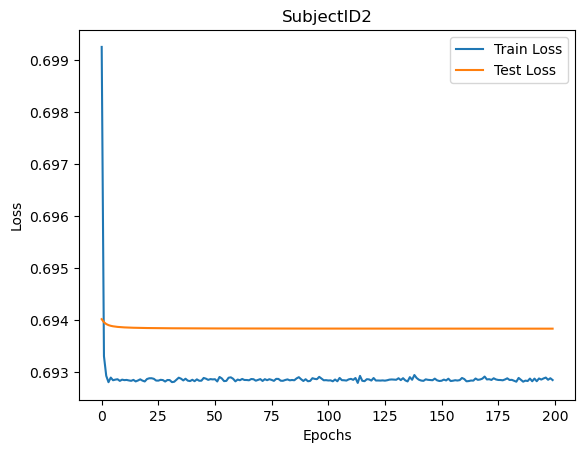

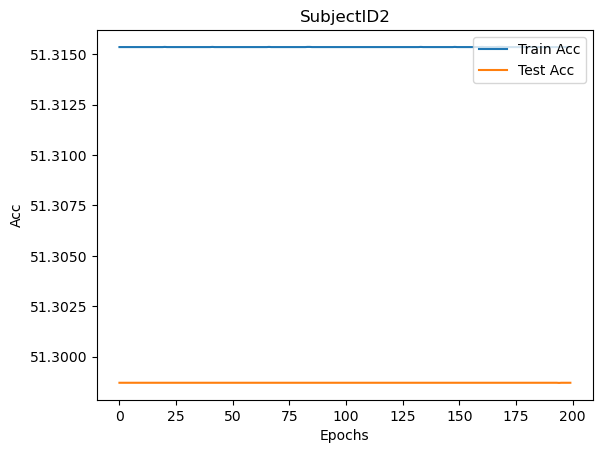


Subject 3
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2132 s/epoch | train loss 0.3079
| epoch   1 | 0.2114 s/epoch | train loss 0.2428
| epoch   2 | 0.2055 s/epoch | train loss 0.2199
| epoch   3 | 0.2084 s/epoch | train loss 0.2037
| epoch   4 | 0.2086 s/epoch | train loss 0.1993
| epoch   5 | 0.2063 s/epoch | train loss 0.1817
| epoch   6 | 0.1846 s/epoch | train loss 0.1711
| epoch   7 | 0.1904 s/epoch | train loss 0.1738
| epoch   8 | 0.1852 s/epoch | train loss 0.1622
| epoch   9 | 0.1997 s/epoch | train loss 0.1532
| epoch  10 | 0.1924 s/epoch | train loss 0.1458
| epoch  11 | 0.1746 s/epoch | train loss 0.1427
| epoch  12 | 0.1777 s/epoch | train loss 0.1380
| epoch  13 | 0.1722 s/epoch | train loss 0.1628
| epoch  14 | 0.1677 s/epoch | train loss 0.1946
| epoch  15 | 0.1679 s/epoch | train loss 0.1617
| epoch

| epoch 163 | 0.1709 s/epoch | train loss 0.0219
| epoch 164 | 0.1688 s/epoch | train loss 0.0152
| epoch 165 | 0.1688 s/epoch | train loss 0.0167
| epoch 166 | 0.1713 s/epoch | train loss 0.0182
| epoch 167 | 0.1702 s/epoch | train loss 0.0162
| epoch 168 | 0.1685 s/epoch | train loss 0.0311
| epoch 169 | 0.1692 s/epoch | train loss 0.0174
| epoch 170 | 0.1685 s/epoch | train loss 0.0153
| epoch 171 | 0.1686 s/epoch | train loss 0.0133
| epoch 172 | 0.1717 s/epoch | train loss 0.0133
| epoch 173 | 0.1691 s/epoch | train loss 0.0140
| epoch 174 | 0.1689 s/epoch | train loss 0.0128
| epoch 175 | 0.1696 s/epoch | train loss 0.0210
| epoch 176 | 0.1707 s/epoch | train loss 0.0138
| epoch 177 | 0.1690 s/epoch | train loss 0.0141
| epoch 178 | 0.1683 s/epoch | train loss 0.0188
| epoch 179 | 0.1723 s/epoch | train loss 0.0144
| epoch 180 | 0.1702 s/epoch | train loss 0.0155
| epoch 181 | 0.1678 s/epoch | train loss 0.0124
| epoch 182 | 0.1708 s/epoch | train loss 0.0131
| epoch 183 | 0.1692

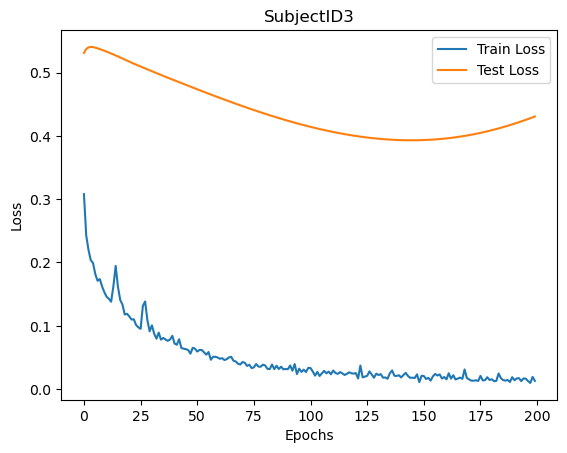

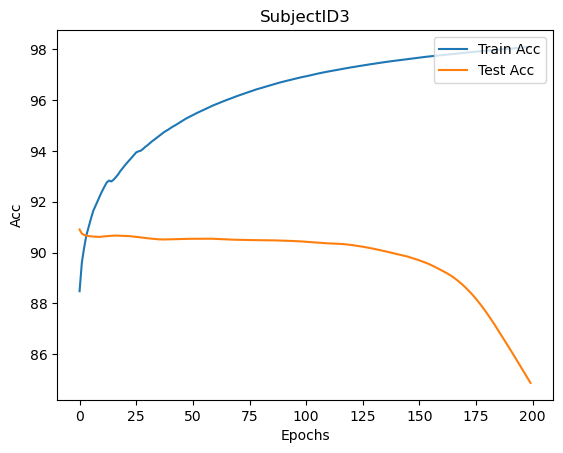

| epoch   0 | 0.0144 s/epoch | train loss 0.7003
| epoch   1 | 0.0152 s/epoch | train loss 0.6932
| epoch   2 | 0.0157 s/epoch | train loss 0.6929
| epoch   3 | 0.0148 s/epoch | train loss 0.6929
| epoch   4 | 0.0156 s/epoch | train loss 0.6928
| epoch   5 | 0.0145 s/epoch | train loss 0.6929
| epoch   6 | 0.0154 s/epoch | train loss 0.6928
| epoch   7 | 0.0157 s/epoch | train loss 0.6929
| epoch   8 | 0.0162 s/epoch | train loss 0.6928
| epoch   9 | 0.0149 s/epoch | train loss 0.6929
| epoch  10 | 0.0149 s/epoch | train loss 0.6929
| epoch  11 | 0.0160 s/epoch | train loss 0.6928
| epoch  12 | 0.0151 s/epoch | train loss 0.6928
| epoch  13 | 0.0156 s/epoch | train loss 0.6928
| epoch  14 | 0.0152 s/epoch | train loss 0.6929
| epoch  15 | 0.0149 s/epoch | train loss 0.6929
| epoch  16 | 0.0154 s/epoch | train loss 0.6929
| epoch  17 | 0.0150 s/epoch | train loss 0.6928
| epoch  18 | 0.0157 s/epoch | train loss 0.6929
| epoch  19 | 0.0145 s/epoch | train loss 0.6929
| epoch  20 | 0.0148

| epoch 168 | 0.0154 s/epoch | train loss 0.6929
| epoch 169 | 0.0147 s/epoch | train loss 0.6928
| epoch 170 | 0.0149 s/epoch | train loss 0.6928
| epoch 171 | 0.0147 s/epoch | train loss 0.6928
| epoch 172 | 0.0159 s/epoch | train loss 0.6929
| epoch 173 | 0.0155 s/epoch | train loss 0.6929
| epoch 174 | 0.0151 s/epoch | train loss 0.6929
| epoch 175 | 0.0145 s/epoch | train loss 0.6929
| epoch 176 | 0.0150 s/epoch | train loss 0.6928
| epoch 177 | 0.0152 s/epoch | train loss 0.6929
| epoch 178 | 0.0145 s/epoch | train loss 0.6929
| epoch 179 | 0.0146 s/epoch | train loss 0.6928
| epoch 180 | 0.0146 s/epoch | train loss 0.6928
| epoch 181 | 0.0154 s/epoch | train loss 0.6929
| epoch 182 | 0.0149 s/epoch | train loss 0.6929
| epoch 183 | 0.0159 s/epoch | train loss 0.6929
| epoch 184 | 0.0153 s/epoch | train loss 0.6928
| epoch 185 | 0.0147 s/epoch | train loss 0.6929
| epoch 186 | 0.0150 s/epoch | train loss 0.6929
| epoch 187 | 0.0147 s/epoch | train loss 0.6928
| epoch 188 | 0.0153

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


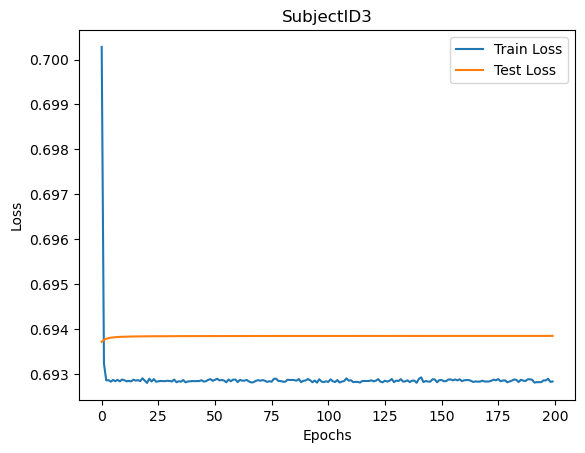

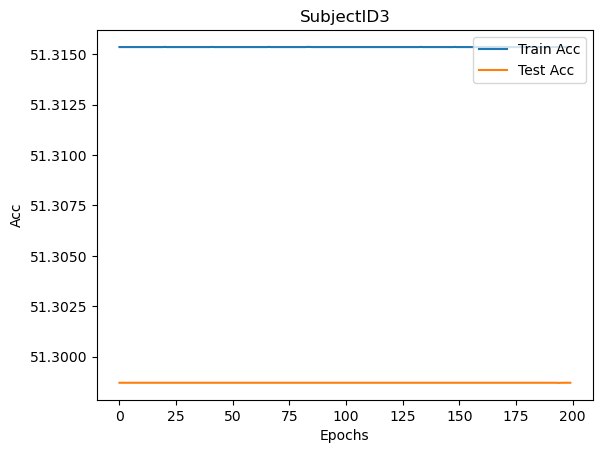


Subject 4
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1703 s/epoch | train loss 0.3368
| epoch   1 | 0.1702 s/epoch | train loss 0.2481
| epoch   2 | 0.1679 s/epoch | train loss 0.2255
| epoch   3 | 0.1662 s/epoch | train loss 0.2220
| epoch   4 | 0.1689 s/epoch | train loss 0.2039
| epoch   5 | 0.1691 s/epoch | train loss 0.1885
| epoch   6 | 0.1692 s/epoch | train loss 0.1835
| epoch   7 | 0.1697 s/epoch | train loss 0.1754
| epoch   8 | 0.1684 s/epoch | train loss 0.1668
| epoch   9 | 0.1690 s/epoch | train loss 0.1548
| epoch  10 | 0.1685 s/epoch | train loss 0.1933
| epoch  11 | 0.1678 s/epoch | train loss 0.2676
| epoch  12 | 0.1712 s/epoch | train loss 0.2285
| epoch  13 | 0.1709 s/epoch | train loss 0.2046
| epoch  14 | 0.1689 s/epoch | train loss 0.1875
| epoch  15 | 0.1691 s/epoch | train loss 0.1646
| epoch

| epoch 163 | 0.1656 s/epoch | train loss 0.0122
| epoch 164 | 0.1656 s/epoch | train loss 0.0114
| epoch 165 | 0.1684 s/epoch | train loss 0.0120
| epoch 166 | 0.1724 s/epoch | train loss 0.0244
| epoch 167 | 0.1685 s/epoch | train loss 0.0188
| epoch 168 | 0.1689 s/epoch | train loss 0.0143
| epoch 169 | 0.1700 s/epoch | train loss 0.0203
| epoch 170 | 0.1704 s/epoch | train loss 0.0191
| epoch 171 | 0.1700 s/epoch | train loss 0.0141
| epoch 172 | 0.1698 s/epoch | train loss 0.0128
| epoch 173 | 0.1663 s/epoch | train loss 0.0196
| epoch 174 | 0.1680 s/epoch | train loss 0.0186
| epoch 175 | 0.1697 s/epoch | train loss 0.0185
| epoch 176 | 0.1684 s/epoch | train loss 0.0156
| epoch 177 | 0.1668 s/epoch | train loss 0.0193
| epoch 178 | 0.1701 s/epoch | train loss 0.0155
| epoch 179 | 0.1669 s/epoch | train loss 0.0182
| epoch 180 | 0.1668 s/epoch | train loss 0.0197
| epoch 181 | 0.1670 s/epoch | train loss 0.0128
| epoch 182 | 0.1666 s/epoch | train loss 0.0101
| epoch 183 | 0.1659

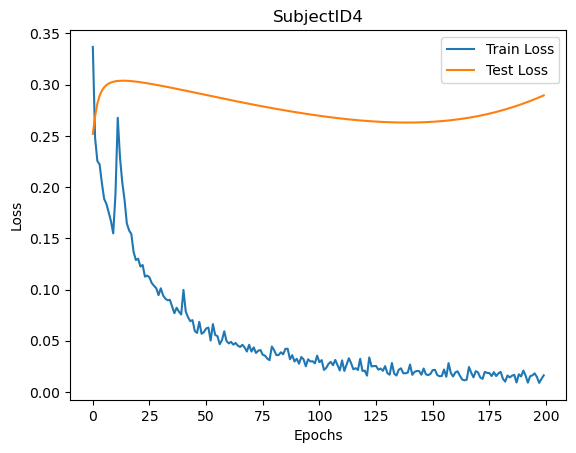

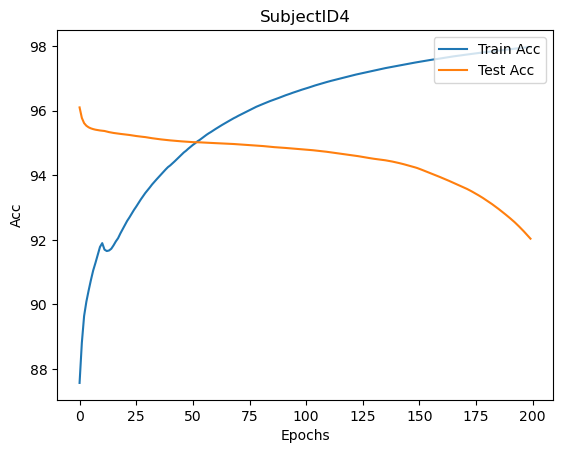

| epoch   0 | 0.0147 s/epoch | train loss 0.6991
| epoch   1 | 0.0145 s/epoch | train loss 0.6798
| epoch   2 | 0.0154 s/epoch | train loss 0.6349
| epoch   3 | 0.0159 s/epoch | train loss 0.5746
| epoch   4 | 0.0157 s/epoch | train loss 0.5214
| epoch   5 | 0.0155 s/epoch | train loss 0.4893
| epoch   6 | 0.0141 s/epoch | train loss 0.4709
| epoch   7 | 0.0147 s/epoch | train loss 0.4590
| epoch   8 | 0.0143 s/epoch | train loss 0.4496
| epoch   9 | 0.0161 s/epoch | train loss 0.4423
| epoch  10 | 0.0152 s/epoch | train loss 0.4367
| epoch  11 | 0.0150 s/epoch | train loss 0.4315
| epoch  12 | 0.0138 s/epoch | train loss 0.4260
| epoch  13 | 0.0136 s/epoch | train loss 0.4217
| epoch  14 | 0.0141 s/epoch | train loss 0.4167
| epoch  15 | 0.0145 s/epoch | train loss 0.4142
| epoch  16 | 0.0150 s/epoch | train loss 0.4100
| epoch  17 | 0.0143 s/epoch | train loss 0.4070
| epoch  18 | 0.0165 s/epoch | train loss 0.4058
| epoch  19 | 0.0145 s/epoch | train loss 0.4020
| epoch  20 | 0.0165

| epoch 168 | 0.0146 s/epoch | train loss 0.3062
| epoch 169 | 0.0148 s/epoch | train loss 0.3036
| epoch 170 | 0.0148 s/epoch | train loss 0.3054
| epoch 171 | 0.0145 s/epoch | train loss 0.3050
| epoch 172 | 0.0146 s/epoch | train loss 0.3039
| epoch 173 | 0.0143 s/epoch | train loss 0.3051
| epoch 174 | 0.0140 s/epoch | train loss 0.3072
| epoch 175 | 0.0139 s/epoch | train loss 0.3037
| epoch 176 | 0.0150 s/epoch | train loss 0.3037
| epoch 177 | 0.0150 s/epoch | train loss 0.3031
| epoch 178 | 0.0145 s/epoch | train loss 0.3039
| epoch 179 | 0.0146 s/epoch | train loss 0.3034
| epoch 180 | 0.0149 s/epoch | train loss 0.3026
| epoch 181 | 0.0158 s/epoch | train loss 0.3036
| epoch 182 | 0.0145 s/epoch | train loss 0.3028
| epoch 183 | 0.0148 s/epoch | train loss 0.3037
| epoch 184 | 0.0164 s/epoch | train loss 0.3039
| epoch 185 | 0.0146 s/epoch | train loss 0.3039
| epoch 186 | 0.0142 s/epoch | train loss 0.3036
| epoch 187 | 0.0149 s/epoch | train loss 0.3025
| epoch 188 | 0.0145

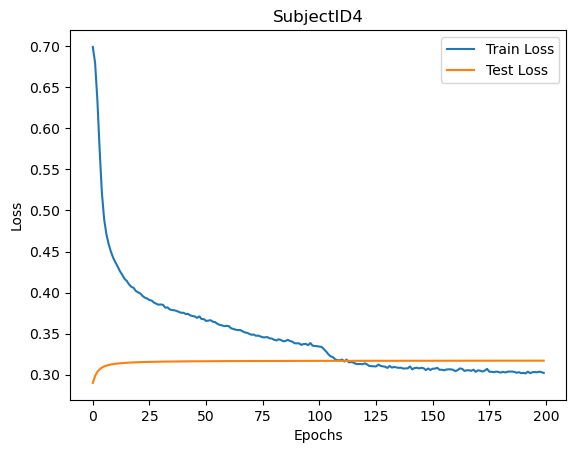

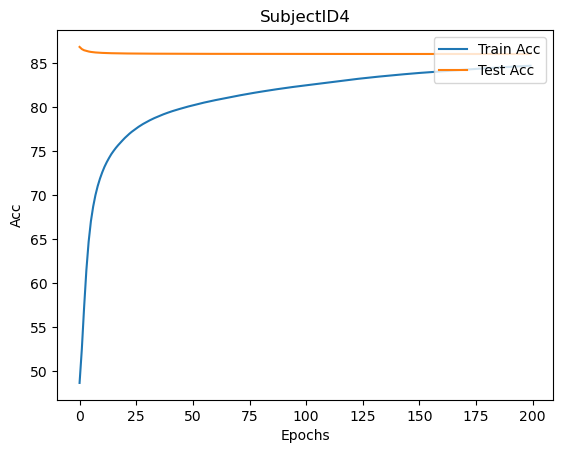


Subject 5
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1677 s/epoch | train loss 0.3649
| epoch   1 | 0.1691 s/epoch | train loss 0.2629
| epoch   2 | 0.1690 s/epoch | train loss 0.2403
| epoch   3 | 0.1670 s/epoch | train loss 0.2306
| epoch   4 | 0.1686 s/epoch | train loss 0.2122
| epoch   5 | 0.1680 s/epoch | train loss 0.2087
| epoch   6 | 0.1685 s/epoch | train loss 0.1861
| epoch   7 | 0.1675 s/epoch | train loss 0.1978
| epoch   8 | 0.1660 s/epoch | train loss 0.1707
| epoch   9 | 0.1665 s/epoch | train loss 0.1809
| epoch  10 | 0.1707 s/epoch | train loss 0.1608
| epoch  11 | 0.1678 s/epoch | train loss 0.1553
| epoch  12 | 0.1678 s/epoch | train loss 0.1487
| epoch  13 | 0.1679 s/epoch | train loss 0.1442
| epoch  14 | 0.1656 s/epoch | train loss 0.1341
| epoch  15 | 0.1662 s/epoch | train loss 0.1280
| epoch

| epoch 163 | 0.1707 s/epoch | train loss 0.0163
| epoch 164 | 0.1696 s/epoch | train loss 0.0208
| epoch 165 | 0.1672 s/epoch | train loss 0.0201
| epoch 166 | 0.1701 s/epoch | train loss 0.0151
| epoch 167 | 0.1703 s/epoch | train loss 0.0140
| epoch 168 | 0.1714 s/epoch | train loss 0.0189
| epoch 169 | 0.1704 s/epoch | train loss 0.0155
| epoch 170 | 0.1704 s/epoch | train loss 0.0186
| epoch 171 | 0.1694 s/epoch | train loss 0.0192
| epoch 172 | 0.1706 s/epoch | train loss 0.0230
| epoch 173 | 0.1696 s/epoch | train loss 0.0152
| epoch 174 | 0.1695 s/epoch | train loss 0.0156
| epoch 175 | 0.1705 s/epoch | train loss 0.0168
| epoch 176 | 0.1695 s/epoch | train loss 0.0169
| epoch 177 | 0.1677 s/epoch | train loss 0.0191
| epoch 178 | 0.1697 s/epoch | train loss 0.0149
| epoch 179 | 0.1648 s/epoch | train loss 0.0151
| epoch 180 | 0.1652 s/epoch | train loss 0.0181
| epoch 181 | 0.1624 s/epoch | train loss 0.0163
| epoch 182 | 0.1647 s/epoch | train loss 0.0162
| epoch 183 | 0.1649

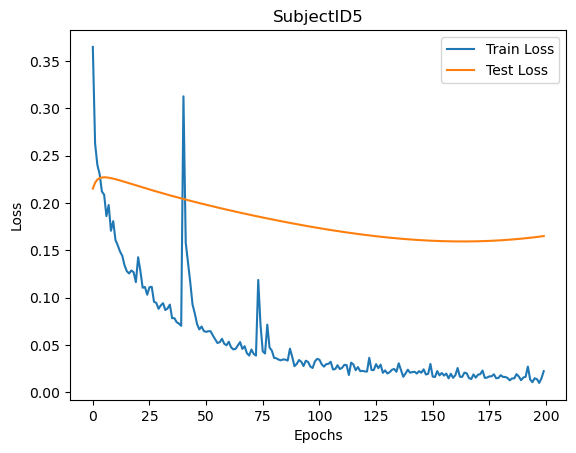

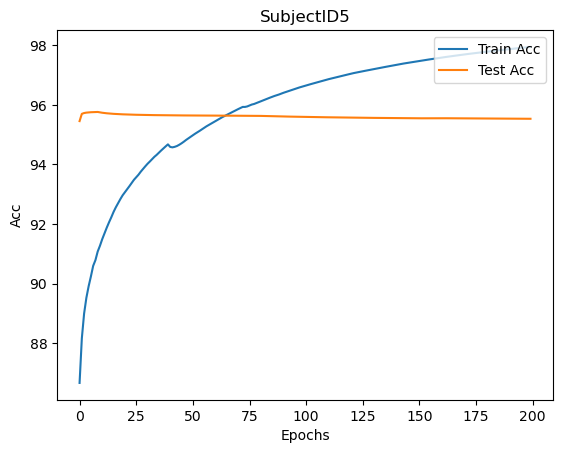

| epoch   0 | 0.0174 s/epoch | train loss 0.6931
| epoch   1 | 0.0160 s/epoch | train loss 0.6929
| epoch   2 | 0.0168 s/epoch | train loss 0.6928
| epoch   3 | 0.0170 s/epoch | train loss 0.6928
| epoch   4 | 0.0158 s/epoch | train loss 0.6929
| epoch   5 | 0.0162 s/epoch | train loss 0.6929
| epoch   6 | 0.0163 s/epoch | train loss 0.6929
| epoch   7 | 0.0159 s/epoch | train loss 0.6928
| epoch   8 | 0.0155 s/epoch | train loss 0.6929
| epoch   9 | 0.0162 s/epoch | train loss 0.6928
| epoch  10 | 0.0164 s/epoch | train loss 0.6929
| epoch  11 | 0.0153 s/epoch | train loss 0.6928
| epoch  12 | 0.0173 s/epoch | train loss 0.6929
| epoch  13 | 0.0162 s/epoch | train loss 0.6928
| epoch  14 | 0.0171 s/epoch | train loss 0.6929
| epoch  15 | 0.0163 s/epoch | train loss 0.6928
| epoch  16 | 0.0169 s/epoch | train loss 0.6929
| epoch  17 | 0.0158 s/epoch | train loss 0.6928
| epoch  18 | 0.0158 s/epoch | train loss 0.6929
| epoch  19 | 0.0154 s/epoch | train loss 0.6929
| epoch  20 | 0.0159

| epoch 168 | 0.0161 s/epoch | train loss 0.6929
| epoch 169 | 0.0161 s/epoch | train loss 0.6928
| epoch 170 | 0.0162 s/epoch | train loss 0.6928
| epoch 171 | 0.0165 s/epoch | train loss 0.6929
| epoch 172 | 0.0171 s/epoch | train loss 0.6929
| epoch 173 | 0.0167 s/epoch | train loss 0.6928
| epoch 174 | 0.0163 s/epoch | train loss 0.6929
| epoch 175 | 0.0171 s/epoch | train loss 0.6929
| epoch 176 | 0.0162 s/epoch | train loss 0.6928
| epoch 177 | 0.0171 s/epoch | train loss 0.6928
| epoch 178 | 0.0153 s/epoch | train loss 0.6928
| epoch 179 | 0.0163 s/epoch | train loss 0.6928
| epoch 180 | 0.0163 s/epoch | train loss 0.6928
| epoch 181 | 0.0165 s/epoch | train loss 0.6928
| epoch 182 | 0.0164 s/epoch | train loss 0.6929
| epoch 183 | 0.0166 s/epoch | train loss 0.6928
| epoch 184 | 0.0160 s/epoch | train loss 0.6928
| epoch 185 | 0.0170 s/epoch | train loss 0.6928
| epoch 186 | 0.0163 s/epoch | train loss 0.6928
| epoch 187 | 0.0161 s/epoch | train loss 0.6929
| epoch 188 | 0.0158

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


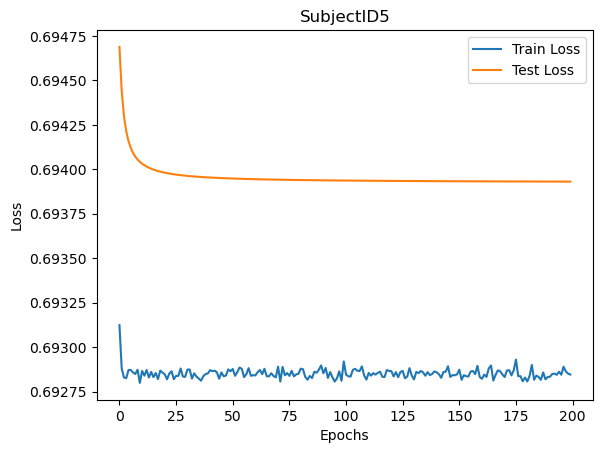

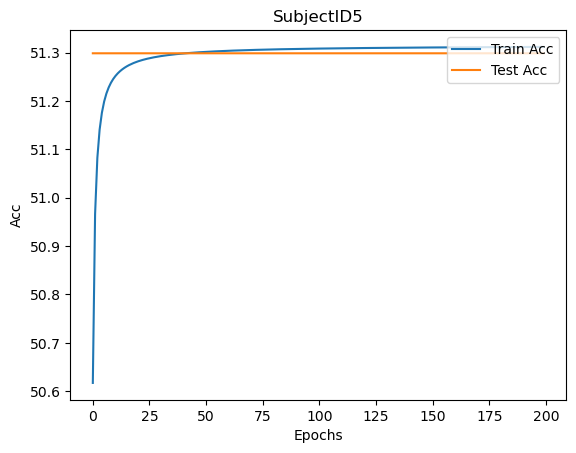


Subject 7
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1768 s/epoch | train loss 0.3522
| epoch   1 | 0.1750 s/epoch | train loss 0.2566
| epoch   2 | 0.1755 s/epoch | train loss 0.2536
| epoch   3 | 0.1741 s/epoch | train loss 0.2173
| epoch   4 | 0.1751 s/epoch | train loss 0.2018
| epoch   5 | 0.1765 s/epoch | train loss 0.2016
| epoch   6 | 0.1755 s/epoch | train loss 0.1881
| epoch   7 | 0.1780 s/epoch | train loss 0.1892
| epoch   8 | 0.1762 s/epoch | train loss 0.1783
| epoch   9 | 0.1784 s/epoch | train loss 0.1770
| epoch  10 | 0.1792 s/epoch | train loss 0.1707
| epoch  11 | 0.1760 s/epoch | train loss 0.1648
| epoch  12 | 0.1767 s/epoch | train loss 0.1597
| epoch  13 | 0.1793 s/epoch | train loss 0.1493
| epoch  14 | 0.1780 s/epoch | train loss 0.1437
| epoch  15 | 0.1785 s/epoch | train loss 0.1527
| epoch

| epoch 163 | 0.2348 s/epoch | train loss 0.0241
| epoch 164 | 0.2348 s/epoch | train loss 0.0261
| epoch 165 | 0.2410 s/epoch | train loss 0.0167
| epoch 166 | 0.2448 s/epoch | train loss 0.0172
| epoch 167 | 0.2427 s/epoch | train loss 0.0171
| epoch 168 | 0.2402 s/epoch | train loss 0.0177
| epoch 169 | 0.2397 s/epoch | train loss 0.0153
| epoch 170 | 0.2440 s/epoch | train loss 0.0148
| epoch 171 | 0.2346 s/epoch | train loss 0.0221
| epoch 172 | 0.2420 s/epoch | train loss 0.0190
| epoch 173 | 0.2366 s/epoch | train loss 0.0156
| epoch 174 | 0.2400 s/epoch | train loss 0.0201
| epoch 175 | 0.2284 s/epoch | train loss 0.0185
| epoch 176 | 0.2405 s/epoch | train loss 0.0174
| epoch 177 | 0.2316 s/epoch | train loss 0.0170
| epoch 178 | 0.2315 s/epoch | train loss 0.0174
| epoch 179 | 0.2306 s/epoch | train loss 0.0169
| epoch 180 | 0.2366 s/epoch | train loss 0.0145
| epoch 181 | 0.2361 s/epoch | train loss 0.0186
| epoch 182 | 0.2385 s/epoch | train loss 0.0196
| epoch 183 | 0.2396

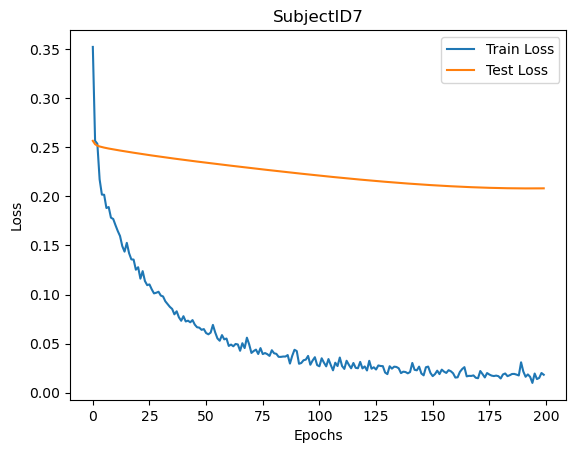

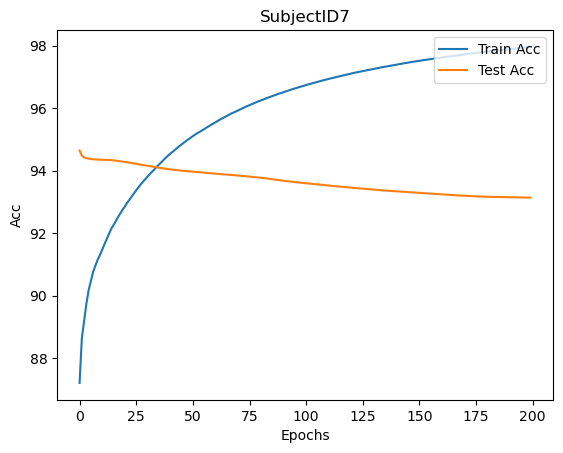

| epoch   0 | 0.0163 s/epoch | train loss 0.6934
| epoch   1 | 0.0185 s/epoch | train loss 0.6929
| epoch   2 | 0.0161 s/epoch | train loss 0.6928
| epoch   3 | 0.0167 s/epoch | train loss 0.6929
| epoch   4 | 0.0155 s/epoch | train loss 0.6928
| epoch   5 | 0.0160 s/epoch | train loss 0.6928
| epoch   6 | 0.0149 s/epoch | train loss 0.6929
| epoch   7 | 0.0175 s/epoch | train loss 0.6929
| epoch   8 | 0.0164 s/epoch | train loss 0.6929
| epoch   9 | 0.0167 s/epoch | train loss 0.6929
| epoch  10 | 0.0177 s/epoch | train loss 0.6928
| epoch  11 | 0.0163 s/epoch | train loss 0.6928
| epoch  12 | 0.0164 s/epoch | train loss 0.6928
| epoch  13 | 0.0161 s/epoch | train loss 0.6929
| epoch  14 | 0.0155 s/epoch | train loss 0.6928
| epoch  15 | 0.0162 s/epoch | train loss 0.6929
| epoch  16 | 0.0156 s/epoch | train loss 0.6928
| epoch  17 | 0.0161 s/epoch | train loss 0.6929
| epoch  18 | 0.0163 s/epoch | train loss 0.6929
| epoch  19 | 0.0166 s/epoch | train loss 0.6928
| epoch  20 | 0.0164

| epoch 168 | 0.0177 s/epoch | train loss 0.6929
| epoch 169 | 0.0168 s/epoch | train loss 0.6928
| epoch 170 | 0.0169 s/epoch | train loss 0.6928
| epoch 171 | 0.0163 s/epoch | train loss 0.6928
| epoch 172 | 0.0177 s/epoch | train loss 0.6928
| epoch 173 | 0.0163 s/epoch | train loss 0.6928
| epoch 174 | 0.0162 s/epoch | train loss 0.6928
| epoch 175 | 0.0170 s/epoch | train loss 0.6928
| epoch 176 | 0.0160 s/epoch | train loss 0.6928
| epoch 177 | 0.0162 s/epoch | train loss 0.6928
| epoch 178 | 0.0166 s/epoch | train loss 0.6928
| epoch 179 | 0.0161 s/epoch | train loss 0.6929
| epoch 180 | 0.0170 s/epoch | train loss 0.6928
| epoch 181 | 0.0175 s/epoch | train loss 0.6929
| epoch 182 | 0.0166 s/epoch | train loss 0.6928
| epoch 183 | 0.0157 s/epoch | train loss 0.6929
| epoch 184 | 0.0177 s/epoch | train loss 0.6929
| epoch 185 | 0.0171 s/epoch | train loss 0.6928
| epoch 186 | 0.0181 s/epoch | train loss 0.6929
| epoch 187 | 0.0168 s/epoch | train loss 0.6929
| epoch 188 | 0.0177

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


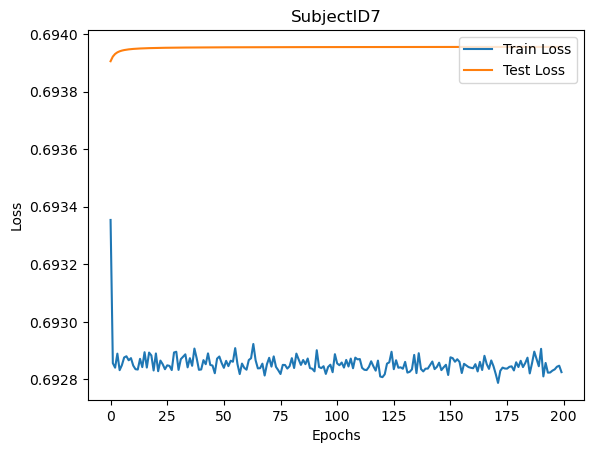

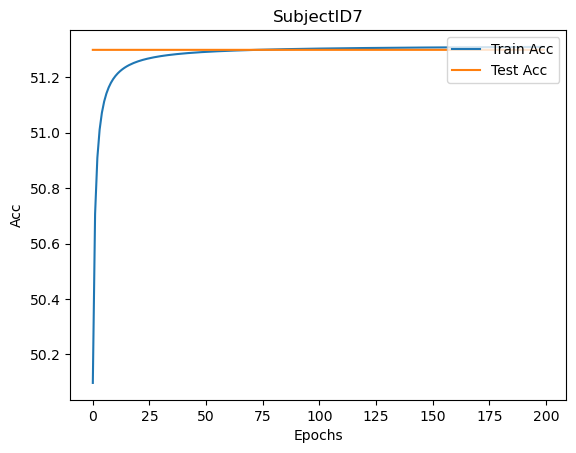


Subject 8
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1772 s/epoch | train loss 0.3173
| epoch   1 | 0.2001 s/epoch | train loss 0.2465
| epoch   2 | 0.2006 s/epoch | train loss 0.2286
| epoch   3 | 0.1969 s/epoch | train loss 0.2122
| epoch   4 | 0.1943 s/epoch | train loss 0.2094
| epoch   5 | 0.1981 s/epoch | train loss 0.1906
| epoch   6 | 0.1967 s/epoch | train loss 0.1865
| epoch   7 | 0.2001 s/epoch | train loss 0.1723
| epoch   8 | 0.2020 s/epoch | train loss 0.1752
| epoch   9 | 0.1989 s/epoch | train loss 0.1674
| epoch  10 | 0.2025 s/epoch | train loss 0.1598
| epoch  11 | 0.2048 s/epoch | train loss 0.1624
| epoch  12 | 0.2049 s/epoch | train loss 0.1515
| epoch  13 | 0.2025 s/epoch | train loss 0.1455
| epoch  14 | 0.2045 s/epoch | train loss 0.1422
| epoch  15 | 0.2044 s/epoch | train loss 0.1456
| epoch

| epoch 163 | 0.1739 s/epoch | train loss 0.0245
| epoch 164 | 0.1759 s/epoch | train loss 0.0197
| epoch 165 | 0.1756 s/epoch | train loss 0.0196
| epoch 166 | 0.1765 s/epoch | train loss 0.0218
| epoch 167 | 0.1781 s/epoch | train loss 0.0194
| epoch 168 | 0.1797 s/epoch | train loss 0.0176
| epoch 169 | 0.1731 s/epoch | train loss 0.0145
| epoch 170 | 0.1755 s/epoch | train loss 0.0176
| epoch 171 | 0.1750 s/epoch | train loss 0.0159
| epoch 172 | 0.1726 s/epoch | train loss 0.0206
| epoch 173 | 0.1741 s/epoch | train loss 0.0158
| epoch 174 | 0.1765 s/epoch | train loss 0.0185
| epoch 175 | 0.1726 s/epoch | train loss 0.0196
| epoch 176 | 0.1758 s/epoch | train loss 0.0186
| epoch 177 | 0.1760 s/epoch | train loss 0.0184
| epoch 178 | 0.1741 s/epoch | train loss 0.0180
| epoch 179 | 0.1743 s/epoch | train loss 0.0170
| epoch 180 | 0.1725 s/epoch | train loss 0.0161
| epoch 181 | 0.1732 s/epoch | train loss 0.0191
| epoch 182 | 0.1728 s/epoch | train loss 0.0129
| epoch 183 | 0.1759

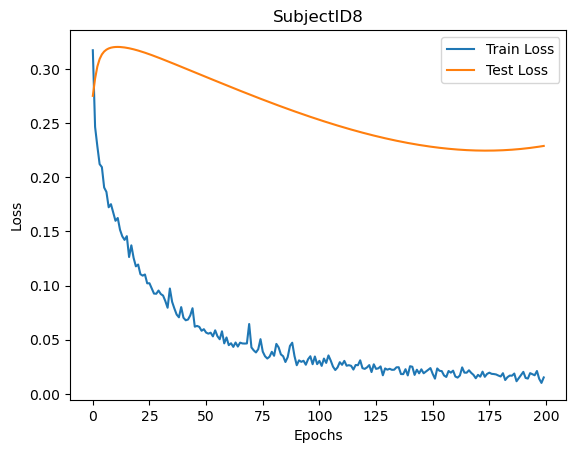

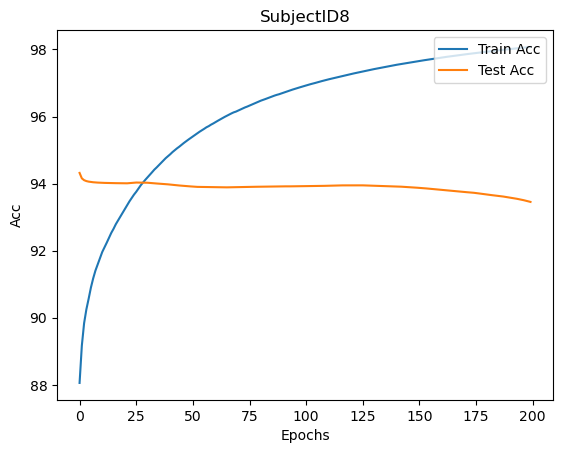

| epoch   0 | 0.0187 s/epoch | train loss 0.7045
| epoch   1 | 0.0192 s/epoch | train loss 0.6931
| epoch   2 | 0.0191 s/epoch | train loss 0.6929
| epoch   3 | 0.0200 s/epoch | train loss 0.6929
| epoch   4 | 0.0186 s/epoch | train loss 0.6928
| epoch   5 | 0.0184 s/epoch | train loss 0.6929
| epoch   6 | 0.0187 s/epoch | train loss 0.6928
| epoch   7 | 0.0192 s/epoch | train loss 0.6928
| epoch   8 | 0.0188 s/epoch | train loss 0.6929
| epoch   9 | 0.0198 s/epoch | train loss 0.6929
| epoch  10 | 0.0193 s/epoch | train loss 0.6928
| epoch  11 | 0.0190 s/epoch | train loss 0.6928
| epoch  12 | 0.0195 s/epoch | train loss 0.6928
| epoch  13 | 0.0179 s/epoch | train loss 0.6928
| epoch  14 | 0.0186 s/epoch | train loss 0.6928
| epoch  15 | 0.0184 s/epoch | train loss 0.6928
| epoch  16 | 0.0181 s/epoch | train loss 0.6929
| epoch  17 | 0.0180 s/epoch | train loss 0.6929
| epoch  18 | 0.0189 s/epoch | train loss 0.6929
| epoch  19 | 0.0186 s/epoch | train loss 0.6929
| epoch  20 | 0.0178

| epoch 168 | 0.0142 s/epoch | train loss 0.6929
| epoch 169 | 0.0146 s/epoch | train loss 0.6929
| epoch 170 | 0.0137 s/epoch | train loss 0.6928
| epoch 171 | 0.0148 s/epoch | train loss 0.6928
| epoch 172 | 0.0139 s/epoch | train loss 0.6929
| epoch 173 | 0.0146 s/epoch | train loss 0.6929
| epoch 174 | 0.0151 s/epoch | train loss 0.6929
| epoch 175 | 0.0147 s/epoch | train loss 0.6928
| epoch 176 | 0.0149 s/epoch | train loss 0.6928
| epoch 177 | 0.0145 s/epoch | train loss 0.6929
| epoch 178 | 0.0160 s/epoch | train loss 0.6928
| epoch 179 | 0.0145 s/epoch | train loss 0.6929
| epoch 180 | 0.0151 s/epoch | train loss 0.6928
| epoch 181 | 0.0155 s/epoch | train loss 0.6928
| epoch 182 | 0.0154 s/epoch | train loss 0.6928
| epoch 183 | 0.0155 s/epoch | train loss 0.6929
| epoch 184 | 0.0145 s/epoch | train loss 0.6929
| epoch 185 | 0.0151 s/epoch | train loss 0.6929
| epoch 186 | 0.0151 s/epoch | train loss 0.6928
| epoch 187 | 0.0154 s/epoch | train loss 0.6929
| epoch 188 | 0.0151

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


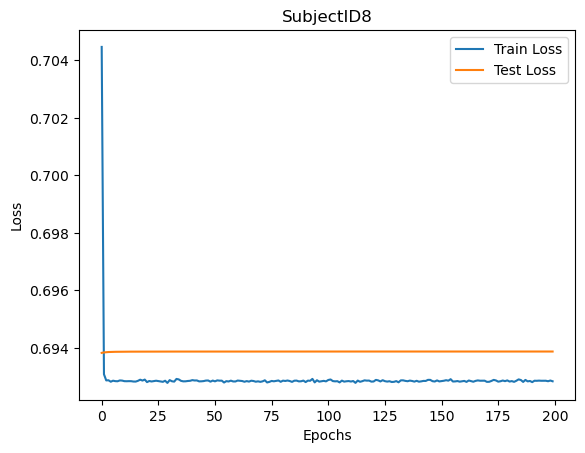

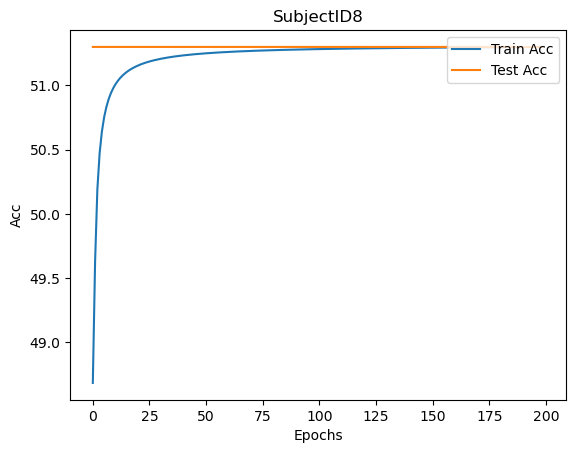


Subject 9
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1635 s/epoch | train loss 0.3352
| epoch   1 | 0.1632 s/epoch | train loss 0.2366
| epoch   2 | 0.1641 s/epoch | train loss 0.2154
| epoch   3 | 0.1639 s/epoch | train loss 0.2117
| epoch   4 | 0.1634 s/epoch | train loss 0.2018
| epoch   5 | 0.1629 s/epoch | train loss 0.1963
| epoch   6 | 0.1613 s/epoch | train loss 0.1875
| epoch   7 | 0.1637 s/epoch | train loss 0.1737
| epoch   8 | 0.1620 s/epoch | train loss 0.1670
| epoch   9 | 0.1665 s/epoch | train loss 0.1589
| epoch  10 | 0.1657 s/epoch | train loss 0.1540
| epoch  11 | 0.1700 s/epoch | train loss 0.1485
| epoch  12 | 0.1685 s/epoch | train loss 0.1467
| epoch  13 | 0.1689 s/epoch | train loss 0.1383
| epoch  14 | 0.1710 s/epoch | train loss 0.1377
| epoch  15 | 0.1690 s/epoch | train loss 0.1394
| epoch

| epoch 163 | 0.1675 s/epoch | train loss 0.0200
| epoch 164 | 0.1711 s/epoch | train loss 0.0135
| epoch 165 | 0.1710 s/epoch | train loss 0.0197
| epoch 166 | 0.1676 s/epoch | train loss 0.0169
| epoch 167 | 0.1701 s/epoch | train loss 0.0147
| epoch 168 | 0.1732 s/epoch | train loss 0.0120
| epoch 169 | 0.1695 s/epoch | train loss 0.0185
| epoch 170 | 0.1708 s/epoch | train loss 0.0272
| epoch 171 | 0.1717 s/epoch | train loss 0.0206
| epoch 172 | 0.1690 s/epoch | train loss 0.0167
| epoch 173 | 0.1699 s/epoch | train loss 0.0113
| epoch 174 | 0.1689 s/epoch | train loss 0.0164
| epoch 175 | 0.1686 s/epoch | train loss 0.0154
| epoch 176 | 0.1704 s/epoch | train loss 0.0148
| epoch 177 | 0.1686 s/epoch | train loss 0.0179
| epoch 178 | 0.1685 s/epoch | train loss 0.0177
| epoch 179 | 0.1709 s/epoch | train loss 0.0130
| epoch 180 | 0.1721 s/epoch | train loss 0.0125
| epoch 181 | 0.1711 s/epoch | train loss 0.0189
| epoch 182 | 0.1693 s/epoch | train loss 0.0184
| epoch 183 | 0.1695

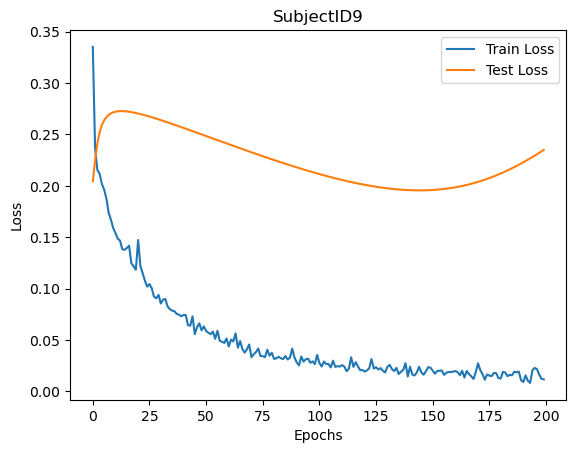

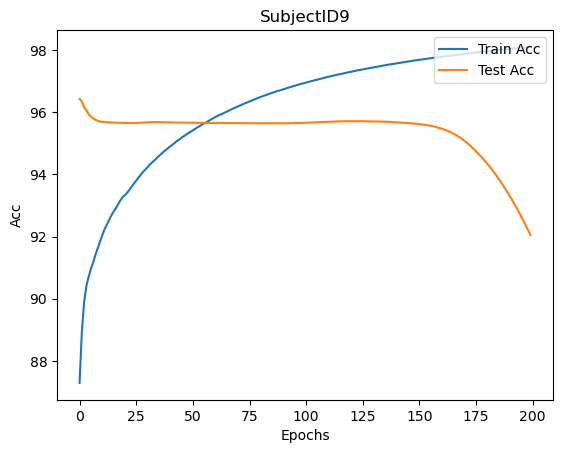

| epoch   0 | 0.0149 s/epoch | train loss 0.7189
| epoch   1 | 0.0156 s/epoch | train loss 0.6937
| epoch   2 | 0.0149 s/epoch | train loss 0.6929
| epoch   3 | 0.0159 s/epoch | train loss 0.6929
| epoch   4 | 0.0165 s/epoch | train loss 0.6929
| epoch   5 | 0.0156 s/epoch | train loss 0.6929
| epoch   6 | 0.0163 s/epoch | train loss 0.6929
| epoch   7 | 0.0150 s/epoch | train loss 0.6928
| epoch   8 | 0.0155 s/epoch | train loss 0.6929
| epoch   9 | 0.0160 s/epoch | train loss 0.6930
| epoch  10 | 0.0153 s/epoch | train loss 0.6929
| epoch  11 | 0.0157 s/epoch | train loss 0.6928
| epoch  12 | 0.0148 s/epoch | train loss 0.6929
| epoch  13 | 0.0150 s/epoch | train loss 0.6928
| epoch  14 | 0.0153 s/epoch | train loss 0.6929
| epoch  15 | 0.0144 s/epoch | train loss 0.6929
| epoch  16 | 0.0151 s/epoch | train loss 0.6929
| epoch  17 | 0.0159 s/epoch | train loss 0.6929
| epoch  18 | 0.0157 s/epoch | train loss 0.6929
| epoch  19 | 0.0151 s/epoch | train loss 0.6930
| epoch  20 | 0.0146

| epoch 168 | 0.0150 s/epoch | train loss 0.6928
| epoch 169 | 0.0152 s/epoch | train loss 0.6929
| epoch 170 | 0.0151 s/epoch | train loss 0.6929
| epoch 171 | 0.0157 s/epoch | train loss 0.6929
| epoch 172 | 0.0155 s/epoch | train loss 0.6929
| epoch 173 | 0.0154 s/epoch | train loss 0.6929
| epoch 174 | 0.0163 s/epoch | train loss 0.6929
| epoch 175 | 0.0151 s/epoch | train loss 0.6929
| epoch 176 | 0.0153 s/epoch | train loss 0.6929
| epoch 177 | 0.0145 s/epoch | train loss 0.6929
| epoch 178 | 0.0152 s/epoch | train loss 0.6929
| epoch 179 | 0.0152 s/epoch | train loss 0.6928
| epoch 180 | 0.0156 s/epoch | train loss 0.6930
| epoch 181 | 0.0151 s/epoch | train loss 0.6929
| epoch 182 | 0.0153 s/epoch | train loss 0.6929
| epoch 183 | 0.0143 s/epoch | train loss 0.6929
| epoch 184 | 0.0145 s/epoch | train loss 0.6928
| epoch 185 | 0.0164 s/epoch | train loss 0.6930
| epoch 186 | 0.0167 s/epoch | train loss 0.6929
| epoch 187 | 0.0145 s/epoch | train loss 0.6929
| epoch 188 | 0.0146

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


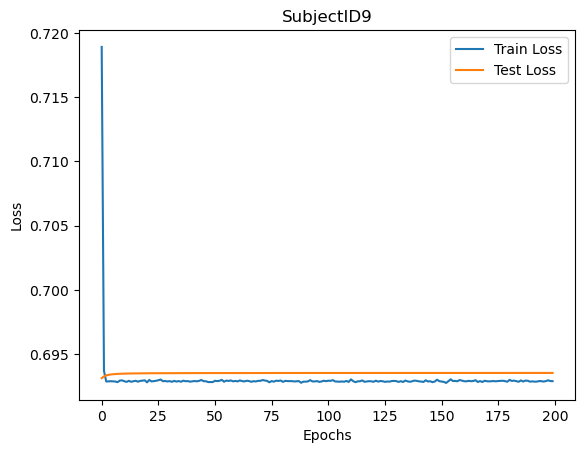

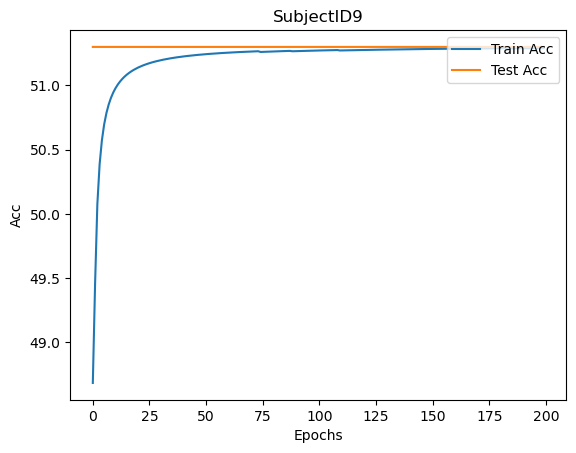


Subject 10
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1697 s/epoch | train loss 0.3283
| epoch   1 | 0.1689 s/epoch | train loss 0.2459
| epoch   2 | 0.1677 s/epoch | train loss 0.2250
| epoch   3 | 0.1684 s/epoch | train loss 0.2089
| epoch   4 | 0.1680 s/epoch | train loss 0.2021
| epoch   5 | 0.1682 s/epoch | train loss 0.1922
| epoch   6 | 0.1692 s/epoch | train loss 0.1820
| epoch   7 | 0.1712 s/epoch | train loss 0.1767
| epoch   8 | 0.1685 s/epoch | train loss 0.2875
| epoch   9 | 0.1681 s/epoch | train loss 0.2448
| epoch  10 | 0.1724 s/epoch | train loss 0.2139
| epoch  11 | 0.1698 s/epoch | train loss 0.1948
| epoch  12 | 0.1698 s/epoch | train loss 0.1862
| epoch  13 | 0.1716 s/epoch | train loss 0.1746
| epoch  14 | 0.1681 s/epoch | train loss 0.1666
| epoch  15 | 0.1703 s/epoch | train loss 0.1590
| epoc

| epoch 163 | 0.1743 s/epoch | train loss 0.0175
| epoch 164 | 0.1752 s/epoch | train loss 0.0208
| epoch 165 | 0.1786 s/epoch | train loss 0.0186
| epoch 166 | 0.1740 s/epoch | train loss 0.0185
| epoch 167 | 0.1753 s/epoch | train loss 0.0210
| epoch 168 | 0.1742 s/epoch | train loss 0.0176
| epoch 169 | 0.1788 s/epoch | train loss 0.0185
| epoch 170 | 0.1783 s/epoch | train loss 0.0129
| epoch 171 | 0.1736 s/epoch | train loss 0.0227
| epoch 172 | 0.1772 s/epoch | train loss 0.0185
| epoch 173 | 0.1761 s/epoch | train loss 0.0190
| epoch 174 | 0.1778 s/epoch | train loss 0.0258
| epoch 175 | 0.1750 s/epoch | train loss 0.0185
| epoch 176 | 0.1767 s/epoch | train loss 0.0185
| epoch 177 | 0.1767 s/epoch | train loss 0.0202
| epoch 178 | 0.1779 s/epoch | train loss 0.0148
| epoch 179 | 0.1759 s/epoch | train loss 0.0154
| epoch 180 | 0.1773 s/epoch | train loss 0.0131
| epoch 181 | 0.1766 s/epoch | train loss 0.0205
| epoch 182 | 0.1772 s/epoch | train loss 0.0138
| epoch 183 | 0.1758

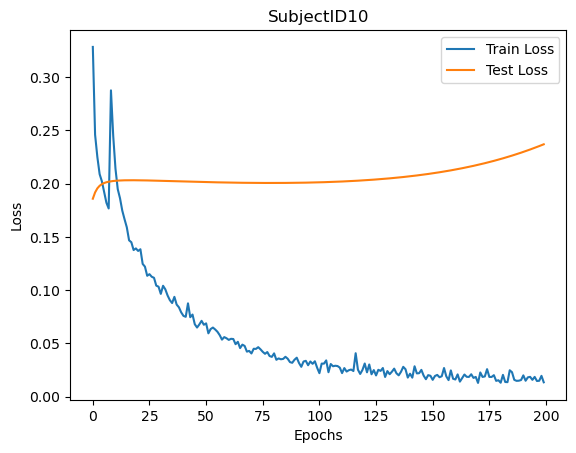

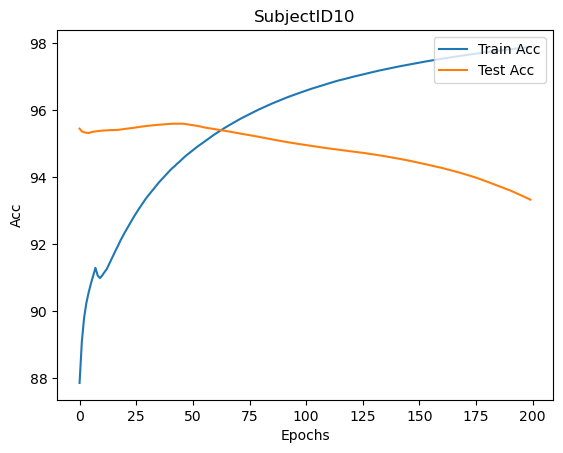

| epoch   0 | 0.0157 s/epoch | train loss 0.6939
| epoch   1 | 0.0160 s/epoch | train loss 0.6930
| epoch   2 | 0.0168 s/epoch | train loss 0.6928
| epoch   3 | 0.0166 s/epoch | train loss 0.6929
| epoch   4 | 0.0155 s/epoch | train loss 0.6929
| epoch   5 | 0.0149 s/epoch | train loss 0.6928
| epoch   6 | 0.0155 s/epoch | train loss 0.6929
| epoch   7 | 0.0152 s/epoch | train loss 0.6928
| epoch   8 | 0.0166 s/epoch | train loss 0.6929
| epoch   9 | 0.0159 s/epoch | train loss 0.6929
| epoch  10 | 0.0170 s/epoch | train loss 0.6928
| epoch  11 | 0.0154 s/epoch | train loss 0.6929
| epoch  12 | 0.0153 s/epoch | train loss 0.6929
| epoch  13 | 0.0144 s/epoch | train loss 0.6929
| epoch  14 | 0.0156 s/epoch | train loss 0.6928
| epoch  15 | 0.0156 s/epoch | train loss 0.6928
| epoch  16 | 0.0159 s/epoch | train loss 0.6928
| epoch  17 | 0.0155 s/epoch | train loss 0.6928
| epoch  18 | 0.0153 s/epoch | train loss 0.6929
| epoch  19 | 0.0162 s/epoch | train loss 0.6929
| epoch  20 | 0.0181

| epoch 168 | 0.0157 s/epoch | train loss 0.6928
| epoch 169 | 0.0160 s/epoch | train loss 0.6928
| epoch 170 | 0.0160 s/epoch | train loss 0.6928
| epoch 171 | 0.0152 s/epoch | train loss 0.6928
| epoch 172 | 0.0161 s/epoch | train loss 0.6929
| epoch 173 | 0.0157 s/epoch | train loss 0.6928
| epoch 174 | 0.0159 s/epoch | train loss 0.6929
| epoch 175 | 0.0169 s/epoch | train loss 0.6929
| epoch 176 | 0.0159 s/epoch | train loss 0.6929
| epoch 177 | 0.0154 s/epoch | train loss 0.6929
| epoch 178 | 0.0149 s/epoch | train loss 0.6928
| epoch 179 | 0.0161 s/epoch | train loss 0.6929
| epoch 180 | 0.0165 s/epoch | train loss 0.6928
| epoch 181 | 0.0158 s/epoch | train loss 0.6929
| epoch 182 | 0.0161 s/epoch | train loss 0.6928
| epoch 183 | 0.0152 s/epoch | train loss 0.6929
| epoch 184 | 0.0171 s/epoch | train loss 0.6929
| epoch 185 | 0.0154 s/epoch | train loss 0.6929
| epoch 186 | 0.0158 s/epoch | train loss 0.6928
| epoch 187 | 0.0161 s/epoch | train loss 0.6928
| epoch 188 | 0.0159

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


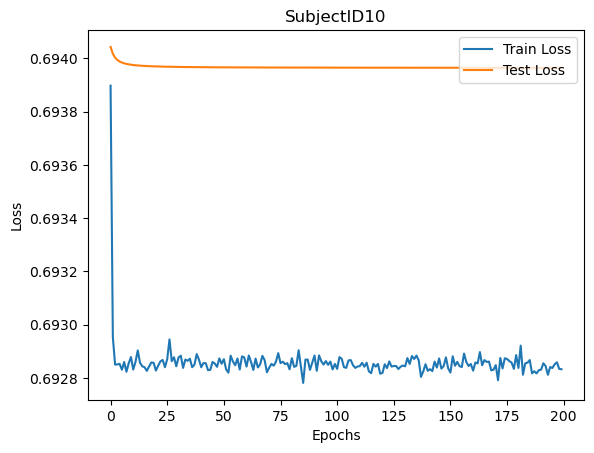

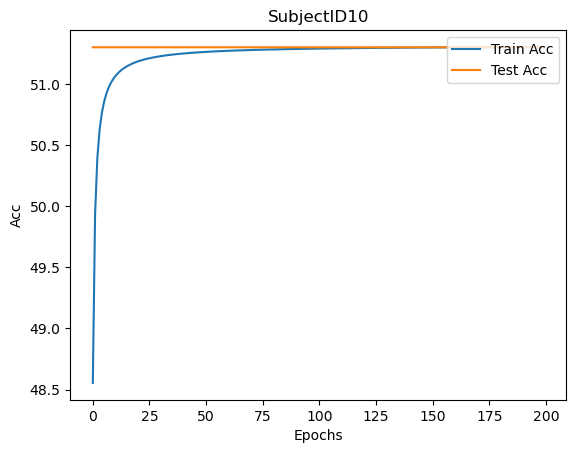


Subject 11
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1778 s/epoch | train loss 0.3354
| epoch   1 | 0.1737 s/epoch | train loss 0.2388
| epoch   2 | 0.1781 s/epoch | train loss 0.2219
| epoch   3 | 0.1750 s/epoch | train loss 0.2134
| epoch   4 | 0.1743 s/epoch | train loss 0.2004
| epoch   5 | 0.1779 s/epoch | train loss 0.1887
| epoch   6 | 0.1913 s/epoch | train loss 0.1885
| epoch   7 | 0.2131 s/epoch | train loss 0.1788
| epoch   8 | 0.2033 s/epoch | train loss 0.1675
| epoch   9 | 0.2153 s/epoch | train loss 0.1713
| epoch  10 | 0.2136 s/epoch | train loss 0.1632
| epoch  11 | 0.2161 s/epoch | train loss 0.1601
| epoch  12 | 0.2147 s/epoch | train loss 0.1488
| epoch  13 | 0.2127 s/epoch | train loss 0.1456
| epoch  14 | 0.2112 s/epoch | train loss 0.1391
| epoch  15 | 0.2126 s/epoch | train loss 0.1348
| epoc

| epoch 163 | 0.1699 s/epoch | train loss 0.0216
| epoch 164 | 0.1726 s/epoch | train loss 0.0150
| epoch 165 | 0.1701 s/epoch | train loss 0.0218
| epoch 166 | 0.1717 s/epoch | train loss 0.0143
| epoch 167 | 0.1702 s/epoch | train loss 0.0242
| epoch 168 | 0.1738 s/epoch | train loss 0.0189
| epoch 169 | 0.1746 s/epoch | train loss 0.0199
| epoch 170 | 0.1729 s/epoch | train loss 0.0219
| epoch 171 | 0.1750 s/epoch | train loss 0.0222
| epoch 172 | 0.1950 s/epoch | train loss 0.0164
| epoch 173 | 0.1682 s/epoch | train loss 0.0179
| epoch 174 | 0.1671 s/epoch | train loss 0.0194
| epoch 175 | 0.1842 s/epoch | train loss 0.0143
| epoch 176 | 0.1691 s/epoch | train loss 0.0177
| epoch 177 | 0.1682 s/epoch | train loss 0.0223
| epoch 178 | 0.1661 s/epoch | train loss 0.0179
| epoch 179 | 0.3045 s/epoch | train loss 0.0180
| epoch 180 | 0.1638 s/epoch | train loss 0.0143
| epoch 181 | 0.1685 s/epoch | train loss 0.0175
| epoch 182 | 0.1682 s/epoch | train loss 0.0175
| epoch 183 | 0.1691

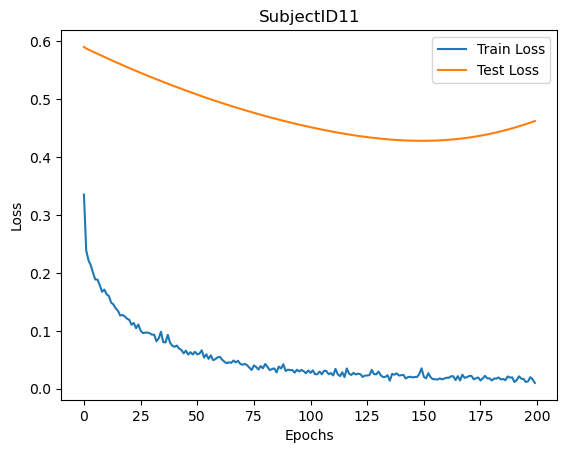

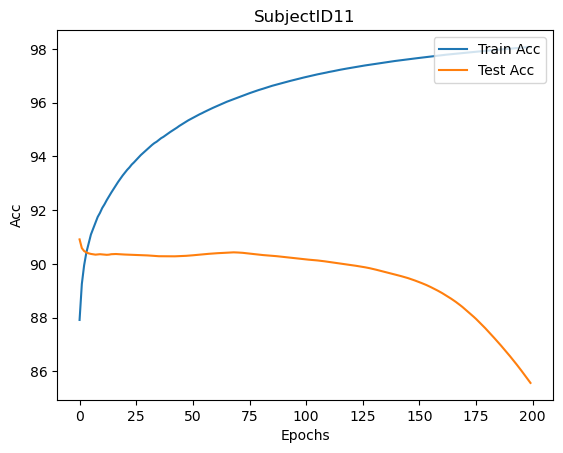

| epoch   0 | 0.0155 s/epoch | train loss 0.6936
| epoch   1 | 0.0158 s/epoch | train loss 0.6928
| epoch   2 | 0.0152 s/epoch | train loss 0.6929
| epoch   3 | 0.0154 s/epoch | train loss 0.6929
| epoch   4 | 0.0155 s/epoch | train loss 0.6929
| epoch   5 | 0.0159 s/epoch | train loss 0.6928
| epoch   6 | 0.0162 s/epoch | train loss 0.6928
| epoch   7 | 0.0157 s/epoch | train loss 0.6929
| epoch   8 | 0.0161 s/epoch | train loss 0.6929
| epoch   9 | 0.0160 s/epoch | train loss 0.6929
| epoch  10 | 0.0159 s/epoch | train loss 0.6928
| epoch  11 | 0.0166 s/epoch | train loss 0.6929
| epoch  12 | 0.0161 s/epoch | train loss 0.6928
| epoch  13 | 0.0155 s/epoch | train loss 0.6928
| epoch  14 | 0.0157 s/epoch | train loss 0.6928
| epoch  15 | 0.0153 s/epoch | train loss 0.6929
| epoch  16 | 0.0169 s/epoch | train loss 0.6928
| epoch  17 | 0.0166 s/epoch | train loss 0.6929
| epoch  18 | 0.0158 s/epoch | train loss 0.6929
| epoch  19 | 0.0166 s/epoch | train loss 0.6928
| epoch  20 | 0.0155

| epoch 168 | 0.0160 s/epoch | train loss 0.3349
| epoch 169 | 0.0160 s/epoch | train loss 0.3347
| epoch 170 | 0.0161 s/epoch | train loss 0.3343
| epoch 171 | 0.0179 s/epoch | train loss 0.3342
| epoch 172 | 0.0159 s/epoch | train loss 0.3330
| epoch 173 | 0.0157 s/epoch | train loss 0.3328
| epoch 174 | 0.0166 s/epoch | train loss 0.3331
| epoch 175 | 0.0168 s/epoch | train loss 0.3330
| epoch 176 | 0.0158 s/epoch | train loss 0.3340
| epoch 177 | 0.0159 s/epoch | train loss 0.3321
| epoch 178 | 0.0159 s/epoch | train loss 0.3314
| epoch 179 | 0.0169 s/epoch | train loss 0.3321
| epoch 180 | 0.0167 s/epoch | train loss 0.3309
| epoch 181 | 0.0175 s/epoch | train loss 0.3316
| epoch 182 | 0.0166 s/epoch | train loss 0.3308
| epoch 183 | 0.0172 s/epoch | train loss 0.3301
| epoch 184 | 0.0156 s/epoch | train loss 0.3302
| epoch 185 | 0.0165 s/epoch | train loss 0.3306
| epoch 186 | 0.0173 s/epoch | train loss 0.3300
| epoch 187 | 0.0167 s/epoch | train loss 0.3299
| epoch 188 | 0.0153

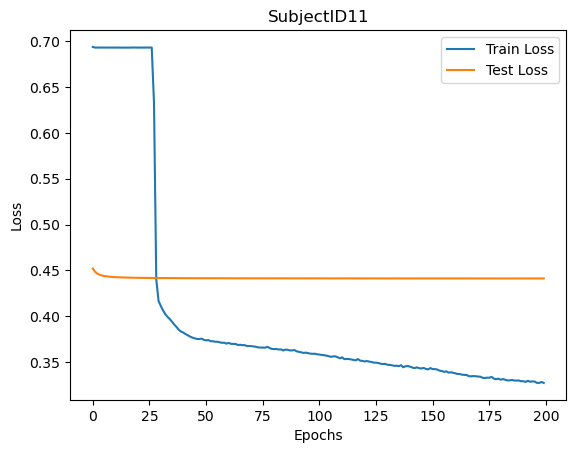

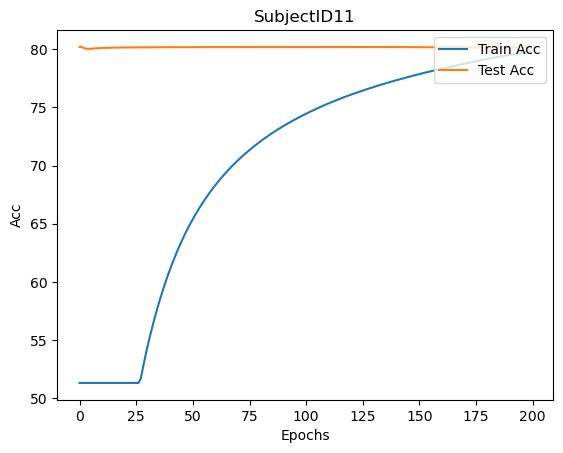


Subject 12
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1741 s/epoch | train loss 0.3306
| epoch   1 | 0.1728 s/epoch | train loss 0.2527
| epoch   2 | 0.2103 s/epoch | train loss 0.2316
| epoch   3 | 0.1715 s/epoch | train loss 0.2121
| epoch   4 | 0.1721 s/epoch | train loss 0.2047
| epoch   5 | 0.1760 s/epoch | train loss 0.1921
| epoch   6 | 0.1730 s/epoch | train loss 0.1945
| epoch   7 | 0.1722 s/epoch | train loss 0.1698
| epoch   8 | 0.1733 s/epoch | train loss 0.1673
| epoch   9 | 0.1742 s/epoch | train loss 0.1646
| epoch  10 | 0.1719 s/epoch | train loss 0.1536
| epoch  11 | 0.1720 s/epoch | train loss 0.1516
| epoch  12 | 0.1730 s/epoch | train loss 0.1497
| epoch  13 | 0.1731 s/epoch | train loss 0.1390
| epoch  14 | 0.1730 s/epoch | train loss 0.1365
| epoch  15 | 0.1735 s/epoch | train loss 0.1315
| epoc

| epoch 163 | 0.1759 s/epoch | train loss 0.0185
| epoch 164 | 0.1737 s/epoch | train loss 0.0157
| epoch 165 | 0.1730 s/epoch | train loss 0.0183
| epoch 166 | 0.1750 s/epoch | train loss 0.0213
| epoch 167 | 0.1741 s/epoch | train loss 0.0241
| epoch 168 | 0.1748 s/epoch | train loss 0.0212
| epoch 169 | 0.1702 s/epoch | train loss 0.0189
| epoch 170 | 0.1746 s/epoch | train loss 0.0157
| epoch 171 | 0.1746 s/epoch | train loss 0.0137
| epoch 172 | 0.1743 s/epoch | train loss 0.0206
| epoch 173 | 0.1746 s/epoch | train loss 0.0165
| epoch 174 | 0.1750 s/epoch | train loss 0.0230
| epoch 175 | 0.1765 s/epoch | train loss 0.0154
| epoch 176 | 0.1727 s/epoch | train loss 0.0205
| epoch 177 | 0.1730 s/epoch | train loss 0.0186
| epoch 178 | 0.1732 s/epoch | train loss 0.0148
| epoch 179 | 0.1743 s/epoch | train loss 0.0201
| epoch 180 | 0.1734 s/epoch | train loss 0.0206
| epoch 181 | 0.1728 s/epoch | train loss 0.0169
| epoch 182 | 0.1753 s/epoch | train loss 0.0148
| epoch 183 | 0.1760

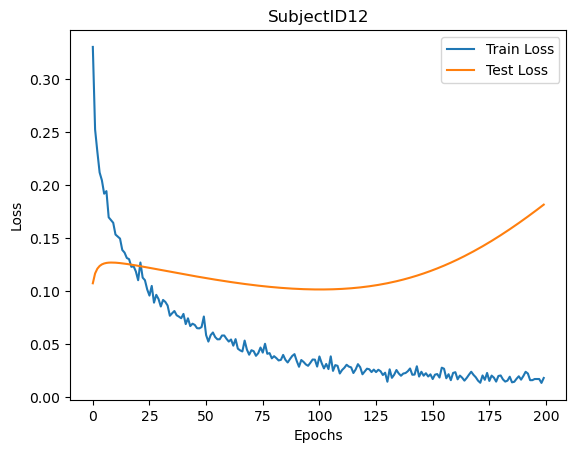

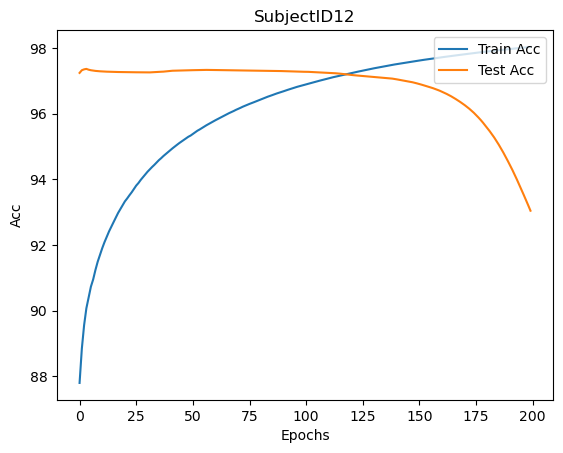

| epoch   0 | 0.0212 s/epoch | train loss 0.6859
| epoch   1 | 0.0228 s/epoch | train loss 0.6259
| epoch   2 | 0.0235 s/epoch | train loss 0.5486
| epoch   3 | 0.0227 s/epoch | train loss 0.5047
| epoch   4 | 0.0219 s/epoch | train loss 0.4794
| epoch   5 | 0.0219 s/epoch | train loss 0.4632
| epoch   6 | 0.0216 s/epoch | train loss 0.4525
| epoch   7 | 0.0235 s/epoch | train loss 0.4431
| epoch   8 | 0.0215 s/epoch | train loss 0.4359
| epoch   9 | 0.0215 s/epoch | train loss 0.4278
| epoch  10 | 0.0212 s/epoch | train loss 0.4224
| epoch  11 | 0.0210 s/epoch | train loss 0.4168
| epoch  12 | 0.0203 s/epoch | train loss 0.4135
| epoch  13 | 0.0215 s/epoch | train loss 0.4093
| epoch  14 | 0.0198 s/epoch | train loss 0.4068
| epoch  15 | 0.0219 s/epoch | train loss 0.4032
| epoch  16 | 0.0215 s/epoch | train loss 0.4002
| epoch  17 | 0.0217 s/epoch | train loss 0.3977
| epoch  18 | 0.0202 s/epoch | train loss 0.3958
| epoch  19 | 0.0234 s/epoch | train loss 0.3924
| epoch  20 | 0.0218

| epoch 168 | 0.0163 s/epoch | train loss 0.3376
| epoch 169 | 0.0159 s/epoch | train loss 0.3365
| epoch 170 | 0.0168 s/epoch | train loss 0.3373
| epoch 171 | 0.0160 s/epoch | train loss 0.3359
| epoch 172 | 0.0155 s/epoch | train loss 0.3363
| epoch 173 | 0.0153 s/epoch | train loss 0.3365
| epoch 174 | 0.0175 s/epoch | train loss 0.3367
| epoch 175 | 0.0162 s/epoch | train loss 0.3358
| epoch 176 | 0.0157 s/epoch | train loss 0.3360
| epoch 177 | 0.0157 s/epoch | train loss 0.3376
| epoch 178 | 0.0151 s/epoch | train loss 0.3360
| epoch 179 | 0.0159 s/epoch | train loss 0.3359
| epoch 180 | 0.0156 s/epoch | train loss 0.3344
| epoch 181 | 0.0156 s/epoch | train loss 0.3373
| epoch 182 | 0.0160 s/epoch | train loss 0.3351
| epoch 183 | 0.0150 s/epoch | train loss 0.3331
| epoch 184 | 0.0172 s/epoch | train loss 0.3345
| epoch 185 | 0.0162 s/epoch | train loss 0.3348
| epoch 186 | 0.0163 s/epoch | train loss 0.3343
| epoch 187 | 0.0159 s/epoch | train loss 0.3345
| epoch 188 | 0.0165

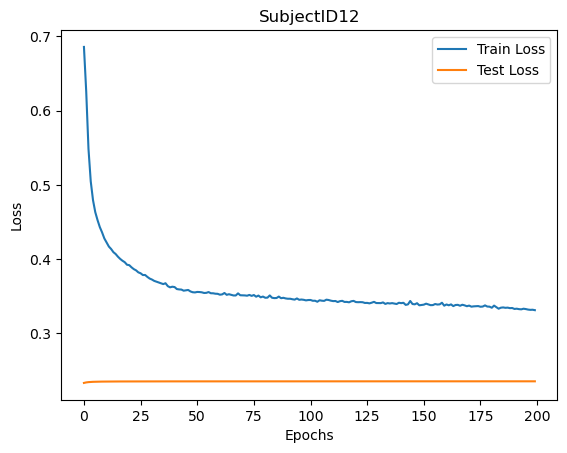

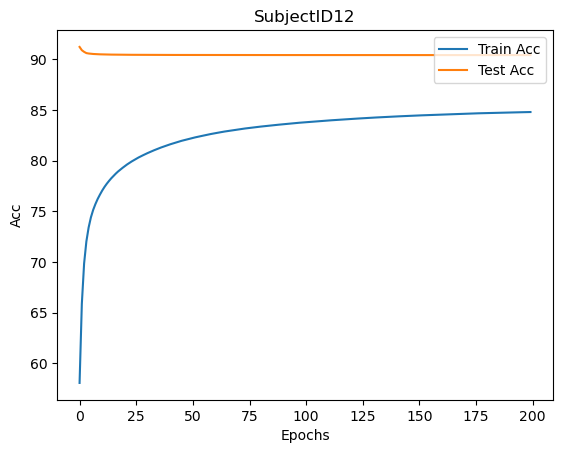


Subject 13
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1721 s/epoch | train loss 0.3369
| epoch   1 | 0.1719 s/epoch | train loss 0.2379
| epoch   2 | 0.1733 s/epoch | train loss 0.2445
| epoch   3 | 0.1696 s/epoch | train loss 0.2085
| epoch   4 | 0.1719 s/epoch | train loss 0.2053
| epoch   5 | 0.1729 s/epoch | train loss 0.1967
| epoch   6 | 0.2595 s/epoch | train loss 0.1978
| epoch   7 | 0.1743 s/epoch | train loss 0.1808
| epoch   8 | 0.1726 s/epoch | train loss 0.1693
| epoch   9 | 0.1727 s/epoch | train loss 0.1709
| epoch  10 | 0.1731 s/epoch | train loss 0.1598
| epoch  11 | 0.1716 s/epoch | train loss 0.1556
| epoch  12 | 0.1728 s/epoch | train loss 0.1488
| epoch  13 | 0.1752 s/epoch | train loss 0.1437
| epoch  14 | 0.1717 s/epoch | train loss 0.1426
| epoch  15 | 0.1728 s/epoch | train loss 0.1333
| epoc

| epoch 163 | 0.1729 s/epoch | train loss 0.0165
| epoch 164 | 0.1728 s/epoch | train loss 0.0190
| epoch 165 | 0.1727 s/epoch | train loss 0.0192
| epoch 166 | 0.1751 s/epoch | train loss 0.0177
| epoch 167 | 0.1730 s/epoch | train loss 0.0185
| epoch 168 | 0.1729 s/epoch | train loss 0.0205
| epoch 169 | 0.1750 s/epoch | train loss 0.0122
| epoch 170 | 0.1764 s/epoch | train loss 0.0296
| epoch 171 | 0.1735 s/epoch | train loss 0.0150
| epoch 172 | 0.1747 s/epoch | train loss 0.0182
| epoch 173 | 0.1767 s/epoch | train loss 0.0166
| epoch 174 | 0.1763 s/epoch | train loss 0.0147
| epoch 175 | 0.1756 s/epoch | train loss 0.0181
| epoch 176 | 0.1738 s/epoch | train loss 0.0183
| epoch 177 | 0.1751 s/epoch | train loss 0.0127
| epoch 178 | 0.1737 s/epoch | train loss 0.0160
| epoch 179 | 0.1723 s/epoch | train loss 0.0178
| epoch 180 | 0.1760 s/epoch | train loss 0.0158
| epoch 181 | 0.1731 s/epoch | train loss 0.0151
| epoch 182 | 0.1756 s/epoch | train loss 0.0137
| epoch 183 | 0.1752

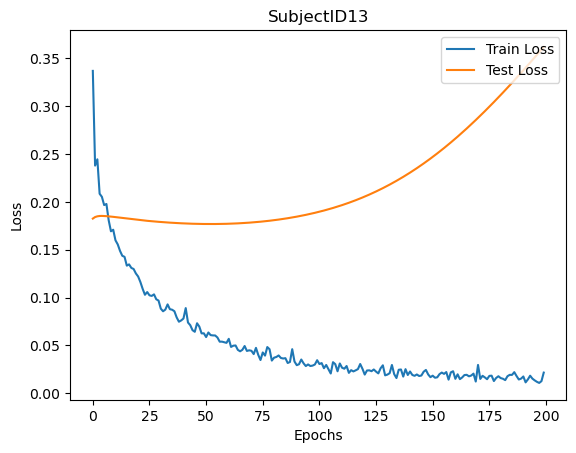

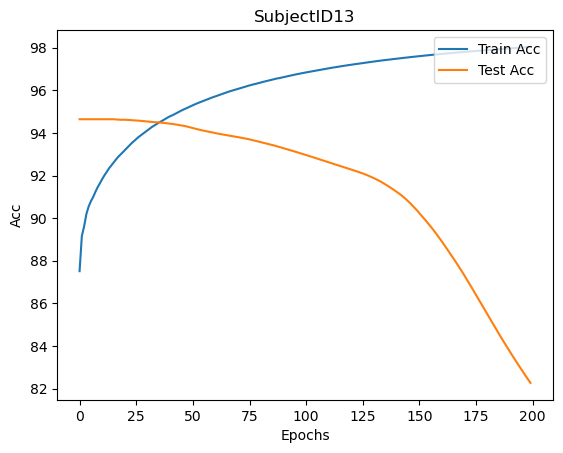

| epoch   0 | 0.0158 s/epoch | train loss 0.7066
| epoch   1 | 0.0167 s/epoch | train loss 0.6950
| epoch   2 | 0.0149 s/epoch | train loss 0.6930
| epoch   3 | 0.0159 s/epoch | train loss 0.6929
| epoch   4 | 0.0161 s/epoch | train loss 0.6838
| epoch   5 | 0.0160 s/epoch | train loss 0.5856
| epoch   6 | 0.0155 s/epoch | train loss 0.5207
| epoch   7 | 0.0163 s/epoch | train loss 0.4897
| epoch   8 | 0.0156 s/epoch | train loss 0.4726
| epoch   9 | 0.0162 s/epoch | train loss 0.4601
| epoch  10 | 0.0160 s/epoch | train loss 0.4517
| epoch  11 | 0.0158 s/epoch | train loss 0.4458
| epoch  12 | 0.0160 s/epoch | train loss 0.4408
| epoch  13 | 0.0153 s/epoch | train loss 0.4356
| epoch  14 | 0.0157 s/epoch | train loss 0.4327
| epoch  15 | 0.0160 s/epoch | train loss 0.4298
| epoch  16 | 0.0164 s/epoch | train loss 0.4261
| epoch  17 | 0.0158 s/epoch | train loss 0.4254
| epoch  18 | 0.0164 s/epoch | train loss 0.4220
| epoch  19 | 0.0157 s/epoch | train loss 0.4193
| epoch  20 | 0.0146

| epoch 168 | 0.0148 s/epoch | train loss 0.3528
| epoch 169 | 0.0151 s/epoch | train loss 0.3535
| epoch 170 | 0.0145 s/epoch | train loss 0.3532
| epoch 171 | 0.0161 s/epoch | train loss 0.3538
| epoch 172 | 0.0158 s/epoch | train loss 0.3537
| epoch 173 | 0.0157 s/epoch | train loss 0.3526
| epoch 174 | 0.0148 s/epoch | train loss 0.3522
| epoch 175 | 0.0147 s/epoch | train loss 0.3525
| epoch 176 | 0.0158 s/epoch | train loss 0.3536
| epoch 177 | 0.0155 s/epoch | train loss 0.3548
| epoch 178 | 0.0156 s/epoch | train loss 0.3530
| epoch 179 | 0.0156 s/epoch | train loss 0.3523
| epoch 180 | 0.0152 s/epoch | train loss 0.3539
| epoch 181 | 0.0152 s/epoch | train loss 0.3527
| epoch 182 | 0.0144 s/epoch | train loss 0.3524
| epoch 183 | 0.0152 s/epoch | train loss 0.3526
| epoch 184 | 0.0159 s/epoch | train loss 0.3527
| epoch 185 | 0.0163 s/epoch | train loss 0.3542
| epoch 186 | 0.0155 s/epoch | train loss 0.3528
| epoch 187 | 0.0161 s/epoch | train loss 0.3525
| epoch 188 | 0.0163

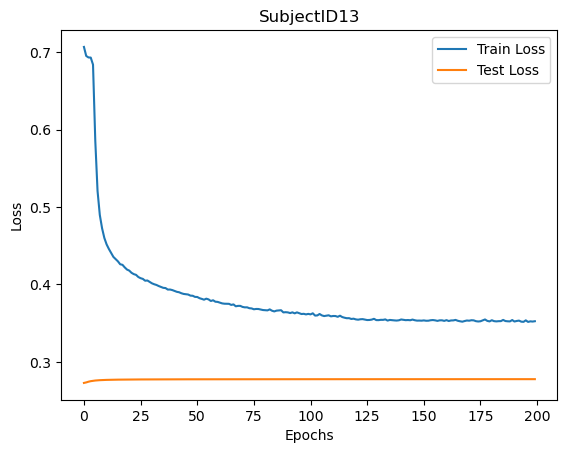

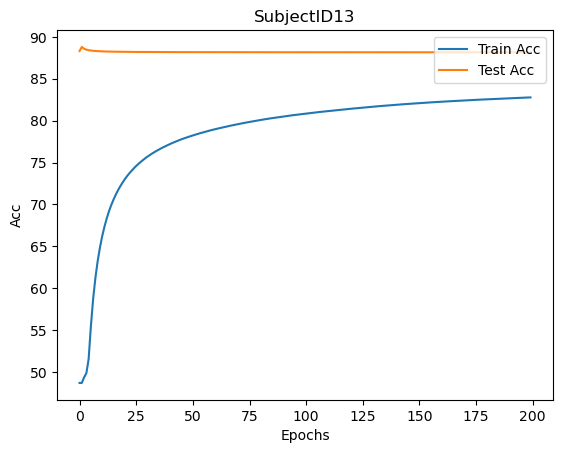


Subject 14
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1779 s/epoch | train loss 0.3293
| epoch   1 | 0.1739 s/epoch | train loss 0.2429
| epoch   2 | 0.1711 s/epoch | train loss 0.2260
| epoch   3 | 0.1737 s/epoch | train loss 0.2102
| epoch   4 | 0.1739 s/epoch | train loss 0.2006
| epoch   5 | 0.1777 s/epoch | train loss 0.1966
| epoch   6 | 0.1739 s/epoch | train loss 0.2036
| epoch   7 | 0.1790 s/epoch | train loss 0.1798
| epoch   8 | 0.1759 s/epoch | train loss 0.1696
| epoch   9 | 0.1779 s/epoch | train loss 0.1555
| epoch  10 | 0.1757 s/epoch | train loss 0.1594
| epoch  11 | 0.1753 s/epoch | train loss 0.1496
| epoch  12 | 0.1761 s/epoch | train loss 0.1414
| epoch  13 | 0.1746 s/epoch | train loss 0.1414
| epoch  14 | 0.1732 s/epoch | train loss 0.1336
| epoch  15 | 0.1744 s/epoch | train loss 0.1255
| epoc

| epoch 163 | 0.1753 s/epoch | train loss 0.0235
| epoch 164 | 0.1747 s/epoch | train loss 0.0151
| epoch 165 | 0.1769 s/epoch | train loss 0.0168
| epoch 166 | 0.1759 s/epoch | train loss 0.0129
| epoch 167 | 0.1752 s/epoch | train loss 0.0237
| epoch 168 | 0.1736 s/epoch | train loss 0.0163
| epoch 169 | 0.1763 s/epoch | train loss 0.0179
| epoch 170 | 0.1748 s/epoch | train loss 0.0171
| epoch 171 | 0.1749 s/epoch | train loss 0.0192
| epoch 172 | 0.1786 s/epoch | train loss 0.0261
| epoch 173 | 0.1777 s/epoch | train loss 0.0295
| epoch 174 | 0.1772 s/epoch | train loss 0.0154
| epoch 175 | 0.1758 s/epoch | train loss 0.0162
| epoch 176 | 0.1748 s/epoch | train loss 0.0147
| epoch 177 | 0.1861 s/epoch | train loss 0.0165
| epoch 178 | 0.1768 s/epoch | train loss 0.0196
| epoch 179 | 0.1767 s/epoch | train loss 0.0109
| epoch 180 | 0.1776 s/epoch | train loss 0.0148
| epoch 181 | 0.1777 s/epoch | train loss 0.0116
| epoch 182 | 0.1773 s/epoch | train loss 0.0198
| epoch 183 | 0.1775

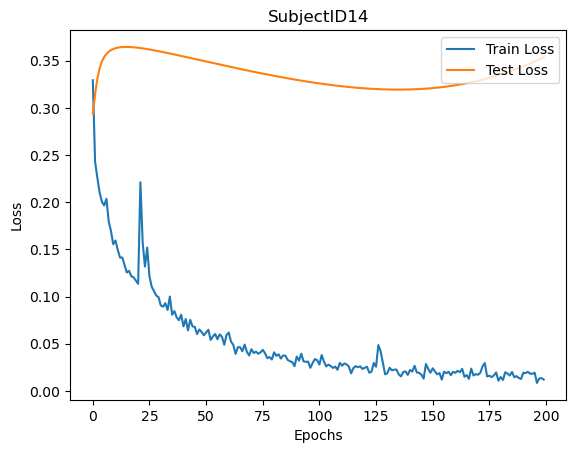

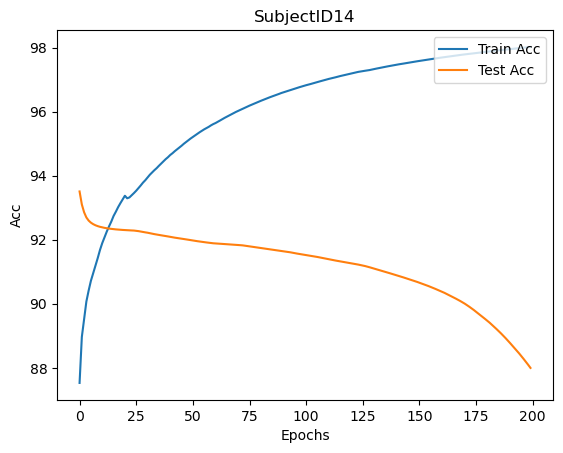

| epoch   0 | 0.1210 s/epoch | train loss 0.7768
| epoch   1 | 0.1248 s/epoch | train loss 0.7279
| epoch   2 | 0.1174 s/epoch | train loss 0.7046
| epoch   3 | 0.1163 s/epoch | train loss 0.6961
| epoch   4 | 0.0797 s/epoch | train loss 0.6936
| epoch   5 | 0.0548 s/epoch | train loss 0.6929
| epoch   6 | 0.0611 s/epoch | train loss 0.6928
| epoch   7 | 0.0620 s/epoch | train loss 0.6928
| epoch   8 | 0.0638 s/epoch | train loss 0.6928
| epoch   9 | 0.0715 s/epoch | train loss 0.6928
| epoch  10 | 0.0720 s/epoch | train loss 0.6928
| epoch  11 | 0.0684 s/epoch | train loss 0.6928
| epoch  12 | 0.0640 s/epoch | train loss 0.6928
| epoch  13 | 0.0622 s/epoch | train loss 0.6928
| epoch  14 | 0.0629 s/epoch | train loss 0.6928
| epoch  15 | 0.0637 s/epoch | train loss 0.6928
| epoch  16 | 0.0633 s/epoch | train loss 0.6929
| epoch  17 | 0.0630 s/epoch | train loss 0.6929
| epoch  18 | 0.0656 s/epoch | train loss 0.6928
| epoch  19 | 0.0627 s/epoch | train loss 0.6928
| epoch  20 | 0.0634

| epoch 168 | 0.0695 s/epoch | train loss 0.6929
| epoch 169 | 0.0638 s/epoch | train loss 0.6929
| epoch 170 | 0.0655 s/epoch | train loss 0.6928
| epoch 171 | 0.0587 s/epoch | train loss 0.6929
| epoch 172 | 0.0627 s/epoch | train loss 0.6929
| epoch 173 | 0.0747 s/epoch | train loss 0.6928
| epoch 174 | 0.0709 s/epoch | train loss 0.6928
| epoch 175 | 0.0648 s/epoch | train loss 0.6928
| epoch 176 | 0.0628 s/epoch | train loss 0.6928
| epoch 177 | 0.0500 s/epoch | train loss 0.6929
| epoch 178 | 0.0766 s/epoch | train loss 0.6928
| epoch 179 | 0.0969 s/epoch | train loss 0.6928
| epoch 180 | 0.1375 s/epoch | train loss 0.6928
| epoch 181 | 0.1378 s/epoch | train loss 0.6929
| epoch 182 | 0.1309 s/epoch | train loss 0.6929
| epoch 183 | 0.1286 s/epoch | train loss 0.6929
| epoch 184 | 0.1203 s/epoch | train loss 0.6929
| epoch 185 | 0.1291 s/epoch | train loss 0.6929
| epoch 186 | 0.1282 s/epoch | train loss 0.6928
| epoch 187 | 0.0817 s/epoch | train loss 0.6928
| epoch 188 | 0.0603

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


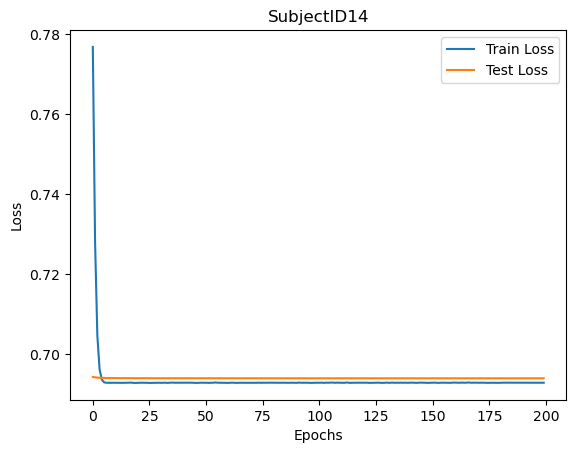

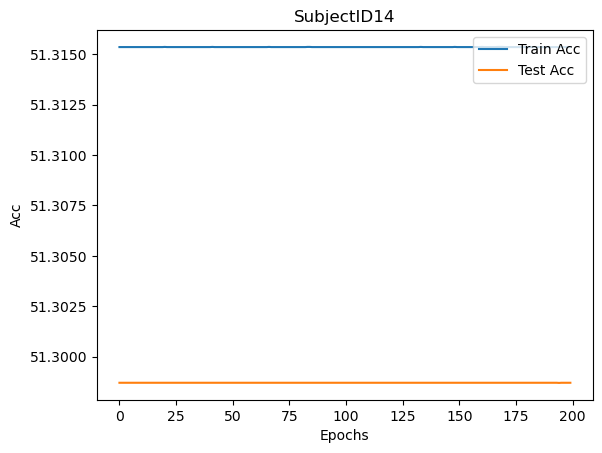


Subject 15
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2133 s/epoch | train loss 0.3258
| epoch   1 | 0.2076 s/epoch | train loss 0.2292
| epoch   2 | 0.2060 s/epoch | train loss 0.2112
| epoch   3 | 0.1945 s/epoch | train loss 0.1995
| epoch   4 | 0.1952 s/epoch | train loss 0.2109
| epoch   5 | 0.2180 s/epoch | train loss 0.1920
| epoch   6 | 0.1947 s/epoch | train loss 0.1856
| epoch   7 | 0.1982 s/epoch | train loss 0.1708
| epoch   8 | 0.1991 s/epoch | train loss 0.1645
| epoch   9 | 0.2104 s/epoch | train loss 0.1602
| epoch  10 | 0.2063 s/epoch | train loss 0.1493
| epoch  11 | 0.2023 s/epoch | train loss 0.1493
| epoch  12 | 0.2008 s/epoch | train loss 0.1459
| epoch  13 | 0.2016 s/epoch | train loss 0.1388
| epoch  14 | 0.1955 s/epoch | train loss 0.1339
| epoch  15 | 0.2019 s/epoch | train loss 0.1283
| epoc

| epoch 163 | 0.1774 s/epoch | train loss 0.0123
| epoch 164 | 0.1774 s/epoch | train loss 0.0181
| epoch 165 | 0.1754 s/epoch | train loss 0.0204
| epoch 166 | 0.1741 s/epoch | train loss 0.0177
| epoch 167 | 0.1987 s/epoch | train loss 0.0169
| epoch 168 | 0.2786 s/epoch | train loss 0.0238
| epoch 169 | 0.1769 s/epoch | train loss 0.0197
| epoch 170 | 0.1760 s/epoch | train loss 0.0163
| epoch 171 | 0.1748 s/epoch | train loss 0.0215
| epoch 172 | 0.1774 s/epoch | train loss 0.0191
| epoch 173 | 0.1784 s/epoch | train loss 0.0193
| epoch 174 | 0.1795 s/epoch | train loss 0.0131
| epoch 175 | 0.1749 s/epoch | train loss 0.0137
| epoch 176 | 0.2135 s/epoch | train loss 0.0160
| epoch 177 | 0.4839 s/epoch | train loss 0.0154
| epoch 178 | 0.4055 s/epoch | train loss 0.0193
| epoch 179 | 0.1767 s/epoch | train loss 0.0112
| epoch 180 | 0.1741 s/epoch | train loss 0.0164
| epoch 181 | 0.1747 s/epoch | train loss 0.0165
| epoch 182 | 0.1761 s/epoch | train loss 0.0177
| epoch 183 | 0.1802

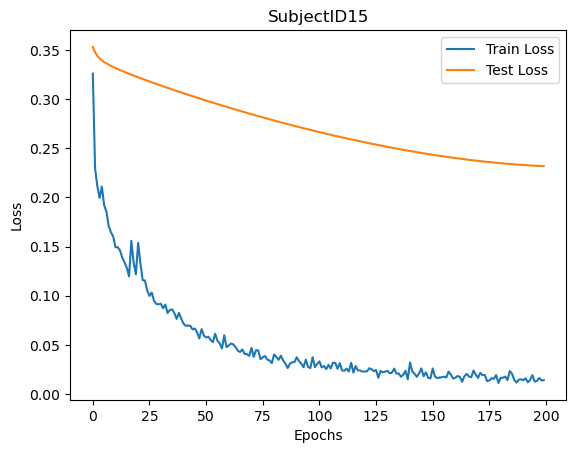

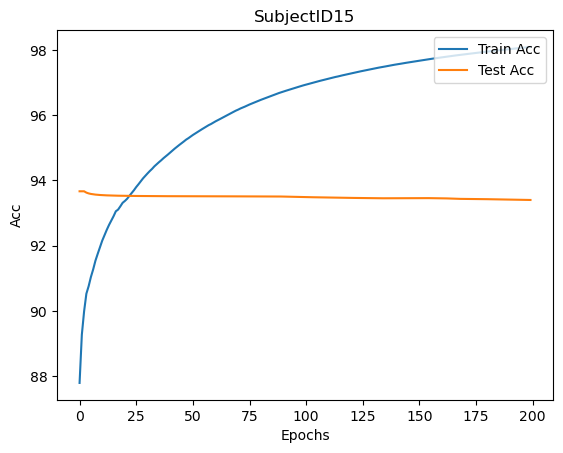

| epoch   0 | 0.0160 s/epoch | train loss 0.7133
| epoch   1 | 0.0164 s/epoch | train loss 0.6969
| epoch   2 | 0.0165 s/epoch | train loss 0.6933
| epoch   3 | 0.0154 s/epoch | train loss 0.6929
| epoch   4 | 0.0159 s/epoch | train loss 0.6929
| epoch   5 | 0.0160 s/epoch | train loss 0.6928
| epoch   6 | 0.0158 s/epoch | train loss 0.6928
| epoch   7 | 0.0169 s/epoch | train loss 0.6929
| epoch   8 | 0.0169 s/epoch | train loss 0.6928
| epoch   9 | 0.0158 s/epoch | train loss 0.6929
| epoch  10 | 0.0161 s/epoch | train loss 0.6929
| epoch  11 | 0.0160 s/epoch | train loss 0.6929
| epoch  12 | 0.0169 s/epoch | train loss 0.6928
| epoch  13 | 0.0159 s/epoch | train loss 0.6929
| epoch  14 | 0.0169 s/epoch | train loss 0.6929
| epoch  15 | 0.0161 s/epoch | train loss 0.6929
| epoch  16 | 0.0166 s/epoch | train loss 0.6929
| epoch  17 | 0.0165 s/epoch | train loss 0.6929
| epoch  18 | 0.0162 s/epoch | train loss 0.6929
| epoch  19 | 0.0170 s/epoch | train loss 0.6928
| epoch  20 | 0.0179

| epoch 168 | 0.0192 s/epoch | train loss 0.6929
| epoch 169 | 0.0189 s/epoch | train loss 0.6928
| epoch 170 | 0.0194 s/epoch | train loss 0.6928
| epoch 171 | 0.0200 s/epoch | train loss 0.6928
| epoch 172 | 0.0174 s/epoch | train loss 0.6929
| epoch 173 | 0.0179 s/epoch | train loss 0.6929
| epoch 174 | 0.0161 s/epoch | train loss 0.6929
| epoch 175 | 0.0169 s/epoch | train loss 0.6929
| epoch 176 | 0.0170 s/epoch | train loss 0.6928
| epoch 177 | 0.0173 s/epoch | train loss 0.6929
| epoch 178 | 0.0175 s/epoch | train loss 0.6929
| epoch 179 | 0.0168 s/epoch | train loss 0.6928
| epoch 180 | 0.0180 s/epoch | train loss 0.6929
| epoch 181 | 0.0198 s/epoch | train loss 0.6928
| epoch 182 | 0.0187 s/epoch | train loss 0.6928
| epoch 183 | 0.0192 s/epoch | train loss 0.6928
| epoch 184 | 0.0186 s/epoch | train loss 0.6928
| epoch 185 | 0.0183 s/epoch | train loss 0.6929
| epoch 186 | 0.0192 s/epoch | train loss 0.6928
| epoch 187 | 0.0191 s/epoch | train loss 0.6928
| epoch 188 | 0.0199

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


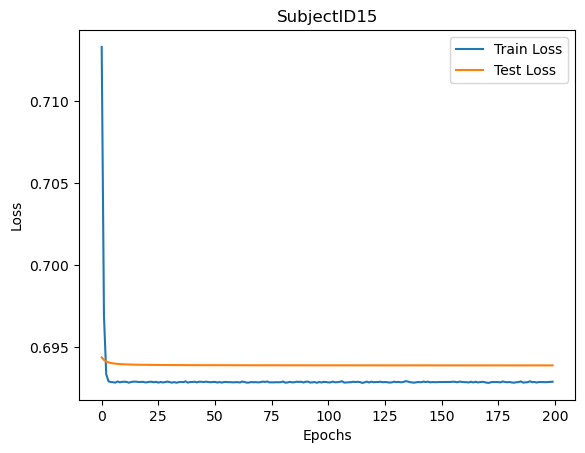

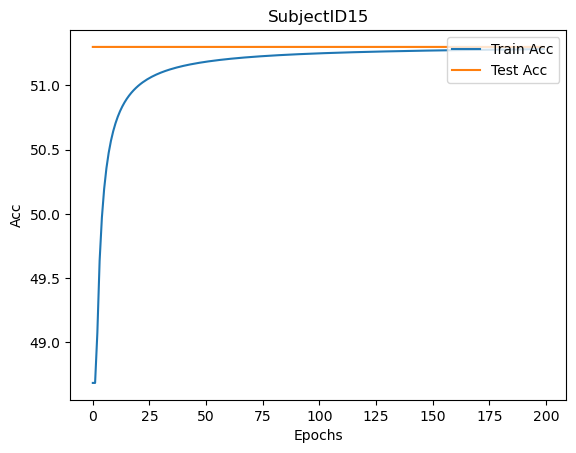


Subject 16
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2032 s/epoch | train loss 0.3285
| epoch   1 | 0.2070 s/epoch | train loss 0.2567
| epoch   2 | 0.1984 s/epoch | train loss 0.2343
| epoch   3 | 0.2041 s/epoch | train loss 0.2202
| epoch   4 | 0.2102 s/epoch | train loss 0.2146
| epoch   5 | 0.2061 s/epoch | train loss 0.2002
| epoch   6 | 0.2015 s/epoch | train loss 0.1928
| epoch   7 | 0.1944 s/epoch | train loss 0.1825
| epoch   8 | 0.2014 s/epoch | train loss 0.1800
| epoch   9 | 0.2099 s/epoch | train loss 0.1682
| epoch  10 | 0.2085 s/epoch | train loss 0.1595
| epoch  11 | 0.1990 s/epoch | train loss 0.1591
| epoch  12 | 0.2014 s/epoch | train loss 0.1465
| epoch  13 | 0.2076 s/epoch | train loss 0.1441
| epoch  14 | 0.2044 s/epoch | train loss 0.1656
| epoch  15 | 0.2122 s/epoch | train loss 0.1573
| epoc

| epoch 163 | 0.1971 s/epoch | train loss 0.0212
| epoch 164 | 0.2036 s/epoch | train loss 0.0139
| epoch 165 | 0.2068 s/epoch | train loss 0.0170
| epoch 166 | 0.2044 s/epoch | train loss 0.0172
| epoch 167 | 0.1996 s/epoch | train loss 0.0184
| epoch 168 | 0.2173 s/epoch | train loss 0.0193
| epoch 169 | 0.2011 s/epoch | train loss 0.0169
| epoch 170 | 0.2007 s/epoch | train loss 0.0194
| epoch 171 | 0.2025 s/epoch | train loss 0.0172
| epoch 172 | 0.2061 s/epoch | train loss 0.0185
| epoch 173 | 0.2044 s/epoch | train loss 0.0159
| epoch 174 | 0.2000 s/epoch | train loss 0.0240
| epoch 175 | 0.2082 s/epoch | train loss 0.0204
| epoch 176 | 0.2127 s/epoch | train loss 0.0168
| epoch 177 | 0.1998 s/epoch | train loss 0.0255
| epoch 178 | 0.2041 s/epoch | train loss 0.0196
| epoch 179 | 0.2034 s/epoch | train loss 0.0135
| epoch 180 | 0.2045 s/epoch | train loss 0.0150
| epoch 181 | 0.2035 s/epoch | train loss 0.0176
| epoch 182 | 0.1989 s/epoch | train loss 0.0223
| epoch 183 | 0.1991

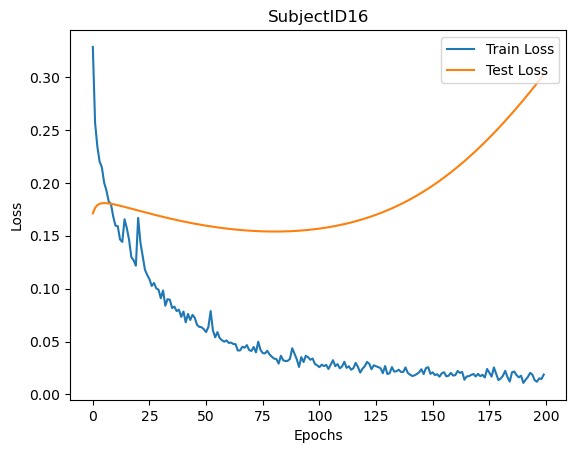

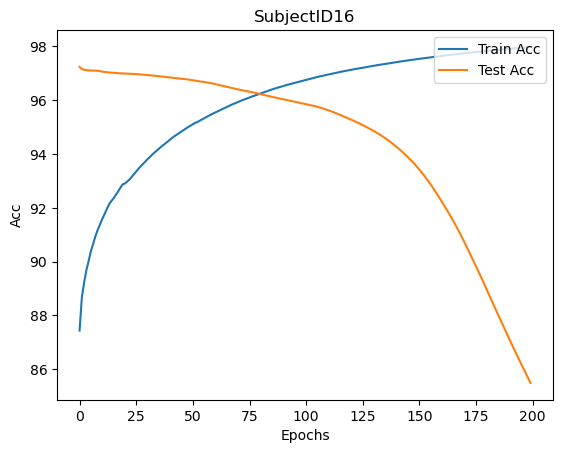

| epoch   0 | 0.0213 s/epoch | train loss 0.7411
| epoch   1 | 0.0228 s/epoch | train loss 0.6499
| epoch   2 | 0.0225 s/epoch | train loss 0.5540
| epoch   3 | 0.0220 s/epoch | train loss 0.4664
| epoch   4 | 0.0233 s/epoch | train loss 0.4341
| epoch   5 | 0.0213 s/epoch | train loss 0.4278
| epoch   6 | 0.0224 s/epoch | train loss 0.4246
| epoch   7 | 0.0214 s/epoch | train loss 0.4224
| epoch   8 | 0.0219 s/epoch | train loss 0.4204
| epoch   9 | 0.0223 s/epoch | train loss 0.4178
| epoch  10 | 0.0205 s/epoch | train loss 0.4153
| epoch  11 | 0.0221 s/epoch | train loss 0.4145
| epoch  12 | 0.0212 s/epoch | train loss 0.4122
| epoch  13 | 0.0210 s/epoch | train loss 0.4091
| epoch  14 | 0.0205 s/epoch | train loss 0.4079
| epoch  15 | 0.0213 s/epoch | train loss 0.4044
| epoch  16 | 0.0224 s/epoch | train loss 0.4028
| epoch  17 | 0.0215 s/epoch | train loss 0.4004
| epoch  18 | 0.0213 s/epoch | train loss 0.3978
| epoch  19 | 0.0203 s/epoch | train loss 0.3962
| epoch  20 | 0.0206

| epoch 168 | 0.0199 s/epoch | train loss 0.3415
| epoch 169 | 0.0196 s/epoch | train loss 0.3426
| epoch 170 | 0.0202 s/epoch | train loss 0.3416
| epoch 171 | 0.0199 s/epoch | train loss 0.3415
| epoch 172 | 0.0196 s/epoch | train loss 0.3419
| epoch 173 | 0.0181 s/epoch | train loss 0.3417
| epoch 174 | 0.0200 s/epoch | train loss 0.3416
| epoch 175 | 0.0204 s/epoch | train loss 0.3406
| epoch 176 | 0.0200 s/epoch | train loss 0.3419
| epoch 177 | 0.0191 s/epoch | train loss 0.3417
| epoch 178 | 0.0198 s/epoch | train loss 0.3412
| epoch 179 | 0.0196 s/epoch | train loss 0.3418
| epoch 180 | 0.0206 s/epoch | train loss 0.3404
| epoch 181 | 0.0223 s/epoch | train loss 0.3416
| epoch 182 | 0.0197 s/epoch | train loss 0.3418
| epoch 183 | 0.0194 s/epoch | train loss 0.3416
| epoch 184 | 0.0200 s/epoch | train loss 0.3412
| epoch 185 | 0.0196 s/epoch | train loss 0.3411
| epoch 186 | 0.0182 s/epoch | train loss 0.3405
| epoch 187 | 0.0201 s/epoch | train loss 0.3419
| epoch 188 | 0.0191

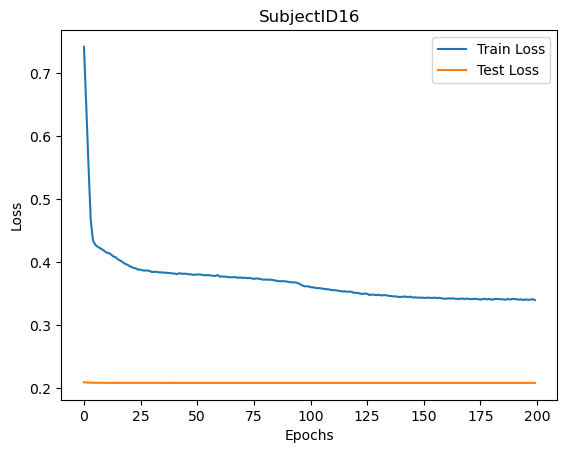

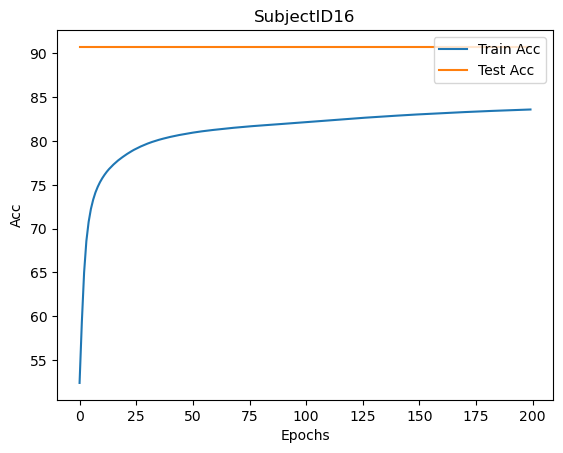


Subject 18
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.2155 s/epoch | train loss 0.3258
| epoch   1 | 0.2158 s/epoch | train loss 0.2468
| epoch   2 | 0.8004 s/epoch | train loss 0.2287
| epoch   3 | 0.5667 s/epoch | train loss 0.2242
| epoch   4 | 0.2177 s/epoch | train loss 0.2035
| epoch   5 | 0.2220 s/epoch | train loss 0.1907
| epoch   6 | 0.2160 s/epoch | train loss 0.1821
| epoch   7 | 0.2134 s/epoch | train loss 0.1706
| epoch   8 | 0.2098 s/epoch | train loss 0.1764
| epoch   9 | 0.2162 s/epoch | train loss 0.1615
| epoch  10 | 0.2047 s/epoch | train loss 0.1503
| epoch  11 | 0.1973 s/epoch | train loss 0.1477
| epoch  12 | 0.2002 s/epoch | train loss 0.1389
| epoch  13 | 0.1964 s/epoch | train loss 0.1344
| epoch  14 | 0.1974 s/epoch | train loss 0.1278
| epoch  15 | 0.1990 s/epoch | train loss 0.1284
| epoc

| epoch 163 | 0.1721 s/epoch | train loss 0.0193
| epoch 164 | 0.1731 s/epoch | train loss 0.0186
| epoch 165 | 0.1719 s/epoch | train loss 0.0181
| epoch 166 | 0.1711 s/epoch | train loss 0.0215
| epoch 167 | 0.1722 s/epoch | train loss 0.0183
| epoch 168 | 0.1705 s/epoch | train loss 0.0221
| epoch 169 | 0.1728 s/epoch | train loss 0.0233
| epoch 170 | 0.1729 s/epoch | train loss 0.0179
| epoch 171 | 0.1714 s/epoch | train loss 0.0168
| epoch 172 | 0.1744 s/epoch | train loss 0.0165
| epoch 173 | 0.1722 s/epoch | train loss 0.0214
| epoch 174 | 0.1725 s/epoch | train loss 0.0166
| epoch 175 | 0.1716 s/epoch | train loss 0.0171
| epoch 176 | 0.1750 s/epoch | train loss 0.0167
| epoch 177 | 0.1730 s/epoch | train loss 0.0130
| epoch 178 | 0.1748 s/epoch | train loss 0.0192
| epoch 179 | 0.1740 s/epoch | train loss 0.0152
| epoch 180 | 0.1785 s/epoch | train loss 0.0168
| epoch 181 | 0.1746 s/epoch | train loss 0.0173
| epoch 182 | 0.1698 s/epoch | train loss 0.0221
| epoch 183 | 0.1737

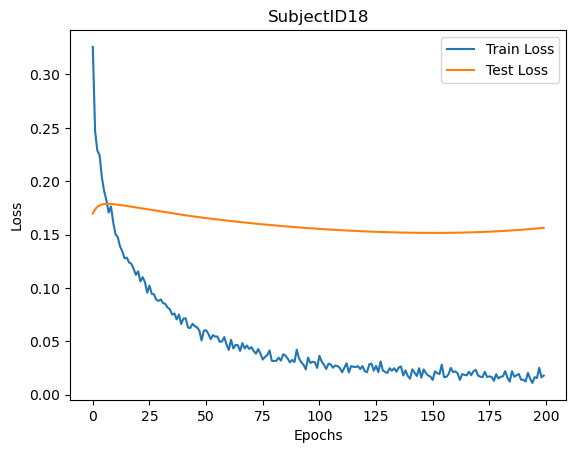

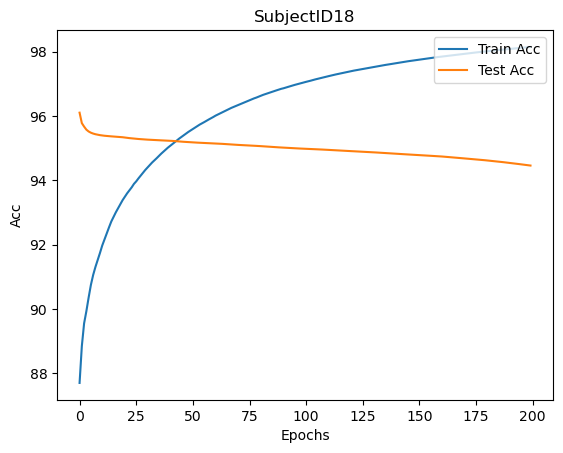

| epoch   0 | 0.0160 s/epoch | train loss 0.7306
| epoch   1 | 0.0149 s/epoch | train loss 0.7040
| epoch   2 | 0.0154 s/epoch | train loss 0.6952
| epoch   3 | 0.0153 s/epoch | train loss 0.6932
| epoch   4 | 0.0160 s/epoch | train loss 0.6929
| epoch   5 | 0.0170 s/epoch | train loss 0.6928
| epoch   6 | 0.0163 s/epoch | train loss 0.6928
| epoch   7 | 0.0165 s/epoch | train loss 0.6928
| epoch   8 | 0.0156 s/epoch | train loss 0.6929
| epoch   9 | 0.0157 s/epoch | train loss 0.6929
| epoch  10 | 0.0154 s/epoch | train loss 0.6928
| epoch  11 | 0.0171 s/epoch | train loss 0.6929
| epoch  12 | 0.0152 s/epoch | train loss 0.6928
| epoch  13 | 0.0155 s/epoch | train loss 0.6928
| epoch  14 | 0.0156 s/epoch | train loss 0.6909
| epoch  15 | 0.0160 s/epoch | train loss 0.6819
| epoch  16 | 0.0159 s/epoch | train loss 0.6791
| epoch  17 | 0.0159 s/epoch | train loss 0.6782
| epoch  18 | 0.0174 s/epoch | train loss 0.6778
| epoch  19 | 0.0151 s/epoch | train loss 0.6775
| epoch  20 | 0.0156

| epoch 168 | 0.0153 s/epoch | train loss 0.3264
| epoch 169 | 0.0160 s/epoch | train loss 0.3252
| epoch 170 | 0.0153 s/epoch | train loss 0.3268
| epoch 171 | 0.0152 s/epoch | train loss 0.3253
| epoch 172 | 0.0151 s/epoch | train loss 0.3249
| epoch 173 | 0.0158 s/epoch | train loss 0.3245
| epoch 174 | 0.0157 s/epoch | train loss 0.3248
| epoch 175 | 0.0153 s/epoch | train loss 0.3258
| epoch 176 | 0.0154 s/epoch | train loss 0.3253
| epoch 177 | 0.0165 s/epoch | train loss 0.3260
| epoch 178 | 0.0161 s/epoch | train loss 0.3248
| epoch 179 | 0.0157 s/epoch | train loss 0.3237
| epoch 180 | 0.0158 s/epoch | train loss 0.3255
| epoch 181 | 0.0157 s/epoch | train loss 0.3277
| epoch 182 | 0.0162 s/epoch | train loss 0.3248
| epoch 183 | 0.0160 s/epoch | train loss 0.3260
| epoch 184 | 0.0150 s/epoch | train loss 0.3252
| epoch 185 | 0.0158 s/epoch | train loss 0.3242
| epoch 186 | 0.0164 s/epoch | train loss 0.3245
| epoch 187 | 0.0163 s/epoch | train loss 0.3249
| epoch 188 | 0.0156

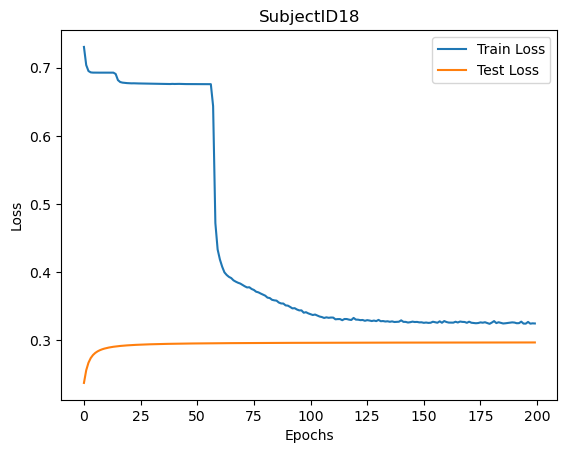

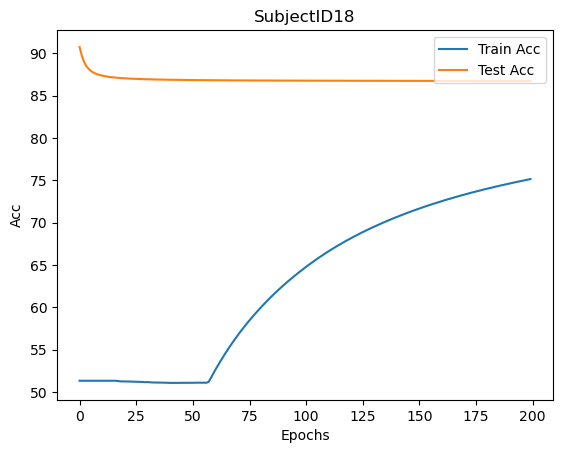


Subject 19
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1738 s/epoch | train loss 0.3421
| epoch   1 | 0.1735 s/epoch | train loss 0.2350
| epoch   2 | 0.1709 s/epoch | train loss 0.2213
| epoch   3 | 0.1725 s/epoch | train loss 0.2177
| epoch   4 | 0.1717 s/epoch | train loss 0.2091
| epoch   5 | 0.1736 s/epoch | train loss 0.2143
| epoch   6 | 0.1755 s/epoch | train loss 0.1879
| epoch   7 | 0.1749 s/epoch | train loss 0.1869
| epoch   8 | 0.1722 s/epoch | train loss 0.1756
| epoch   9 | 0.1738 s/epoch | train loss 0.1664
| epoch  10 | 0.1721 s/epoch | train loss 0.1636
| epoch  11 | 0.1697 s/epoch | train loss 0.1884
| epoch  12 | 0.1719 s/epoch | train loss 0.2056
| epoch  13 | 0.1708 s/epoch | train loss 0.2199
| epoch  14 | 0.1713 s/epoch | train loss 0.2149
| epoch  15 | 0.1758 s/epoch | train loss 0.1829
| epoc

| epoch 163 | 0.1679 s/epoch | train loss 0.0163
| epoch 164 | 0.1704 s/epoch | train loss 0.0186
| epoch 165 | 0.1669 s/epoch | train loss 0.0209
| epoch 166 | 0.1690 s/epoch | train loss 0.0245
| epoch 167 | 0.1664 s/epoch | train loss 0.0214
| epoch 168 | 0.1690 s/epoch | train loss 0.0193
| epoch 169 | 0.1685 s/epoch | train loss 0.0159
| epoch 170 | 0.1704 s/epoch | train loss 0.0199
| epoch 171 | 0.1692 s/epoch | train loss 0.0189
| epoch 172 | 0.1706 s/epoch | train loss 0.0166
| epoch 173 | 0.1675 s/epoch | train loss 0.0188
| epoch 174 | 0.1685 s/epoch | train loss 0.0207
| epoch 175 | 0.1691 s/epoch | train loss 0.0206
| epoch 176 | 0.1680 s/epoch | train loss 0.0183
| epoch 177 | 0.1698 s/epoch | train loss 0.0148
| epoch 178 | 0.1692 s/epoch | train loss 0.0140
| epoch 179 | 0.1670 s/epoch | train loss 0.0183
| epoch 180 | 0.1692 s/epoch | train loss 0.0198
| epoch 181 | 0.1680 s/epoch | train loss 0.0189
| epoch 182 | 0.1691 s/epoch | train loss 0.0154
| epoch 183 | 0.1690

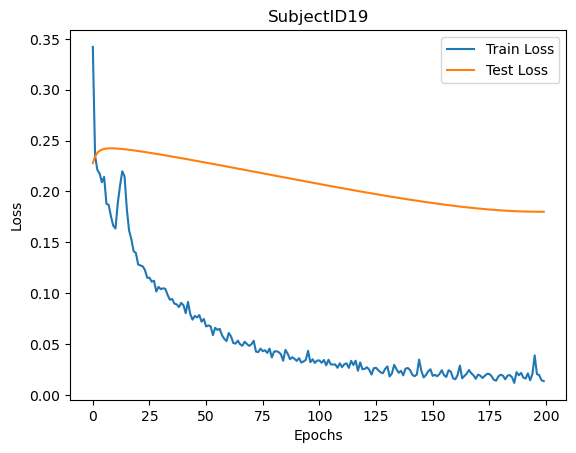

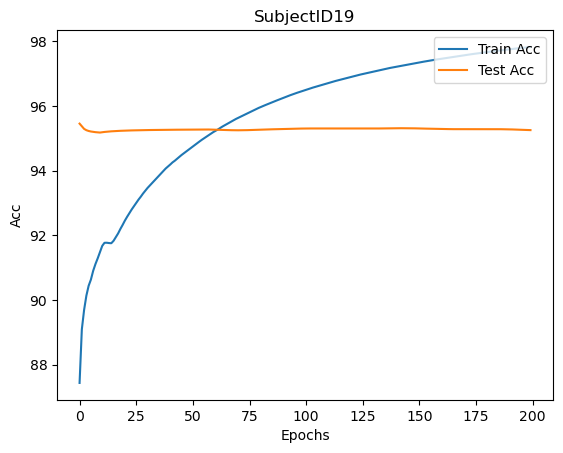

| epoch   0 | 0.0150 s/epoch | train loss 0.6924
| epoch   1 | 0.0144 s/epoch | train loss 0.6776
| epoch   2 | 0.0151 s/epoch | train loss 0.5884
| epoch   3 | 0.0146 s/epoch | train loss 0.4937
| epoch   4 | 0.0147 s/epoch | train loss 0.4552
| epoch   5 | 0.0160 s/epoch | train loss 0.4359
| epoch   6 | 0.0161 s/epoch | train loss 0.4271
| epoch   7 | 0.0155 s/epoch | train loss 0.4196
| epoch   8 | 0.0154 s/epoch | train loss 0.4137
| epoch   9 | 0.0158 s/epoch | train loss 0.4090
| epoch  10 | 0.0141 s/epoch | train loss 0.4032
| epoch  11 | 0.0145 s/epoch | train loss 0.3988
| epoch  12 | 0.0144 s/epoch | train loss 0.3936
| epoch  13 | 0.0153 s/epoch | train loss 0.3902
| epoch  14 | 0.0148 s/epoch | train loss 0.3838
| epoch  15 | 0.0151 s/epoch | train loss 0.3793
| epoch  16 | 0.0147 s/epoch | train loss 0.3769
| epoch  17 | 0.0151 s/epoch | train loss 0.3716
| epoch  18 | 0.0156 s/epoch | train loss 0.3677
| epoch  19 | 0.0150 s/epoch | train loss 0.3617
| epoch  20 | 0.0144

| epoch 168 | 0.0147 s/epoch | train loss 0.3067
| epoch 169 | 0.0154 s/epoch | train loss 0.3061
| epoch 170 | 0.0149 s/epoch | train loss 0.3041
| epoch 171 | 0.0145 s/epoch | train loss 0.3067
| epoch 172 | 0.0153 s/epoch | train loss 0.3069
| epoch 173 | 0.0154 s/epoch | train loss 0.3054
| epoch 174 | 0.0152 s/epoch | train loss 0.3048
| epoch 175 | 0.0149 s/epoch | train loss 0.3054
| epoch 176 | 0.0149 s/epoch | train loss 0.3050
| epoch 177 | 0.0144 s/epoch | train loss 0.3059
| epoch 178 | 0.0148 s/epoch | train loss 0.3058
| epoch 179 | 0.0155 s/epoch | train loss 0.3050
| epoch 180 | 0.0145 s/epoch | train loss 0.3058
| epoch 181 | 0.0151 s/epoch | train loss 0.3070
| epoch 182 | 0.0172 s/epoch | train loss 0.3071
| epoch 183 | 0.0164 s/epoch | train loss 0.3045
| epoch 184 | 0.0156 s/epoch | train loss 0.3067
| epoch 185 | 0.0153 s/epoch | train loss 0.3052
| epoch 186 | 0.0153 s/epoch | train loss 0.3057
| epoch 187 | 0.0157 s/epoch | train loss 0.3048
| epoch 188 | 0.0152

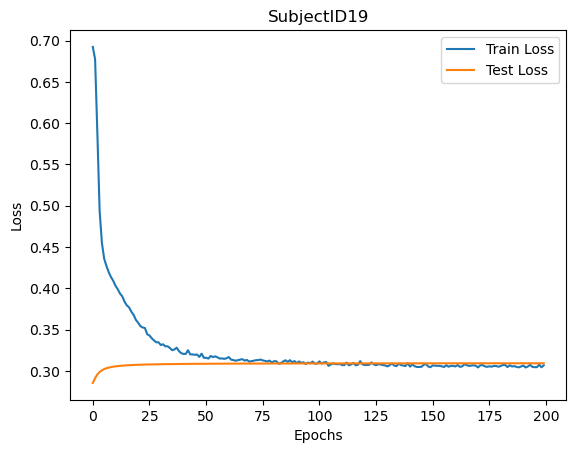

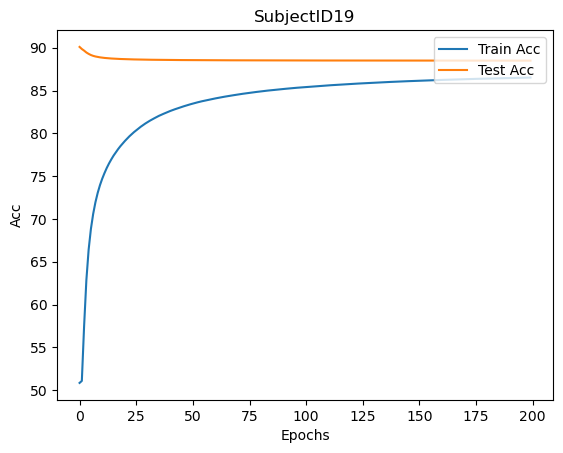


Subject 21
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1704 s/epoch | train loss 0.3207
| epoch   1 | 0.1664 s/epoch | train loss 0.2377
| epoch   2 | 0.1680 s/epoch | train loss 0.2286
| epoch   3 | 0.1690 s/epoch | train loss 0.2136
| epoch   4 | 0.1658 s/epoch | train loss 0.2044
| epoch   5 | 0.1704 s/epoch | train loss 0.2097
| epoch   6 | 0.1688 s/epoch | train loss 0.2279
| epoch   7 | 0.1678 s/epoch | train loss 0.1828
| epoch   8 | 0.1713 s/epoch | train loss 0.1739
| epoch   9 | 0.1698 s/epoch | train loss 0.1595
| epoch  10 | 0.1708 s/epoch | train loss 0.1565
| epoch  11 | 0.1661 s/epoch | train loss 0.1516
| epoch  12 | 0.1681 s/epoch | train loss 0.1404
| epoch  13 | 0.1697 s/epoch | train loss 0.1399
| epoch  14 | 0.1697 s/epoch | train loss 0.1418
| epoch  15 | 0.1678 s/epoch | train loss 0.1282
| epoc

| epoch 163 | 0.1675 s/epoch | train loss 0.0167
| epoch 164 | 0.1686 s/epoch | train loss 0.0181
| epoch 165 | 0.1686 s/epoch | train loss 0.0184
| epoch 166 | 0.1712 s/epoch | train loss 0.0208
| epoch 167 | 0.1688 s/epoch | train loss 0.0164
| epoch 168 | 0.1691 s/epoch | train loss 0.0188
| epoch 169 | 0.1689 s/epoch | train loss 0.0202
| epoch 170 | 0.1699 s/epoch | train loss 0.0185
| epoch 171 | 0.1697 s/epoch | train loss 0.0166
| epoch 172 | 0.1705 s/epoch | train loss 0.0310
| epoch 173 | 0.1696 s/epoch | train loss 0.0154
| epoch 174 | 0.1691 s/epoch | train loss 0.0129
| epoch 175 | 0.1703 s/epoch | train loss 0.0160
| epoch 176 | 0.1691 s/epoch | train loss 0.0163
| epoch 177 | 0.1695 s/epoch | train loss 0.0165
| epoch 178 | 0.1710 s/epoch | train loss 0.0148
| epoch 179 | 0.1726 s/epoch | train loss 0.0162
| epoch 180 | 0.1703 s/epoch | train loss 0.0146
| epoch 181 | 0.1670 s/epoch | train loss 0.0140
| epoch 182 | 0.1714 s/epoch | train loss 0.0190
| epoch 183 | 0.1700

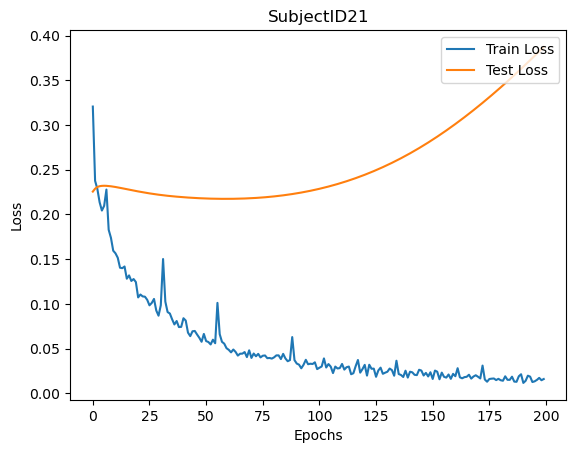

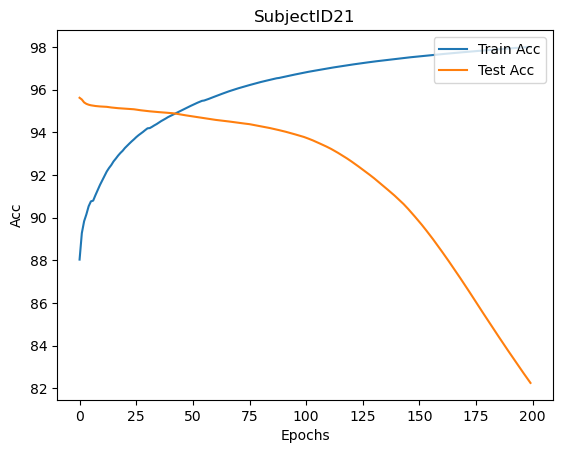

| epoch   0 | 0.0126 s/epoch | train loss 0.6932
| epoch   1 | 0.0128 s/epoch | train loss 0.6928
| epoch   2 | 0.0124 s/epoch | train loss 0.6928
| epoch   3 | 0.0134 s/epoch | train loss 0.6929
| epoch   4 | 0.0123 s/epoch | train loss 0.6929
| epoch   5 | 0.0133 s/epoch | train loss 0.6929
| epoch   6 | 0.0127 s/epoch | train loss 0.6928
| epoch   7 | 0.0127 s/epoch | train loss 0.6929
| epoch   8 | 0.0127 s/epoch | train loss 0.6929
| epoch   9 | 0.0129 s/epoch | train loss 0.6929
| epoch  10 | 0.0123 s/epoch | train loss 0.6928
| epoch  11 | 0.0133 s/epoch | train loss 0.6928
| epoch  12 | 0.0134 s/epoch | train loss 0.6928
| epoch  13 | 0.0139 s/epoch | train loss 0.6929
| epoch  14 | 0.0130 s/epoch | train loss 0.6929
| epoch  15 | 0.0135 s/epoch | train loss 0.6929
| epoch  16 | 0.0139 s/epoch | train loss 0.6929
| epoch  17 | 0.0121 s/epoch | train loss 0.6929
| epoch  18 | 0.0133 s/epoch | train loss 0.6929
| epoch  19 | 0.0130 s/epoch | train loss 0.6929
| epoch  20 | 0.0128

| epoch 168 | 0.0133 s/epoch | train loss 0.6928
| epoch 169 | 0.0133 s/epoch | train loss 0.6928
| epoch 170 | 0.0144 s/epoch | train loss 0.6929
| epoch 171 | 0.0128 s/epoch | train loss 0.6928
| epoch 172 | 0.0122 s/epoch | train loss 0.6928
| epoch 173 | 0.0129 s/epoch | train loss 0.6928
| epoch 174 | 0.0130 s/epoch | train loss 0.6929
| epoch 175 | 0.0132 s/epoch | train loss 0.6929
| epoch 176 | 0.0127 s/epoch | train loss 0.6929
| epoch 177 | 0.0132 s/epoch | train loss 0.6928
| epoch 178 | 0.0128 s/epoch | train loss 0.6929
| epoch 179 | 0.0133 s/epoch | train loss 0.6929
| epoch 180 | 0.0129 s/epoch | train loss 0.6929
| epoch 181 | 0.0125 s/epoch | train loss 0.6929
| epoch 182 | 0.0134 s/epoch | train loss 0.6929
| epoch 183 | 0.0134 s/epoch | train loss 0.6928
| epoch 184 | 0.0132 s/epoch | train loss 0.6928
| epoch 185 | 0.0134 s/epoch | train loss 0.6928
| epoch 186 | 0.0127 s/epoch | train loss 0.6929
| epoch 187 | 0.0129 s/epoch | train loss 0.6928
| epoch 188 | 0.0121

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


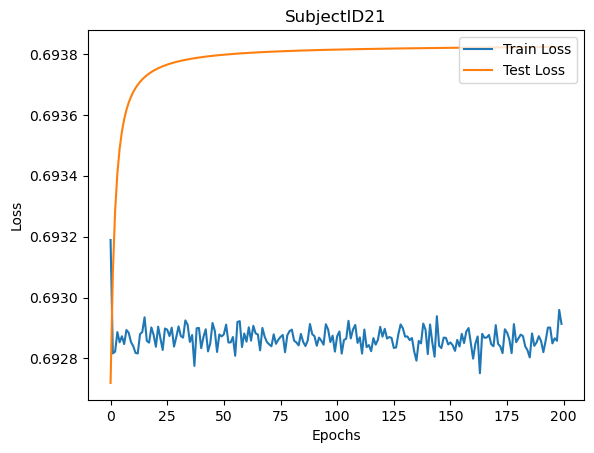

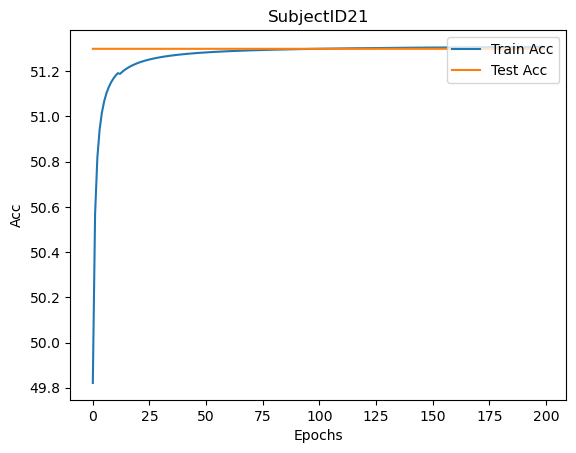


Subject 22
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1413 s/epoch | train loss 0.3155
| epoch   1 | 0.1397 s/epoch | train loss 0.2418
| epoch   2 | 0.1389 s/epoch | train loss 0.2261
| epoch   3 | 0.1394 s/epoch | train loss 0.2146
| epoch   4 | 0.1390 s/epoch | train loss 0.1973
| epoch   5 | 0.1390 s/epoch | train loss 0.1904
| epoch   6 | 0.1395 s/epoch | train loss 0.1816
| epoch   7 | 0.1393 s/epoch | train loss 0.1687
| epoch   8 | 0.1386 s/epoch | train loss 0.1635
| epoch   9 | 0.1392 s/epoch | train loss 0.1594
| epoch  10 | 0.1405 s/epoch | train loss 0.2197
| epoch  11 | 0.1401 s/epoch | train loss 0.2226
| epoch  12 | 0.1394 s/epoch | train loss 0.1930
| epoch  13 | 0.1387 s/epoch | train loss 0.1638
| epoch  14 | 0.1403 s/epoch | train loss 0.1582
| epoch  15 | 0.1380 s/epoch | train loss 0.1545
| epoc

| epoch 163 | 0.1394 s/epoch | train loss 0.0209
| epoch 164 | 0.1387 s/epoch | train loss 0.0139
| epoch 165 | 0.1396 s/epoch | train loss 0.0254
| epoch 166 | 0.1414 s/epoch | train loss 0.0187
| epoch 167 | 0.1390 s/epoch | train loss 0.0199
| epoch 168 | 0.1382 s/epoch | train loss 0.0152
| epoch 169 | 0.1403 s/epoch | train loss 0.0195
| epoch 170 | 0.1403 s/epoch | train loss 0.0172
| epoch 171 | 0.1416 s/epoch | train loss 0.0176
| epoch 172 | 0.1386 s/epoch | train loss 0.0188
| epoch 173 | 0.1376 s/epoch | train loss 0.0160
| epoch 174 | 0.1388 s/epoch | train loss 0.0153
| epoch 175 | 0.1404 s/epoch | train loss 0.0171
| epoch 176 | 0.1400 s/epoch | train loss 0.0209
| epoch 177 | 0.1388 s/epoch | train loss 0.0199
| epoch 178 | 0.1386 s/epoch | train loss 0.0149
| epoch 179 | 0.1384 s/epoch | train loss 0.0145
| epoch 180 | 0.1391 s/epoch | train loss 0.0166
| epoch 181 | 0.1363 s/epoch | train loss 0.0191
| epoch 182 | 0.1386 s/epoch | train loss 0.0143
| epoch 183 | 0.1383

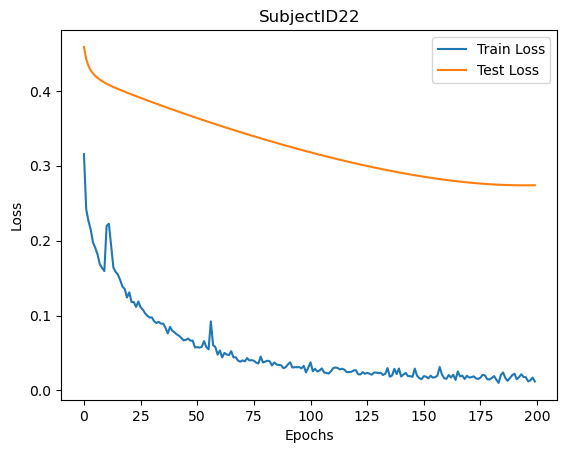

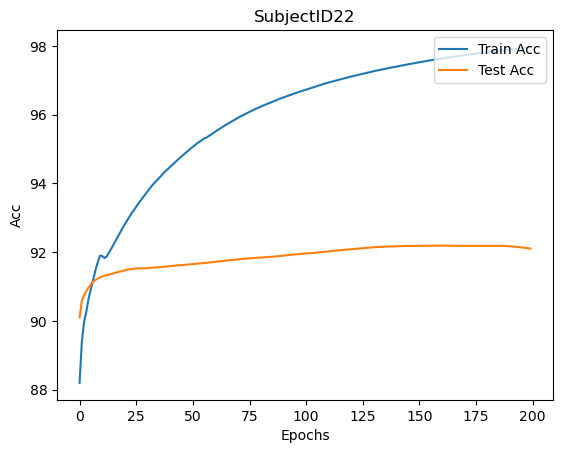

| epoch   0 | 0.0128 s/epoch | train loss 0.6872
| epoch   1 | 0.0133 s/epoch | train loss 0.5648
| epoch   2 | 0.0129 s/epoch | train loss 0.4809
| epoch   3 | 0.0131 s/epoch | train loss 0.4585
| epoch   4 | 0.0124 s/epoch | train loss 0.4480
| epoch   5 | 0.0127 s/epoch | train loss 0.4408
| epoch   6 | 0.0132 s/epoch | train loss 0.4350
| epoch   7 | 0.0125 s/epoch | train loss 0.4307
| epoch   8 | 0.0132 s/epoch | train loss 0.4271
| epoch   9 | 0.0127 s/epoch | train loss 0.4236
| epoch  10 | 0.0128 s/epoch | train loss 0.4211
| epoch  11 | 0.0124 s/epoch | train loss 0.4181
| epoch  12 | 0.0126 s/epoch | train loss 0.4143
| epoch  13 | 0.0127 s/epoch | train loss 0.4122
| epoch  14 | 0.0129 s/epoch | train loss 0.4090
| epoch  15 | 0.0124 s/epoch | train loss 0.4063
| epoch  16 | 0.0132 s/epoch | train loss 0.4037
| epoch  17 | 0.0131 s/epoch | train loss 0.4005
| epoch  18 | 0.0127 s/epoch | train loss 0.3984
| epoch  19 | 0.0137 s/epoch | train loss 0.3966
| epoch  20 | 0.0127

| epoch 168 | 0.0128 s/epoch | train loss 0.3409
| epoch 169 | 0.0128 s/epoch | train loss 0.3408
| epoch 170 | 0.0130 s/epoch | train loss 0.3404
| epoch 171 | 0.0121 s/epoch | train loss 0.3396
| epoch 172 | 0.0125 s/epoch | train loss 0.3409
| epoch 173 | 0.0128 s/epoch | train loss 0.3405
| epoch 174 | 0.0127 s/epoch | train loss 0.3401
| epoch 175 | 0.0127 s/epoch | train loss 0.3396
| epoch 176 | 0.0125 s/epoch | train loss 0.3395
| epoch 177 | 0.0125 s/epoch | train loss 0.3387
| epoch 178 | 0.0127 s/epoch | train loss 0.3391
| epoch 179 | 0.0127 s/epoch | train loss 0.3391
| epoch 180 | 0.0125 s/epoch | train loss 0.3385
| epoch 181 | 0.0125 s/epoch | train loss 0.3394
| epoch 182 | 0.0126 s/epoch | train loss 0.3384
| epoch 183 | 0.0128 s/epoch | train loss 0.3386
| epoch 184 | 0.0132 s/epoch | train loss 0.3383
| epoch 185 | 0.0126 s/epoch | train loss 0.3396
| epoch 186 | 0.0130 s/epoch | train loss 0.3384
| epoch 187 | 0.0122 s/epoch | train loss 0.3391
| epoch 188 | 0.0138

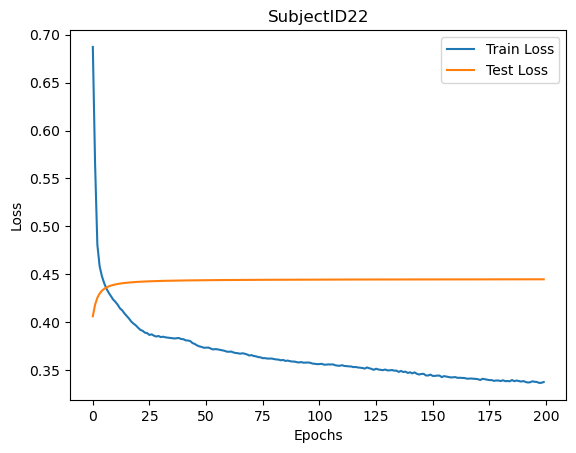

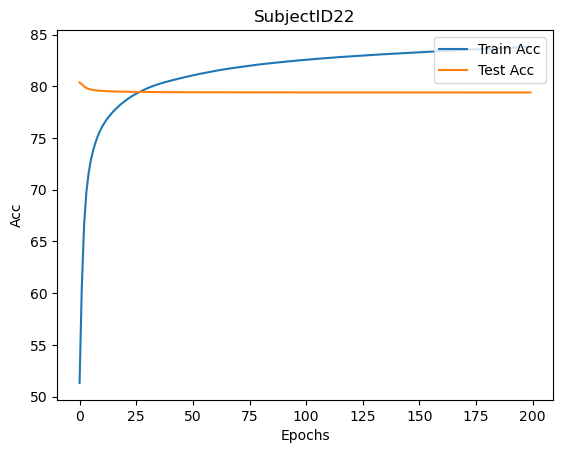


Subject 23
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.1397 s/epoch | train loss 0.3107
| epoch   1 | 0.1393 s/epoch | train loss 0.2401
| epoch   2 | 0.1372 s/epoch | train loss 0.2213
| epoch   3 | 0.1390 s/epoch | train loss 0.2118
| epoch   4 | 0.1396 s/epoch | train loss 0.1988
| epoch   5 | 0.1379 s/epoch | train loss 0.1937
| epoch   6 | 0.1383 s/epoch | train loss 0.1883
| epoch   7 | 0.1395 s/epoch | train loss 0.1772
| epoch   8 | 0.1380 s/epoch | train loss 0.1694
| epoch   9 | 0.1393 s/epoch | train loss 0.1564
| epoch  10 | 0.1385 s/epoch | train loss 0.1567
| epoch  11 | 0.1362 s/epoch | train loss 0.1424
| epoch  12 | 0.1379 s/epoch | train loss 0.1533
| epoch  13 | 0.1386 s/epoch | train loss 0.1404
| epoch  14 | 0.1395 s/epoch | train loss 0.1352
| epoch  15 | 0.1394 s/epoch | train loss 0.1238
| epoc

| epoch 163 | 0.1410 s/epoch | train loss 0.0144
| epoch 164 | 0.1406 s/epoch | train loss 0.0212
| epoch 165 | 0.1427 s/epoch | train loss 0.0165
| epoch 166 | 0.1377 s/epoch | train loss 0.0161
| epoch 167 | 0.1411 s/epoch | train loss 0.0214
| epoch 168 | 0.1416 s/epoch | train loss 0.0173
| epoch 169 | 0.1411 s/epoch | train loss 0.0131
| epoch 170 | 0.1426 s/epoch | train loss 0.0179
| epoch 171 | 0.1402 s/epoch | train loss 0.0231
| epoch 172 | 0.1420 s/epoch | train loss 0.0143
| epoch 173 | 0.1141 s/epoch | train loss 0.0152
| epoch 174 | 0.1123 s/epoch | train loss 0.0238
| epoch 175 | 0.1132 s/epoch | train loss 0.0155
| epoch 176 | 0.1116 s/epoch | train loss 0.0169
| epoch 177 | 0.1117 s/epoch | train loss 0.0139
| epoch 178 | 0.1122 s/epoch | train loss 0.0101
| epoch 179 | 0.1121 s/epoch | train loss 0.0189
| epoch 180 | 0.1135 s/epoch | train loss 0.0137
| epoch 181 | 0.1123 s/epoch | train loss 0.0129
| epoch 182 | 0.1122 s/epoch | train loss 0.0134
| epoch 183 | 0.1120

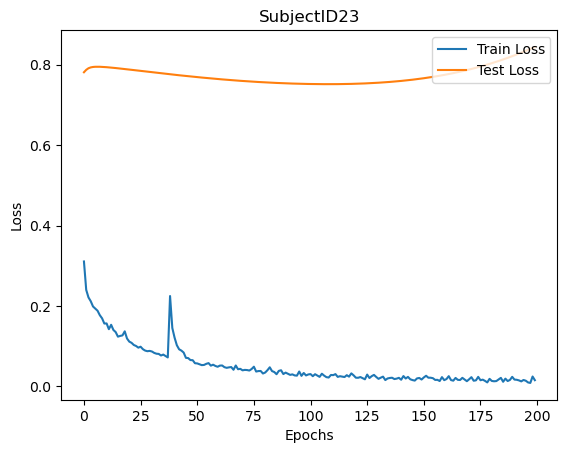

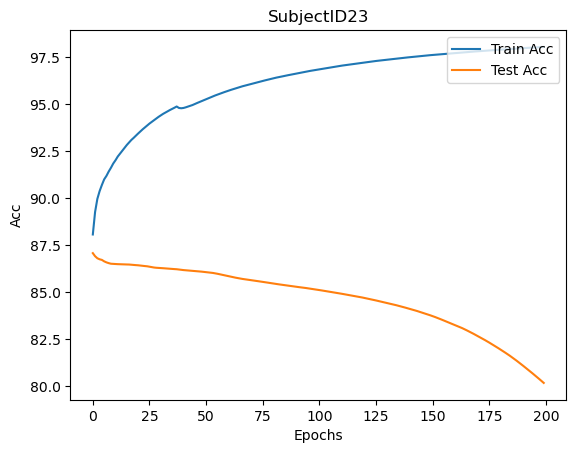

| epoch   0 | 0.0107 s/epoch | train loss 0.7465
| epoch   1 | 0.0115 s/epoch | train loss 0.6111
| epoch   2 | 0.0110 s/epoch | train loss 0.4918
| epoch   3 | 0.0118 s/epoch | train loss 0.4555
| epoch   4 | 0.0116 s/epoch | train loss 0.4459
| epoch   5 | 0.0111 s/epoch | train loss 0.4412
| epoch   6 | 0.0112 s/epoch | train loss 0.4383
| epoch   7 | 0.0109 s/epoch | train loss 0.4359
| epoch   8 | 0.0110 s/epoch | train loss 0.4339
| epoch   9 | 0.0110 s/epoch | train loss 0.4309
| epoch  10 | 0.0108 s/epoch | train loss 0.4280
| epoch  11 | 0.0107 s/epoch | train loss 0.4238
| epoch  12 | 0.0113 s/epoch | train loss 0.4161
| epoch  13 | 0.0114 s/epoch | train loss 0.4095
| epoch  14 | 0.0111 s/epoch | train loss 0.4064
| epoch  15 | 0.0113 s/epoch | train loss 0.4042
| epoch  16 | 0.0105 s/epoch | train loss 0.4017
| epoch  17 | 0.0120 s/epoch | train loss 0.4009
| epoch  18 | 0.0112 s/epoch | train loss 0.3994
| epoch  19 | 0.0107 s/epoch | train loss 0.3981
| epoch  20 | 0.0113

| epoch 168 | 0.0112 s/epoch | train loss 0.3405
| epoch 169 | 0.0101 s/epoch | train loss 0.3408
| epoch 170 | 0.0114 s/epoch | train loss 0.3408
| epoch 171 | 0.0106 s/epoch | train loss 0.3398
| epoch 172 | 0.0113 s/epoch | train loss 0.3404
| epoch 173 | 0.0104 s/epoch | train loss 0.3403
| epoch 174 | 0.0110 s/epoch | train loss 0.3402
| epoch 175 | 0.0113 s/epoch | train loss 0.3401
| epoch 176 | 0.0124 s/epoch | train loss 0.3395
| epoch 177 | 0.0106 s/epoch | train loss 0.3412
| epoch 178 | 0.0111 s/epoch | train loss 0.3398
| epoch 179 | 0.0111 s/epoch | train loss 0.3395
| epoch 180 | 0.0113 s/epoch | train loss 0.3402
| epoch 181 | 0.0104 s/epoch | train loss 0.3391
| epoch 182 | 0.0105 s/epoch | train loss 0.3389
| epoch 183 | 0.0113 s/epoch | train loss 0.3397
| epoch 184 | 0.0102 s/epoch | train loss 0.3385
| epoch 185 | 0.0119 s/epoch | train loss 0.3388
| epoch 186 | 0.0103 s/epoch | train loss 0.3396
| epoch 187 | 0.0115 s/epoch | train loss 0.3385
| epoch 188 | 0.0111

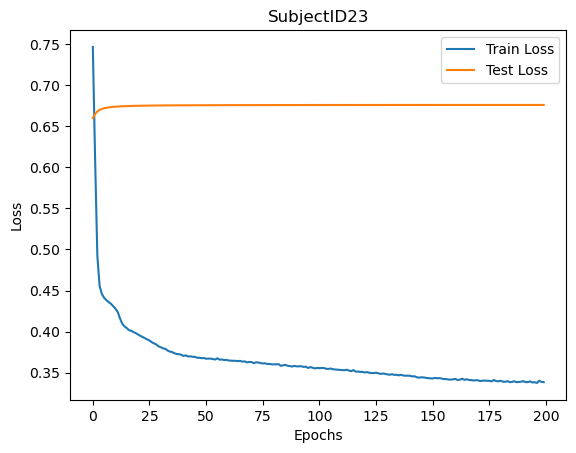

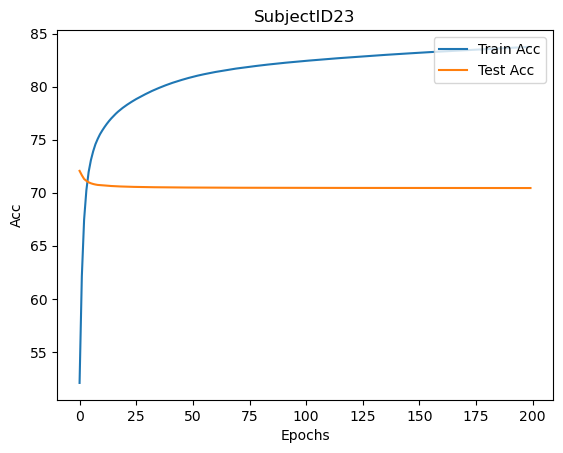

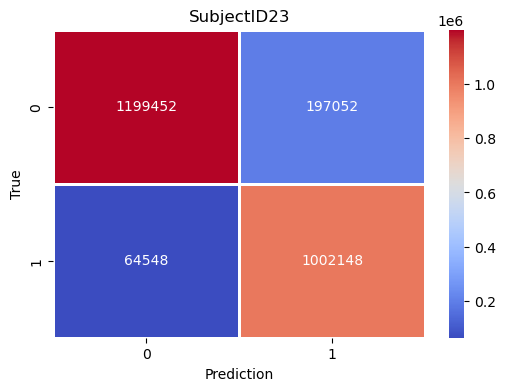

<Figure size 640x480 with 0 Axes>

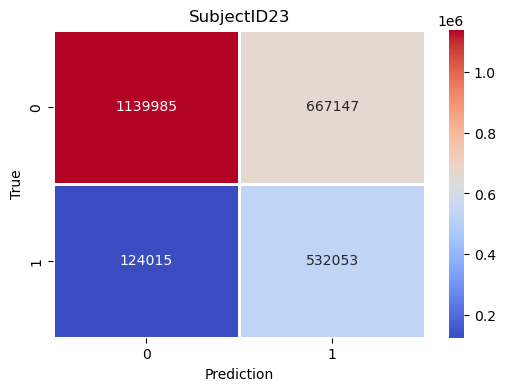

Teacher1(RestNet50)_Acc: 0.8937966872361156
Teacher1(RestNet50)_Rec: 0.9394879140823628
Teacher1(RestNet50)_Pre: 0.8356804536357572
Teacher1(RestNet50)_F1: 0.88454898194798
Original_Student1(CNN_Small)_Acc: 0.6788072426112374
Original_Student1(CNN_Small)_Rec: 0.8109723382332319
Original_Student1(CNN_Small)_Pre: 0.4436732821881254
Original_Student1(CNN_Small)_F1: 0.5735591839022718


<Figure size 640x480 with 0 Axes>

In [16]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,21,22,23]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            if len(norm_sliding_waist_data[i]) > 0:
                e1 = np.max(norm_sliding_waist_data[i])
                max_norm_value.append(e1)
                e2 = np.argmax(norm_sliding_waist_data[i])
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
            else:
                e1 = 0
                max_norm_value.append(e1)
                e2 = 0
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
                

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [2, 2, 2, 2], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    model_student = Net_Student(config).to(device) 
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher1(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher1(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher1(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher1(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student1(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student1(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student1(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student1(CNN_Small)_F1:",Student_eval_table[3]) 


Subject 1
| epoch   0 | 0.1913 s/epoch | train loss 0.7191
| epoch   1 | 0.1853 s/epoch | train loss 0.5312
| epoch   2 | 0.1853 s/epoch | train loss 0.5050
| epoch   3 | 0.1833 s/epoch | train loss 0.4686
| epoch   4 | 0.1843 s/epoch | train loss 0.4597
| epoch   5 | 0.1830 s/epoch | train loss 0.4427
| epoch   6 | 0.1852 s/epoch | train loss 0.4415
| epoch   7 | 0.1836 s/epoch | train loss 0.4265
| epoch   8 | 0.1834 s/epoch | train loss 0.4227
| epoch   9 | 0.1830 s/epoch | train loss 0.4169
| epoch  10 | 0.1857 s/epoch | train loss 0.4088
| epoch  11 | 0.1838 s/epoch | train loss 0.4095
| epoch  12 | 0.1830 s/epoch | train loss 0.4017
| epoch  13 | 0.1837 s/epoch | train loss 0.3970
| epoch  14 | 0.1842 s/epoch | train loss 0.3979
| epoch  15 | 0.1828 s/epoch | train loss 0.3970
| epoch  16 | 0.1826 s/epoch | train loss 0.3805
| epoch  17 | 0.1855 s/epoch | train loss 0.3796
| epoch  18 | 0.1847 s/epoch | train loss 0.3827
| epoch  19 | 0.1841 s/epoch | train loss 0.3739
| epoch  

| epoch 167 | 0.1805 s/epoch | train loss 0.2812
| epoch 168 | 0.1813 s/epoch | train loss 0.2756
| epoch 169 | 0.1827 s/epoch | train loss 0.2674
| epoch 170 | 0.1820 s/epoch | train loss 0.2742
| epoch 171 | 0.1800 s/epoch | train loss 0.2687
| epoch 172 | 0.1816 s/epoch | train loss 0.2689
| epoch 173 | 0.1806 s/epoch | train loss 0.2644
| epoch 174 | 0.1811 s/epoch | train loss 0.2850
| epoch 175 | 0.1807 s/epoch | train loss 0.2998
| epoch 176 | 0.1803 s/epoch | train loss 0.2804
| epoch 177 | 0.1796 s/epoch | train loss 0.2829
| epoch 178 | 0.1790 s/epoch | train loss 0.2730
| epoch 179 | 0.1808 s/epoch | train loss 0.2657
| epoch 180 | 0.1799 s/epoch | train loss 0.2669
| epoch 181 | 0.1802 s/epoch | train loss 0.3320
| epoch 182 | 0.1832 s/epoch | train loss 0.2872
| epoch 183 | 0.1824 s/epoch | train loss 0.2779
| epoch 184 | 0.1811 s/epoch | train loss 0.2723
| epoch 185 | 0.1828 s/epoch | train loss 0.2750
| epoch 186 | 0.1824 s/epoch | train loss 0.2651
| epoch 187 | 0.1806

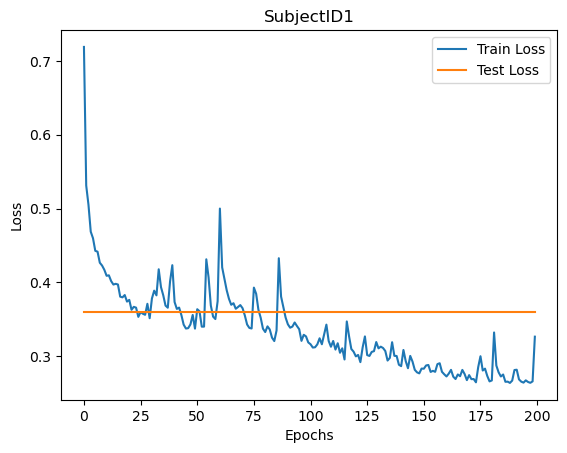

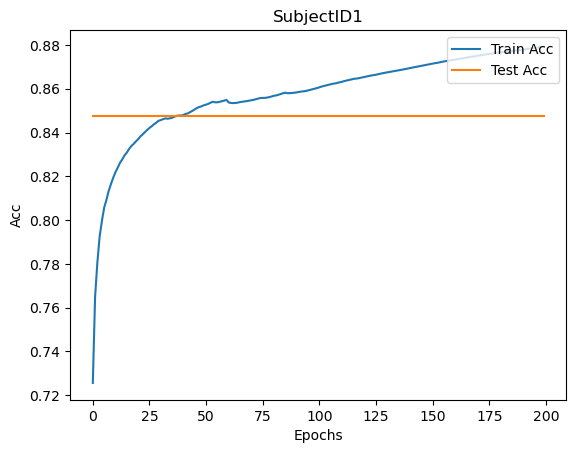

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~

Subject 2
| epoch   0 | 0.1814 s/epoch | train loss 0.7446
| epoch   1 | 0.1808 s/epoch | train loss 0.5329
| epoch   2 | 0.1798 s/epoch | train loss 0.4820
| epoch   3 | 0.1802 s/epoch | train loss 0.4655
| epoch   4 | 0.1833 s/epoch | train loss 0.4475
| epoch   5 | 0.1813 s/epoch | train loss 0.4354
| epoch   6 | 0.1797 s/epoch | train loss 0.4346
| epoch   7 | 0.1849 s/epoch | train loss 0.4186
| epoch   8 | 0.1793 s/epoch | train loss 0.4080
| epoch   9 | 0.1828 s/epoch | train loss 0.4134
| epoch  10 | 0.1818 s/epoch | train loss 0.4072
| epoch  11 | 0.1786 s/epoch | train loss 0.4129
| epoch  12 | 0.1810 s/epoch | train loss 0.4057
| epoch  13 | 0.1798 s/epoch | train loss 0.3906
| epoch  14 | 0.1801 s/epoch | train loss 0.3836
| 

| epoch 162 | 0.1791 s/epoch | train loss 0.3064
| epoch 163 | 0.1819 s/epoch | train loss 0.3006
| epoch 164 | 0.1809 s/epoch | train loss 0.3071
| epoch 165 | 0.1805 s/epoch | train loss 0.3486
| epoch 166 | 0.1779 s/epoch | train loss 0.3956
| epoch 167 | 0.1798 s/epoch | train loss 0.3621
| epoch 168 | 0.1775 s/epoch | train loss 0.3663
| epoch 169 | 0.1753 s/epoch | train loss 0.3442
| epoch 170 | 0.1807 s/epoch | train loss 0.3390
| epoch 171 | 0.1789 s/epoch | train loss 0.3407
| epoch 172 | 0.1831 s/epoch | train loss 0.3418
| epoch 173 | 0.1821 s/epoch | train loss 0.3557
| epoch 174 | 0.1807 s/epoch | train loss 0.3641
| epoch 175 | 0.1809 s/epoch | train loss 0.3474
| epoch 176 | 0.1802 s/epoch | train loss 0.3512
| epoch 177 | 0.1788 s/epoch | train loss 0.3296
| epoch 178 | 0.1813 s/epoch | train loss 0.3260
| epoch 179 | 0.1788 s/epoch | train loss 0.3194
| epoch 180 | 0.1784 s/epoch | train loss 0.3112
| epoch 181 | 0.1795 s/epoch | train loss 0.3141
| epoch 182 | 0.1809

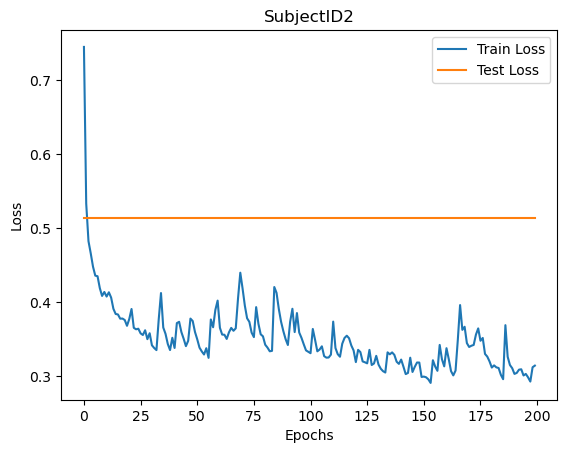

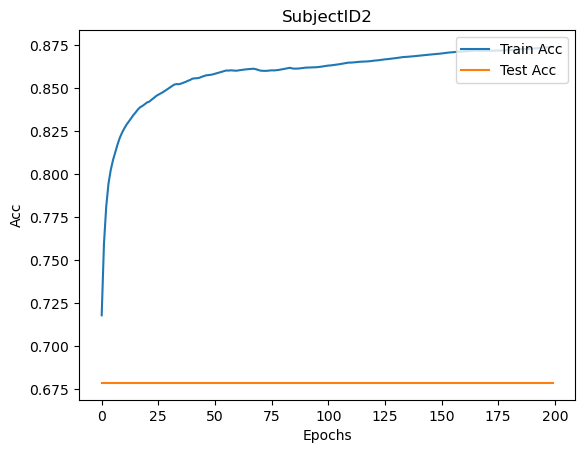


Subject 3
| epoch   0 | 0.1815 s/epoch | train loss 0.7260
| epoch   1 | 0.1775 s/epoch | train loss 0.5183
| epoch   2 | 0.1785 s/epoch | train loss 0.4859
| epoch   3 | 0.1810 s/epoch | train loss 0.4554
| epoch   4 | 0.1801 s/epoch | train loss 0.4485
| epoch   5 | 0.1789 s/epoch | train loss 0.4328
| epoch   6 | 0.1771 s/epoch | train loss 0.4212
| epoch   7 | 0.1784 s/epoch | train loss 0.4161
| epoch   8 | 0.1809 s/epoch | train loss 0.4168
| epoch   9 | 0.1792 s/epoch | train loss 0.4157
| epoch  10 | 0.1788 s/epoch | train loss 0.4049
| epoch  11 | 0.1789 s/epoch | train loss 0.4014
| epoch  12 | 0.1806 s/epoch | train loss 0.4012
| epoch  13 | 0.1796 s/epoch | train loss 0.3868
| epoch  14 | 0.1794 s/epoch | train loss 0.3816
| epoch  15 | 0.1785 s/epoch | train loss 0.3866
| epoch  16 | 0.1796 s/epoch | train loss 0.3808
| epoch  17 | 0.1787 s/epoch | train loss 0.3745
| epoch  18 | 0.1806 s/epoch | train loss 0.3782
| epoch  19 | 0.1794 s/epoch | train loss 0.3616
| epoch  

| epoch 167 | 0.1744 s/epoch | train loss 0.2808
| epoch 168 | 0.1790 s/epoch | train loss 0.2748
| epoch 169 | 0.1765 s/epoch | train loss 0.2849
| epoch 170 | 0.1786 s/epoch | train loss 0.2752
| epoch 171 | 0.1766 s/epoch | train loss 0.2705
| epoch 172 | 0.1798 s/epoch | train loss 0.2735
| epoch 173 | 0.1763 s/epoch | train loss 0.2703
| epoch 174 | 0.1764 s/epoch | train loss 0.2701
| epoch 175 | 0.1767 s/epoch | train loss 0.2677
| epoch 176 | 0.1769 s/epoch | train loss 0.2807
| epoch 177 | 0.1764 s/epoch | train loss 0.2717
| epoch 178 | 0.1777 s/epoch | train loss 0.2695
| epoch 179 | 0.1763 s/epoch | train loss 0.3225
| epoch 180 | 0.1744 s/epoch | train loss 0.2788
| epoch 181 | 0.1780 s/epoch | train loss 0.2753
| epoch 182 | 0.1775 s/epoch | train loss 0.2682
| epoch 183 | 0.1779 s/epoch | train loss 0.2677
| epoch 184 | 0.1772 s/epoch | train loss 0.2701
| epoch 185 | 0.1789 s/epoch | train loss 0.2727
| epoch 186 | 0.1770 s/epoch | train loss 0.3126
| epoch 187 | 0.1763

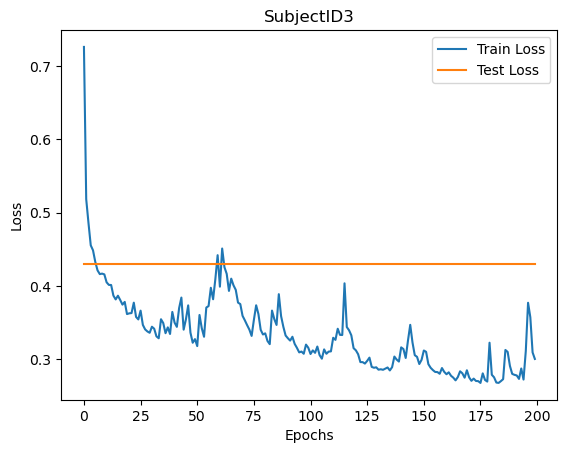

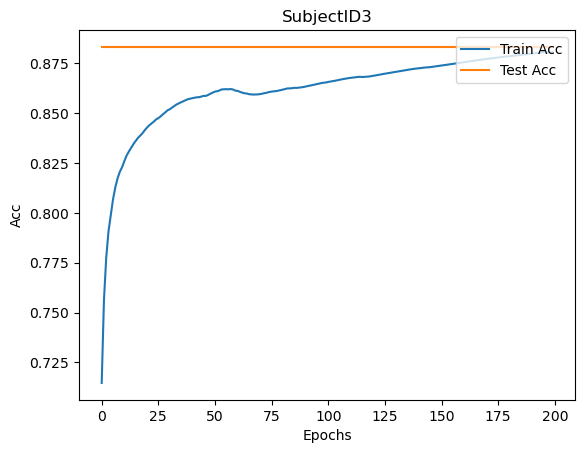


Subject 4
| epoch   0 | 0.1791 s/epoch | train loss 0.7374
| epoch   1 | 0.1806 s/epoch | train loss 0.5220
| epoch   2 | 0.1818 s/epoch | train loss 0.4834
| epoch   3 | 0.1788 s/epoch | train loss 0.4687
| epoch   4 | 0.1797 s/epoch | train loss 0.4693
| epoch   5 | 0.1784 s/epoch | train loss 0.4384
| epoch   6 | 0.1815 s/epoch | train loss 0.4381
| epoch   7 | 0.1773 s/epoch | train loss 0.4340
| epoch   8 | 0.1767 s/epoch | train loss 0.4295
| epoch   9 | 0.1789 s/epoch | train loss 0.4177
| epoch  10 | 0.1798 s/epoch | train loss 0.4125
| epoch  11 | 0.1792 s/epoch | train loss 0.4169
| epoch  12 | 0.1792 s/epoch | train loss 0.4044
| epoch  13 | 0.1774 s/epoch | train loss 0.4112
| epoch  14 | 0.1783 s/epoch | train loss 0.4177
| epoch  15 | 0.1801 s/epoch | train loss 0.4072
| epoch  16 | 0.1815 s/epoch | train loss 0.3880
| epoch  17 | 0.1815 s/epoch | train loss 0.3810
| epoch  18 | 0.1796 s/epoch | train loss 0.3797
| epoch  19 | 0.1819 s/epoch | train loss 0.3785
| epoch  

| epoch 167 | 0.1797 s/epoch | train loss 0.2968
| epoch 168 | 0.1796 s/epoch | train loss 0.3294
| epoch 169 | 0.1791 s/epoch | train loss 0.3687
| epoch 170 | 0.1785 s/epoch | train loss 0.3720
| epoch 171 | 0.1807 s/epoch | train loss 0.3305
| epoch 172 | 0.1774 s/epoch | train loss 0.3214
| epoch 173 | 0.1792 s/epoch | train loss 0.3110
| epoch 174 | 0.1800 s/epoch | train loss 0.3062
| epoch 175 | 0.1789 s/epoch | train loss 0.2976
| epoch 176 | 0.1801 s/epoch | train loss 0.2975
| epoch 177 | 0.1800 s/epoch | train loss 0.3097
| epoch 178 | 0.1812 s/epoch | train loss 0.3488
| epoch 179 | 0.1779 s/epoch | train loss 0.3397
| epoch 180 | 0.1807 s/epoch | train loss 0.3573
| epoch 181 | 0.1804 s/epoch | train loss 0.3931
| epoch 182 | 0.1811 s/epoch | train loss 0.3689
| epoch 183 | 0.1795 s/epoch | train loss 0.3810
| epoch 184 | 0.1785 s/epoch | train loss 0.3525
| epoch 185 | 0.1802 s/epoch | train loss 0.3389
| epoch 186 | 0.1797 s/epoch | train loss 0.3285
| epoch 187 | 0.1815

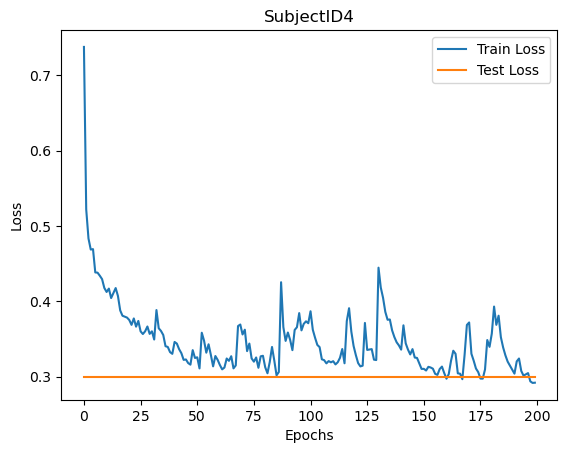

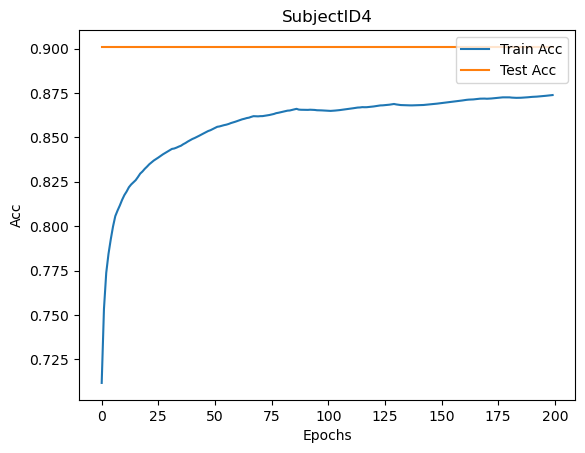


Subject 5
| epoch   0 | 0.1800 s/epoch | train loss 0.6755
| epoch   1 | 0.1786 s/epoch | train loss 0.5142
| epoch   2 | 0.1787 s/epoch | train loss 0.4699
| epoch   3 | 0.1783 s/epoch | train loss 0.4575
| epoch   4 | 0.1785 s/epoch | train loss 0.4447
| epoch   5 | 0.1773 s/epoch | train loss 0.4466
| epoch   6 | 0.1823 s/epoch | train loss 0.4655
| epoch   7 | 0.1816 s/epoch | train loss 0.4574
| epoch   8 | 0.1796 s/epoch | train loss 0.4340
| epoch   9 | 0.1801 s/epoch | train loss 0.4186
| epoch  10 | 0.1770 s/epoch | train loss 0.4130
| epoch  11 | 0.1772 s/epoch | train loss 0.4104
| epoch  12 | 0.1760 s/epoch | train loss 0.4199
| epoch  13 | 0.1781 s/epoch | train loss 0.4026
| epoch  14 | 0.1768 s/epoch | train loss 0.3923
| epoch  15 | 0.1747 s/epoch | train loss 0.4012
| epoch  16 | 0.1743 s/epoch | train loss 0.4083
| epoch  17 | 0.1790 s/epoch | train loss 0.3858
| epoch  18 | 0.1774 s/epoch | train loss 0.3931
| epoch  19 | 0.1747 s/epoch | train loss 0.3787
| epoch  

| epoch 167 | 0.1416 s/epoch | train loss 0.4115
| epoch 168 | 0.1406 s/epoch | train loss 0.3925
| epoch 169 | 0.1401 s/epoch | train loss 0.3848
| epoch 170 | 0.1396 s/epoch | train loss 0.3786
| epoch 171 | 0.1413 s/epoch | train loss 0.3668
| epoch 172 | 0.1421 s/epoch | train loss 0.3653
| epoch 173 | 0.1410 s/epoch | train loss 0.3555
| epoch 174 | 0.1426 s/epoch | train loss 0.3507
| epoch 175 | 0.1397 s/epoch | train loss 0.3460
| epoch 176 | 0.1425 s/epoch | train loss 0.3369
| epoch 177 | 0.1412 s/epoch | train loss 0.3422
| epoch 178 | 0.1422 s/epoch | train loss 0.3362
| epoch 179 | 0.1422 s/epoch | train loss 0.3379
| epoch 180 | 0.1410 s/epoch | train loss 0.3359
| epoch 181 | 0.1419 s/epoch | train loss 0.3269
| epoch 182 | 0.1414 s/epoch | train loss 0.3253
| epoch 183 | 0.1428 s/epoch | train loss 0.3311
| epoch 184 | 0.1426 s/epoch | train loss 0.3258
| epoch 185 | 0.1416 s/epoch | train loss 0.3166
| epoch 186 | 0.1416 s/epoch | train loss 0.3138
| epoch 187 | 0.1410

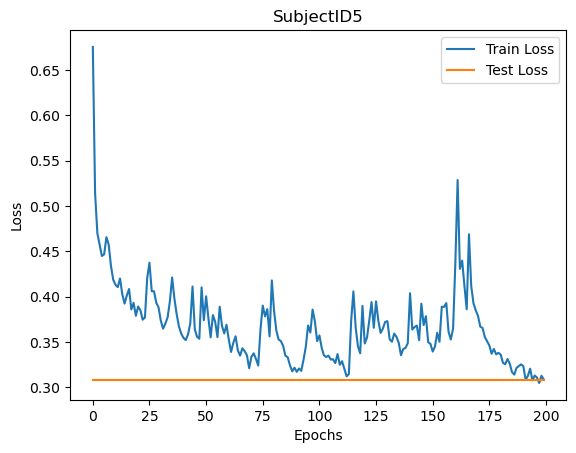

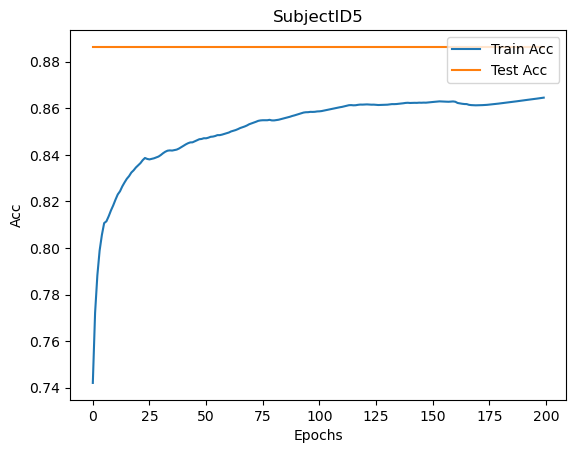


Subject 7
| epoch   0 | 0.1417 s/epoch | train loss 0.7811
| epoch   1 | 0.1395 s/epoch | train loss 0.5415
| epoch   2 | 0.1421 s/epoch | train loss 0.4894
| epoch   3 | 0.1385 s/epoch | train loss 0.4586
| epoch   4 | 0.1410 s/epoch | train loss 0.4506
| epoch   5 | 0.1409 s/epoch | train loss 0.4371
| epoch   6 | 0.1438 s/epoch | train loss 0.4219
| epoch   7 | 0.1425 s/epoch | train loss 0.4265
| epoch   8 | 0.1412 s/epoch | train loss 0.4300
| epoch   9 | 0.1432 s/epoch | train loss 0.4053
| epoch  10 | 0.1411 s/epoch | train loss 0.4030
| epoch  11 | 0.1437 s/epoch | train loss 0.3867
| epoch  12 | 0.1421 s/epoch | train loss 0.4076
| epoch  13 | 0.1413 s/epoch | train loss 0.3920
| epoch  14 | 0.1414 s/epoch | train loss 0.3862
| epoch  15 | 0.1409 s/epoch | train loss 0.3898
| epoch  16 | 0.1416 s/epoch | train loss 0.3844
| epoch  17 | 0.1415 s/epoch | train loss 0.3764
| epoch  18 | 0.1400 s/epoch | train loss 0.3729
| epoch  19 | 0.1407 s/epoch | train loss 0.3756
| epoch  

| epoch 167 | 0.1366 s/epoch | train loss 0.2916
| epoch 168 | 0.1367 s/epoch | train loss 0.2922
| epoch 169 | 0.1371 s/epoch | train loss 0.3021
| epoch 170 | 0.1361 s/epoch | train loss 0.3684
| epoch 171 | 0.1379 s/epoch | train loss 0.3185
| epoch 172 | 0.1376 s/epoch | train loss 0.3128
| epoch 173 | 0.1378 s/epoch | train loss 0.3013
| epoch 174 | 0.1361 s/epoch | train loss 0.2929
| epoch 175 | 0.1384 s/epoch | train loss 0.3492
| epoch 176 | 0.1366 s/epoch | train loss 0.3149
| epoch 177 | 0.1365 s/epoch | train loss 0.3010
| epoch 178 | 0.1367 s/epoch | train loss 0.3170
| epoch 179 | 0.1382 s/epoch | train loss 0.3253
| epoch 180 | 0.1361 s/epoch | train loss 0.3062
| epoch 181 | 0.1345 s/epoch | train loss 0.2977
| epoch 182 | 0.1381 s/epoch | train loss 0.3078
| epoch 183 | 0.1357 s/epoch | train loss 0.3127
| epoch 184 | 0.1374 s/epoch | train loss 0.3116
| epoch 185 | 0.1382 s/epoch | train loss 0.3028
| epoch 186 | 0.1359 s/epoch | train loss 0.2943
| epoch 187 | 0.1366

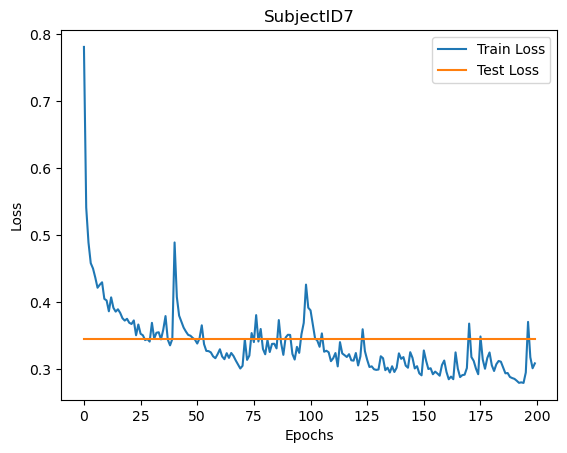

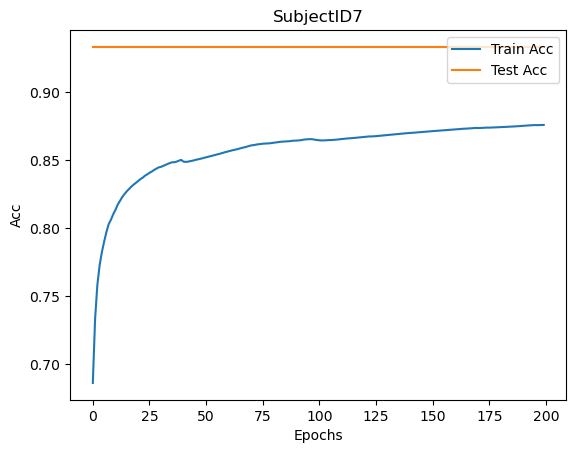


Subject 8
| epoch   0 | 0.1370 s/epoch | train loss 0.7080
| epoch   1 | 0.1357 s/epoch | train loss 0.5157
| epoch   2 | 0.1366 s/epoch | train loss 0.4709
| epoch   3 | 0.1360 s/epoch | train loss 0.4576
| epoch   4 | 0.1368 s/epoch | train loss 0.4424
| epoch   5 | 0.1355 s/epoch | train loss 0.4260
| epoch   6 | 0.1377 s/epoch | train loss 0.4180
| epoch   7 | 0.1370 s/epoch | train loss 0.4219
| epoch   8 | 0.1375 s/epoch | train loss 0.4107
| epoch   9 | 0.1353 s/epoch | train loss 0.4121
| epoch  10 | 0.1374 s/epoch | train loss 0.3942
| epoch  11 | 0.1361 s/epoch | train loss 0.3940
| epoch  12 | 0.1347 s/epoch | train loss 0.3974
| epoch  13 | 0.1363 s/epoch | train loss 0.3936
| epoch  14 | 0.1364 s/epoch | train loss 0.3882
| epoch  15 | 0.1359 s/epoch | train loss 0.3763
| epoch  16 | 0.1363 s/epoch | train loss 0.3837
| epoch  17 | 0.1362 s/epoch | train loss 0.3852
| epoch  18 | 0.1382 s/epoch | train loss 0.3767
| epoch  19 | 0.1373 s/epoch | train loss 0.3659
| epoch  

| epoch 167 | 0.1011 s/epoch | train loss 0.3076
| epoch 168 | 0.1017 s/epoch | train loss 0.3193
| epoch 169 | 0.1006 s/epoch | train loss 0.3160
| epoch 170 | 0.1011 s/epoch | train loss 0.2987
| epoch 171 | 0.1015 s/epoch | train loss 0.2986
| epoch 172 | 0.1013 s/epoch | train loss 0.3060
| epoch 173 | 0.1019 s/epoch | train loss 0.3224
| epoch 174 | 0.1001 s/epoch | train loss 0.3046
| epoch 175 | 0.1008 s/epoch | train loss 0.3048
| epoch 176 | 0.1016 s/epoch | train loss 0.2943
| epoch 177 | 0.1018 s/epoch | train loss 0.3045
| epoch 178 | 0.1007 s/epoch | train loss 0.3209
| epoch 179 | 0.1007 s/epoch | train loss 0.3171
| epoch 180 | 0.1010 s/epoch | train loss 0.2983
| epoch 181 | 0.1009 s/epoch | train loss 0.3138
| epoch 182 | 0.1008 s/epoch | train loss 0.3146
| epoch 183 | 0.1003 s/epoch | train loss 0.3029
| epoch 184 | 0.1003 s/epoch | train loss 0.2921
| epoch 185 | 0.0996 s/epoch | train loss 0.2987
| epoch 186 | 0.1016 s/epoch | train loss 0.3035
| epoch 187 | 0.1013

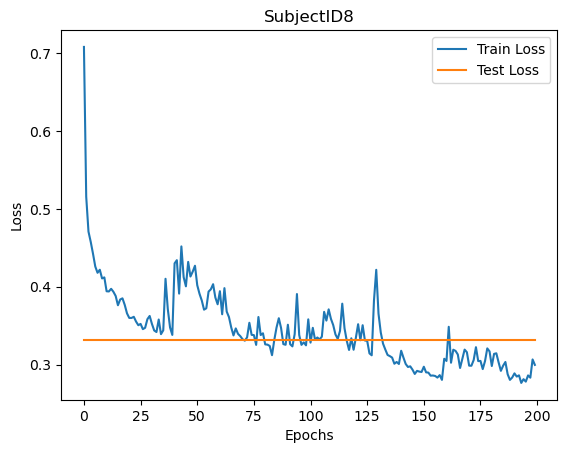

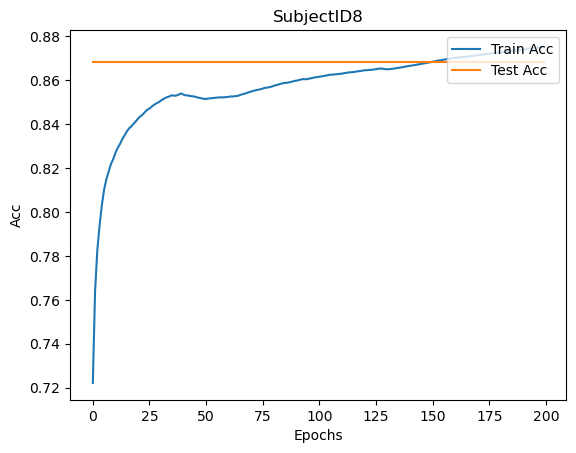


Subject 9
| epoch   0 | 0.0993 s/epoch | train loss 0.7151
| epoch   1 | 0.1007 s/epoch | train loss 0.5197
| epoch   2 | 0.0999 s/epoch | train loss 0.4889
| epoch   3 | 0.0996 s/epoch | train loss 0.4695
| epoch   4 | 0.1002 s/epoch | train loss 0.4586
| epoch   5 | 0.1002 s/epoch | train loss 0.4520
| epoch   6 | 0.1009 s/epoch | train loss 0.4313
| epoch   7 | 0.1000 s/epoch | train loss 0.4377
| epoch   8 | 0.1012 s/epoch | train loss 0.4265
| epoch   9 | 0.1012 s/epoch | train loss 0.4098
| epoch  10 | 0.0999 s/epoch | train loss 0.4102
| epoch  11 | 0.1001 s/epoch | train loss 0.4215
| epoch  12 | 0.1029 s/epoch | train loss 0.4180
| epoch  13 | 0.1001 s/epoch | train loss 0.4146
| epoch  14 | 0.1025 s/epoch | train loss 0.4027
| epoch  15 | 0.1011 s/epoch | train loss 0.4223
| epoch  16 | 0.1012 s/epoch | train loss 0.4134
| epoch  17 | 0.1017 s/epoch | train loss 0.4175
| epoch  18 | 0.1015 s/epoch | train loss 0.4049
| epoch  19 | 0.1002 s/epoch | train loss 0.3877
| epoch  

| epoch 167 | 0.0884 s/epoch | train loss 0.3185
| epoch 168 | 0.0884 s/epoch | train loss 0.3437
| epoch 169 | 0.0889 s/epoch | train loss 0.3962
| epoch 170 | 0.0905 s/epoch | train loss 0.3608
| epoch 171 | 0.0899 s/epoch | train loss 0.3449
| epoch 172 | 0.0896 s/epoch | train loss 0.3388
| epoch 173 | 0.0896 s/epoch | train loss 0.3209
| epoch 174 | 0.0893 s/epoch | train loss 0.3195
| epoch 175 | 0.0885 s/epoch | train loss 0.3319
| epoch 176 | 0.0889 s/epoch | train loss 0.3938
| epoch 177 | 0.0885 s/epoch | train loss 0.3682
| epoch 178 | 0.0896 s/epoch | train loss 0.3515
| epoch 179 | 0.0889 s/epoch | train loss 0.3316
| epoch 180 | 0.0894 s/epoch | train loss 0.3383
| epoch 181 | 0.0901 s/epoch | train loss 0.3303
| epoch 182 | 0.0896 s/epoch | train loss 0.3375
| epoch 183 | 0.0893 s/epoch | train loss 0.3232
| epoch 184 | 0.0880 s/epoch | train loss 0.3113
| epoch 185 | 0.0883 s/epoch | train loss 0.3020
| epoch 186 | 0.0890 s/epoch | train loss 0.3185
| epoch 187 | 0.0878

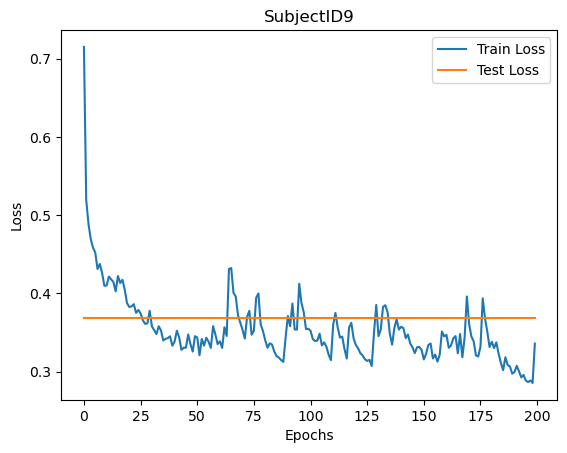

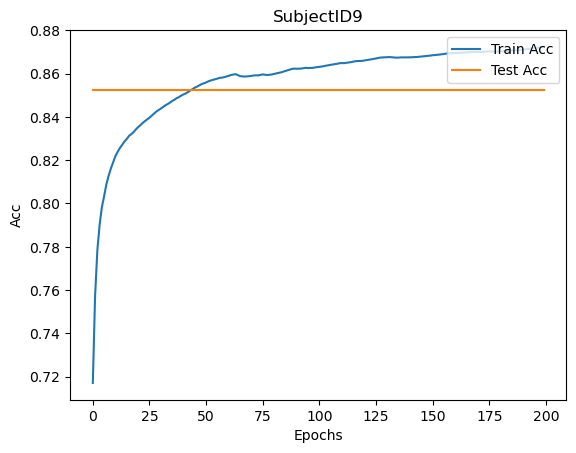


Subject 10
| epoch   0 | 0.0942 s/epoch | train loss 0.7364
| epoch   1 | 0.1004 s/epoch | train loss 0.5375
| epoch   2 | 0.0999 s/epoch | train loss 0.4998
| epoch   3 | 0.1008 s/epoch | train loss 0.4720
| epoch   4 | 0.1004 s/epoch | train loss 0.4676
| epoch   5 | 0.1011 s/epoch | train loss 0.4361
| epoch   6 | 0.1002 s/epoch | train loss 0.4383
| epoch   7 | 0.1006 s/epoch | train loss 0.4272
| epoch   8 | 0.1001 s/epoch | train loss 0.4185
| epoch   9 | 0.1009 s/epoch | train loss 0.4269
| epoch  10 | 0.1005 s/epoch | train loss 0.4256
| epoch  11 | 0.1003 s/epoch | train loss 0.4180
| epoch  12 | 0.0991 s/epoch | train loss 0.4029
| epoch  13 | 0.1002 s/epoch | train loss 0.4273
| epoch  14 | 0.1001 s/epoch | train loss 0.4270
| epoch  15 | 0.1016 s/epoch | train loss 0.4045
| epoch  16 | 0.0995 s/epoch | train loss 0.3897
| epoch  17 | 0.0996 s/epoch | train loss 0.4024
| epoch  18 | 0.0989 s/epoch | train loss 0.3914
| epoch  19 | 0.1008 s/epoch | train loss 0.4012
| epoch 

| epoch 167 | 0.1011 s/epoch | train loss 0.2757
| epoch 168 | 0.0995 s/epoch | train loss 0.2632
| epoch 169 | 0.1013 s/epoch | train loss 0.2582
| epoch 170 | 0.0999 s/epoch | train loss 0.2631
| epoch 171 | 0.1004 s/epoch | train loss 0.2580
| epoch 172 | 0.0988 s/epoch | train loss 0.2583
| epoch 173 | 0.1007 s/epoch | train loss 0.2629
| epoch 174 | 0.1005 s/epoch | train loss 0.2578
| epoch 175 | 0.1010 s/epoch | train loss 0.2599
| epoch 176 | 0.1003 s/epoch | train loss 0.2580
| epoch 177 | 0.0998 s/epoch | train loss 0.2635
| epoch 178 | 0.1011 s/epoch | train loss 0.2604
| epoch 179 | 0.0985 s/epoch | train loss 0.2591
| epoch 180 | 0.0957 s/epoch | train loss 0.2613
| epoch 181 | 0.0981 s/epoch | train loss 0.2593
| epoch 182 | 0.0970 s/epoch | train loss 0.2619
| epoch 183 | 0.0967 s/epoch | train loss 0.2592
| epoch 184 | 0.0969 s/epoch | train loss 0.2572
| epoch 185 | 0.0934 s/epoch | train loss 0.2566
| epoch 186 | 0.0877 s/epoch | train loss 0.2879
| epoch 187 | 0.0908

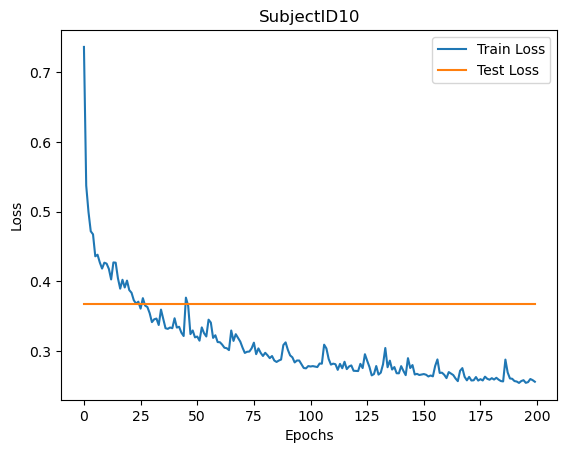

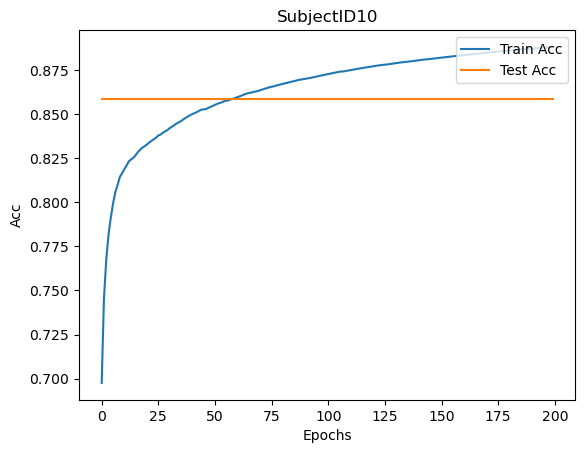


Subject 11
| epoch   0 | 0.0898 s/epoch | train loss 0.7362
| epoch   1 | 0.0889 s/epoch | train loss 0.5206
| epoch   2 | 0.0892 s/epoch | train loss 0.4685
| epoch   3 | 0.0892 s/epoch | train loss 0.4515
| epoch   4 | 0.0893 s/epoch | train loss 0.4450
| epoch   5 | 0.0899 s/epoch | train loss 0.4365
| epoch   6 | 0.0893 s/epoch | train loss 0.4200
| epoch   7 | 0.0887 s/epoch | train loss 0.4222
| epoch   8 | 0.0894 s/epoch | train loss 0.4137
| epoch   9 | 0.0876 s/epoch | train loss 0.4007
| epoch  10 | 0.0883 s/epoch | train loss 0.4004
| epoch  11 | 0.0895 s/epoch | train loss 0.3962
| epoch  12 | 0.0888 s/epoch | train loss 0.3938
| epoch  13 | 0.0893 s/epoch | train loss 0.4080
| epoch  14 | 0.0880 s/epoch | train loss 0.3831
| epoch  15 | 0.0890 s/epoch | train loss 0.3755
| epoch  16 | 0.0877 s/epoch | train loss 0.3696
| epoch  17 | 0.0882 s/epoch | train loss 0.3777
| epoch  18 | 0.0875 s/epoch | train loss 0.3756
| epoch  19 | 0.0889 s/epoch | train loss 0.3648
| epoch 

| epoch 167 | 0.0999 s/epoch | train loss 0.2719
| epoch 168 | 0.1008 s/epoch | train loss 0.2704
| epoch 169 | 0.1002 s/epoch | train loss 0.2767
| epoch 170 | 0.1003 s/epoch | train loss 0.2783
| epoch 171 | 0.1010 s/epoch | train loss 0.2647
| epoch 172 | 0.1004 s/epoch | train loss 0.3420
| epoch 173 | 0.1007 s/epoch | train loss 0.3477
| epoch 174 | 0.1008 s/epoch | train loss 0.3146
| epoch 175 | 0.1006 s/epoch | train loss 0.2934
| epoch 176 | 0.0994 s/epoch | train loss 0.2869
| epoch 177 | 0.1007 s/epoch | train loss 0.2860
| epoch 178 | 0.1012 s/epoch | train loss 0.2841
| epoch 179 | 0.1001 s/epoch | train loss 0.2779
| epoch 180 | 0.1004 s/epoch | train loss 0.2749
| epoch 181 | 0.1020 s/epoch | train loss 0.2720
| epoch 182 | 0.1010 s/epoch | train loss 0.2755
| epoch 183 | 0.1002 s/epoch | train loss 0.2807
| epoch 184 | 0.1014 s/epoch | train loss 0.2904
| epoch 185 | 0.0998 s/epoch | train loss 0.2763
| epoch 186 | 0.1023 s/epoch | train loss 0.2757
| epoch 187 | 0.1018

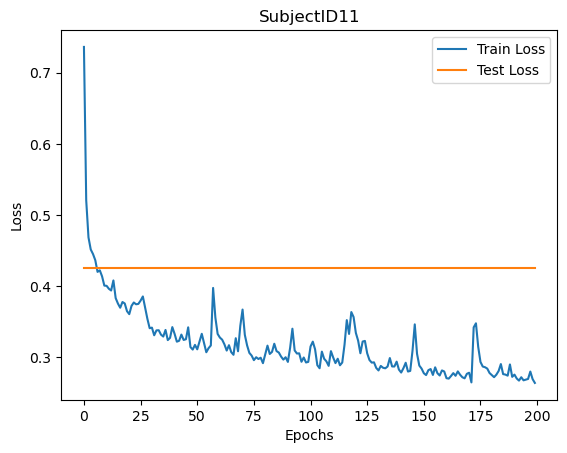

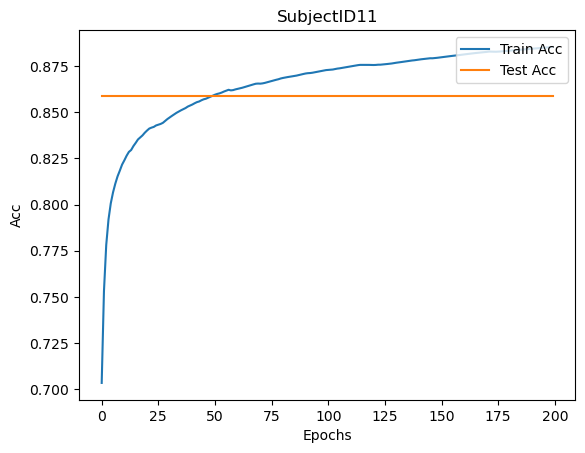


Subject 12
| epoch   0 | 0.1015 s/epoch | train loss 0.7056
| epoch   1 | 0.1009 s/epoch | train loss 0.5297
| epoch   2 | 0.1007 s/epoch | train loss 0.4951
| epoch   3 | 0.1026 s/epoch | train loss 0.4623
| epoch   4 | 0.0997 s/epoch | train loss 0.4587
| epoch   5 | 0.1016 s/epoch | train loss 0.4425
| epoch   6 | 0.1001 s/epoch | train loss 0.4377
| epoch   7 | 0.0995 s/epoch | train loss 0.4270
| epoch   8 | 0.0995 s/epoch | train loss 0.4306
| epoch   9 | 0.1004 s/epoch | train loss 0.4195
| epoch  10 | 0.1000 s/epoch | train loss 0.4217
| epoch  11 | 0.0996 s/epoch | train loss 0.4036
| epoch  12 | 0.1002 s/epoch | train loss 0.4005
| epoch  13 | 0.1012 s/epoch | train loss 0.4007
| epoch  14 | 0.0996 s/epoch | train loss 0.3932
| epoch  15 | 0.0998 s/epoch | train loss 0.3942
| epoch  16 | 0.1000 s/epoch | train loss 0.3881
| epoch  17 | 0.1010 s/epoch | train loss 0.3771
| epoch  18 | 0.1006 s/epoch | train loss 0.3729
| epoch  19 | 0.0997 s/epoch | train loss 0.3736
| epoch 

| epoch 167 | 0.0884 s/epoch | train loss 0.2770
| epoch 168 | 0.0893 s/epoch | train loss 0.2722
| epoch 169 | 0.0890 s/epoch | train loss 0.2748
| epoch 170 | 0.0890 s/epoch | train loss 0.3164
| epoch 171 | 0.0886 s/epoch | train loss 0.2962
| epoch 172 | 0.0879 s/epoch | train loss 0.2906
| epoch 173 | 0.0887 s/epoch | train loss 0.2793
| epoch 174 | 0.0892 s/epoch | train loss 0.2792
| epoch 175 | 0.0876 s/epoch | train loss 0.2784
| epoch 176 | 0.0898 s/epoch | train loss 0.2960
| epoch 177 | 0.0890 s/epoch | train loss 0.2779
| epoch 178 | 0.0884 s/epoch | train loss 0.2797
| epoch 179 | 0.0900 s/epoch | train loss 0.2726
| epoch 180 | 0.0880 s/epoch | train loss 0.2732
| epoch 181 | 0.0883 s/epoch | train loss 0.2689
| epoch 182 | 0.0901 s/epoch | train loss 0.2689
| epoch 183 | 0.0875 s/epoch | train loss 0.2677
| epoch 184 | 0.0892 s/epoch | train loss 0.2658
| epoch 185 | 0.0885 s/epoch | train loss 0.2684
| epoch 186 | 0.0884 s/epoch | train loss 0.2676
| epoch 187 | 0.0886

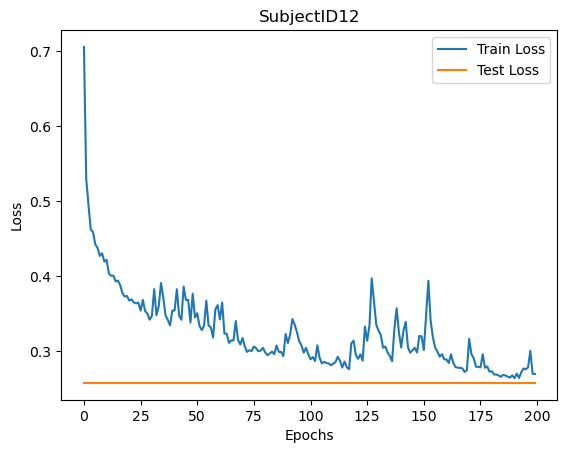

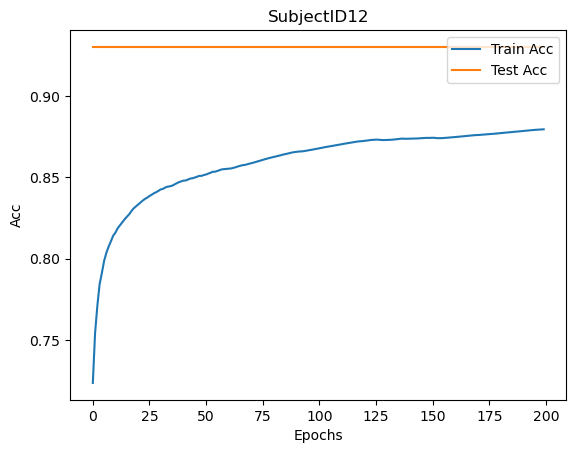


Subject 13
| epoch   0 | 0.0888 s/epoch | train loss 0.6516
| epoch   1 | 0.0874 s/epoch | train loss 0.5041
| epoch   2 | 0.0892 s/epoch | train loss 0.4682
| epoch   3 | 0.0881 s/epoch | train loss 0.4501
| epoch   4 | 0.0896 s/epoch | train loss 0.4333
| epoch   5 | 0.0896 s/epoch | train loss 0.4222
| epoch   6 | 0.0890 s/epoch | train loss 0.4142
| epoch   7 | 0.0879 s/epoch | train loss 0.3988
| epoch   8 | 0.0887 s/epoch | train loss 0.4023
| epoch   9 | 0.0883 s/epoch | train loss 0.4111
| epoch  10 | 0.0896 s/epoch | train loss 0.4192
| epoch  11 | 0.0901 s/epoch | train loss 0.4056
| epoch  12 | 0.0890 s/epoch | train loss 0.4181
| epoch  13 | 0.0893 s/epoch | train loss 0.4113
| epoch  14 | 0.0885 s/epoch | train loss 0.3859
| epoch  15 | 0.0885 s/epoch | train loss 0.3777
| epoch  16 | 0.0884 s/epoch | train loss 0.3784
| epoch  17 | 0.0896 s/epoch | train loss 0.3733
| epoch  18 | 0.0897 s/epoch | train loss 0.3690
| epoch  19 | 0.0888 s/epoch | train loss 0.3718
| epoch 

| epoch 167 | 0.1000 s/epoch | train loss 0.2904
| epoch 168 | 0.1011 s/epoch | train loss 0.2892
| epoch 169 | 0.0994 s/epoch | train loss 0.2880
| epoch 170 | 0.0988 s/epoch | train loss 0.2996
| epoch 171 | 0.1011 s/epoch | train loss 0.2928
| epoch 172 | 0.0994 s/epoch | train loss 0.2850
| epoch 173 | 0.1010 s/epoch | train loss 0.2826
| epoch 174 | 0.0996 s/epoch | train loss 0.2850
| epoch 175 | 0.0996 s/epoch | train loss 0.2806
| epoch 176 | 0.1001 s/epoch | train loss 0.2836
| epoch 177 | 0.1002 s/epoch | train loss 0.3104
| epoch 178 | 0.1026 s/epoch | train loss 0.2972
| epoch 179 | 0.1018 s/epoch | train loss 0.2901
| epoch 180 | 0.1007 s/epoch | train loss 0.2827
| epoch 181 | 0.1003 s/epoch | train loss 0.2782
| epoch 182 | 0.1004 s/epoch | train loss 0.2870
| epoch 183 | 0.1012 s/epoch | train loss 0.2815
| epoch 184 | 0.1003 s/epoch | train loss 0.2802
| epoch 185 | 0.0995 s/epoch | train loss 0.2822
| epoch 186 | 0.0999 s/epoch | train loss 0.2807
| epoch 187 | 0.0993

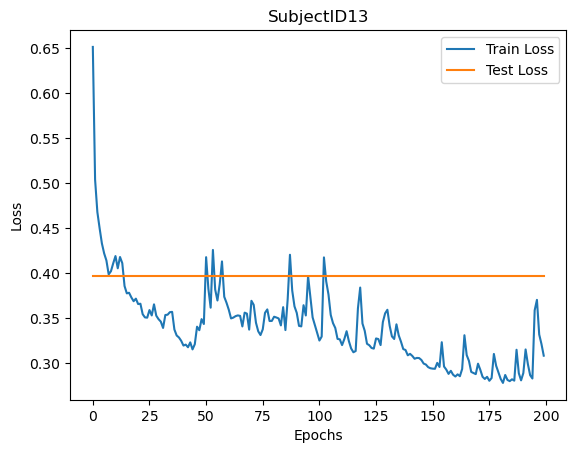

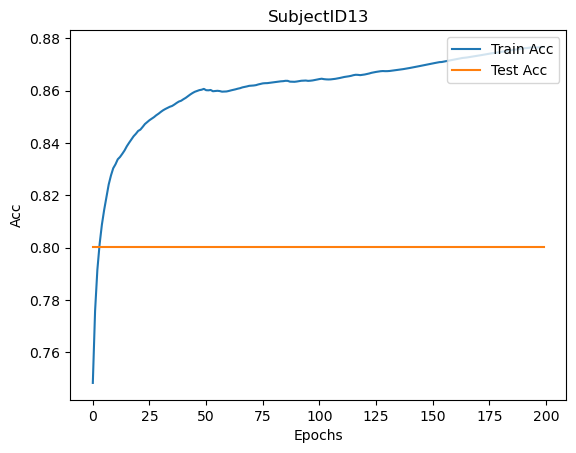


Subject 14
| epoch   0 | 0.1001 s/epoch | train loss 0.7343
| epoch   1 | 0.1011 s/epoch | train loss 0.5066
| epoch   2 | 0.0999 s/epoch | train loss 0.4708
| epoch   3 | 0.1008 s/epoch | train loss 0.4513
| epoch   4 | 0.1000 s/epoch | train loss 0.4349
| epoch   5 | 0.1010 s/epoch | train loss 0.4252
| epoch   6 | 0.1021 s/epoch | train loss 0.4118
| epoch   7 | 0.1005 s/epoch | train loss 0.4125
| epoch   8 | 0.1004 s/epoch | train loss 0.4086
| epoch   9 | 0.1014 s/epoch | train loss 0.4038
| epoch  10 | 0.1014 s/epoch | train loss 0.4019
| epoch  11 | 0.1005 s/epoch | train loss 0.4127
| epoch  12 | 0.1007 s/epoch | train loss 0.3962
| epoch  13 | 0.1000 s/epoch | train loss 0.3912
| epoch  14 | 0.1014 s/epoch | train loss 0.3895
| epoch  15 | 0.0999 s/epoch | train loss 0.4013
| epoch  16 | 0.1016 s/epoch | train loss 0.3871
| epoch  17 | 0.1003 s/epoch | train loss 0.3711
| epoch  18 | 0.0994 s/epoch | train loss 0.3674
| epoch  19 | 0.1006 s/epoch | train loss 0.3610
| epoch 

| epoch 167 | 0.0893 s/epoch | train loss 0.2797
| epoch 168 | 0.0880 s/epoch | train loss 0.2713
| epoch 169 | 0.0898 s/epoch | train loss 0.2682
| epoch 170 | 0.0880 s/epoch | train loss 0.2693
| epoch 171 | 0.0897 s/epoch | train loss 0.2755
| epoch 172 | 0.0893 s/epoch | train loss 0.2847
| epoch 173 | 0.0889 s/epoch | train loss 0.2890
| epoch 174 | 0.0894 s/epoch | train loss 0.2775
| epoch 175 | 0.0890 s/epoch | train loss 0.2902
| epoch 176 | 0.0876 s/epoch | train loss 0.2888
| epoch 177 | 0.0883 s/epoch | train loss 0.2744
| epoch 178 | 0.0889 s/epoch | train loss 0.2728
| epoch 179 | 0.0882 s/epoch | train loss 0.2722
| epoch 180 | 0.0874 s/epoch | train loss 0.2723
| epoch 181 | 0.0899 s/epoch | train loss 0.2743
| epoch 182 | 0.0894 s/epoch | train loss 0.2752
| epoch 183 | 0.0889 s/epoch | train loss 0.2753
| epoch 184 | 0.0890 s/epoch | train loss 0.2815
| epoch 185 | 0.0885 s/epoch | train loss 0.2652
| epoch 186 | 0.0897 s/epoch | train loss 0.2707
| epoch 187 | 0.0892

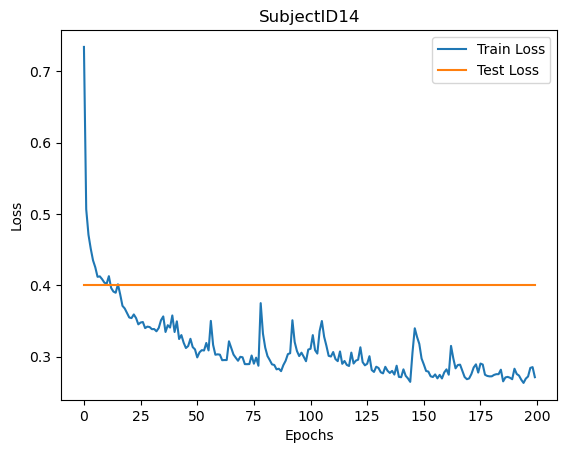

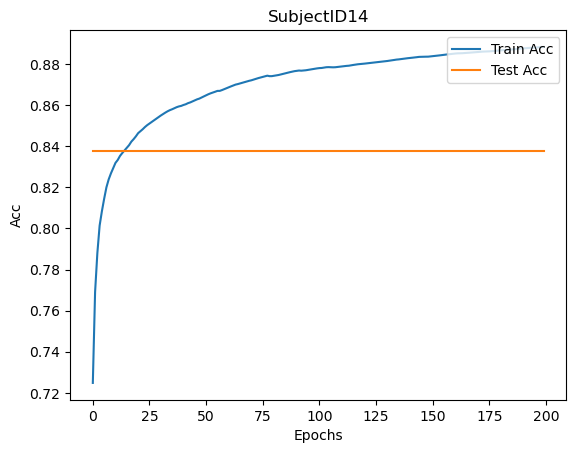


Subject 15
| epoch   0 | 0.1001 s/epoch | train loss 0.6958
| epoch   1 | 0.0985 s/epoch | train loss 0.5142
| epoch   2 | 0.0971 s/epoch | train loss 0.4907
| epoch   3 | 0.0985 s/epoch | train loss 0.4735
| epoch   4 | 0.0978 s/epoch | train loss 0.4450
| epoch   5 | 0.0985 s/epoch | train loss 0.4382
| epoch   6 | 0.0974 s/epoch | train loss 0.4304
| epoch   7 | 0.0990 s/epoch | train loss 0.4231
| epoch   8 | 0.0990 s/epoch | train loss 0.4134
| epoch   9 | 0.0982 s/epoch | train loss 0.4016
| epoch  10 | 0.0989 s/epoch | train loss 0.4171
| epoch  11 | 0.1004 s/epoch | train loss 0.4458
| epoch  12 | 0.0960 s/epoch | train loss 0.4129
| epoch  13 | 0.0983 s/epoch | train loss 0.4004
| epoch  14 | 0.0984 s/epoch | train loss 0.4093
| epoch  15 | 0.0973 s/epoch | train loss 0.3923
| epoch  16 | 0.0985 s/epoch | train loss 0.3826
| epoch  17 | 0.0983 s/epoch | train loss 0.3748
| epoch  18 | 0.0984 s/epoch | train loss 0.3743
| epoch  19 | 0.0974 s/epoch | train loss 0.3672
| epoch 

| epoch 167 | 0.0981 s/epoch | train loss 0.3416
| epoch 168 | 0.0976 s/epoch | train loss 0.3333
| epoch 169 | 0.0990 s/epoch | train loss 0.3322
| epoch 170 | 0.0991 s/epoch | train loss 0.3225
| epoch 171 | 0.0949 s/epoch | train loss 0.3169
| epoch 172 | 0.0955 s/epoch | train loss 0.3173
| epoch 173 | 0.0934 s/epoch | train loss 0.3479
| epoch 174 | 0.0945 s/epoch | train loss 0.3227
| epoch 175 | 0.0958 s/epoch | train loss 0.3175
| epoch 176 | 0.0967 s/epoch | train loss 0.3137
| epoch 177 | 0.0872 s/epoch | train loss 0.3172
| epoch 178 | 0.0880 s/epoch | train loss 0.3120
| epoch 179 | 0.0878 s/epoch | train loss 0.3068
| epoch 180 | 0.0869 s/epoch | train loss 0.3003
| epoch 181 | 0.0876 s/epoch | train loss 0.2984
| epoch 182 | 0.0880 s/epoch | train loss 0.2988
| epoch 183 | 0.0868 s/epoch | train loss 0.2986
| epoch 184 | 0.0865 s/epoch | train loss 0.3004
| epoch 185 | 0.0876 s/epoch | train loss 0.3362
| epoch 186 | 0.0852 s/epoch | train loss 0.3300
| epoch 187 | 0.0865

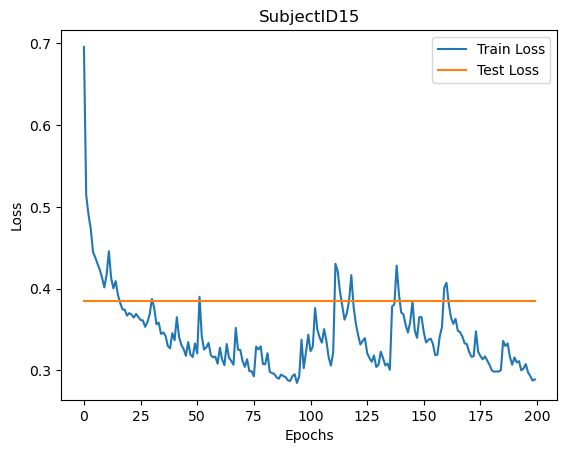

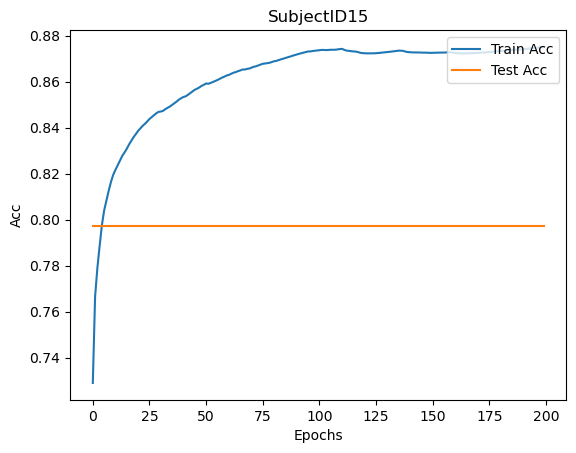


Subject 16
| epoch   0 | 0.0871 s/epoch | train loss 0.7368
| epoch   1 | 0.0886 s/epoch | train loss 0.5283
| epoch   2 | 0.0863 s/epoch | train loss 0.4990
| epoch   3 | 0.0861 s/epoch | train loss 0.4742
| epoch   4 | 0.0850 s/epoch | train loss 0.4589
| epoch   5 | 0.0877 s/epoch | train loss 0.4547
| epoch   6 | 0.0877 s/epoch | train loss 0.4588
| epoch   7 | 0.0867 s/epoch | train loss 0.4380
| epoch   8 | 0.0892 s/epoch | train loss 0.4269
| epoch   9 | 0.0863 s/epoch | train loss 0.4206
| epoch  10 | 0.0868 s/epoch | train loss 0.4279
| epoch  11 | 0.0863 s/epoch | train loss 0.4487
| epoch  12 | 0.0872 s/epoch | train loss 0.4198
| epoch  13 | 0.0862 s/epoch | train loss 0.4227
| epoch  14 | 0.0872 s/epoch | train loss 0.4180
| epoch  15 | 0.0872 s/epoch | train loss 0.4187
| epoch  16 | 0.0880 s/epoch | train loss 0.4146
| epoch  17 | 0.0894 s/epoch | train loss 0.4065
| epoch  18 | 0.0865 s/epoch | train loss 0.3935
| epoch  19 | 0.0867 s/epoch | train loss 0.3896
| epoch 

| epoch 167 | 0.0979 s/epoch | train loss 0.2826
| epoch 168 | 0.0983 s/epoch | train loss 0.2951
| epoch 169 | 0.0981 s/epoch | train loss 0.2942
| epoch 170 | 0.0986 s/epoch | train loss 0.3099
| epoch 171 | 0.0985 s/epoch | train loss 0.2998
| epoch 172 | 0.0980 s/epoch | train loss 0.2869
| epoch 173 | 0.0980 s/epoch | train loss 0.2867
| epoch 174 | 0.0978 s/epoch | train loss 0.2786
| epoch 175 | 0.0985 s/epoch | train loss 0.2786
| epoch 176 | 0.0979 s/epoch | train loss 0.2814
| epoch 177 | 0.0975 s/epoch | train loss 0.2836
| epoch 178 | 0.0972 s/epoch | train loss 0.2747
| epoch 179 | 0.0998 s/epoch | train loss 0.2793
| epoch 180 | 0.0993 s/epoch | train loss 0.2769
| epoch 181 | 0.0985 s/epoch | train loss 0.2782
| epoch 182 | 0.0982 s/epoch | train loss 0.2752
| epoch 183 | 0.0969 s/epoch | train loss 0.2759
| epoch 184 | 0.0986 s/epoch | train loss 0.2710
| epoch 185 | 0.0975 s/epoch | train loss 0.2785
| epoch 186 | 0.0988 s/epoch | train loss 0.2749
| epoch 187 | 0.0992

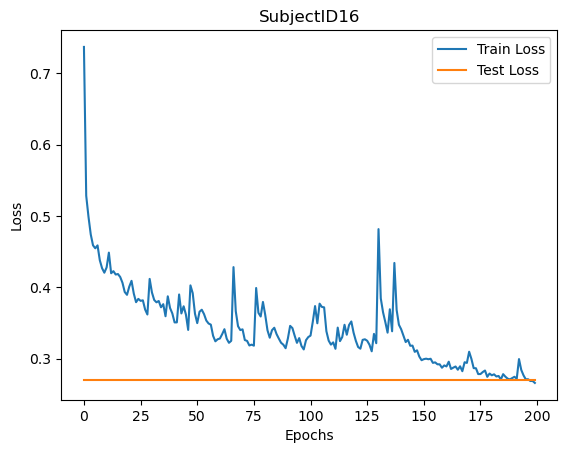

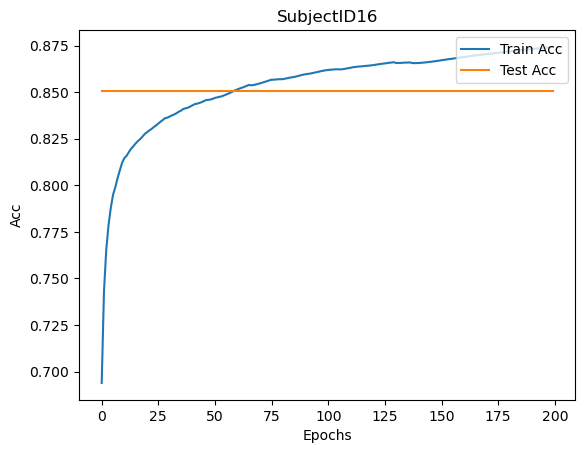


Subject 18
| epoch   0 | 0.0997 s/epoch | train loss 0.7037
| epoch   1 | 0.0983 s/epoch | train loss 0.5204
| epoch   2 | 0.0984 s/epoch | train loss 0.4842
| epoch   3 | 0.0974 s/epoch | train loss 0.4686
| epoch   4 | 0.0975 s/epoch | train loss 0.4523
| epoch   5 | 0.0985 s/epoch | train loss 0.4411
| epoch   6 | 0.0992 s/epoch | train loss 0.4300
| epoch   7 | 0.0968 s/epoch | train loss 0.4219
| epoch   8 | 0.0980 s/epoch | train loss 0.4228
| epoch   9 | 0.0988 s/epoch | train loss 0.4084
| epoch  10 | 0.0975 s/epoch | train loss 0.4015
| epoch  11 | 0.0982 s/epoch | train loss 0.3952
| epoch  12 | 0.0962 s/epoch | train loss 0.3969
| epoch  13 | 0.0981 s/epoch | train loss 0.3961
| epoch  14 | 0.0974 s/epoch | train loss 0.3885
| epoch  15 | 0.0974 s/epoch | train loss 0.3867
| epoch  16 | 0.0974 s/epoch | train loss 0.3720
| epoch  17 | 0.0993 s/epoch | train loss 0.3686
| epoch  18 | 0.0979 s/epoch | train loss 0.3643
| epoch  19 | 0.0988 s/epoch | train loss 0.3671
| epoch 

| epoch 167 | 0.0864 s/epoch | train loss 0.3241
| epoch 168 | 0.0868 s/epoch | train loss 0.2977
| epoch 169 | 0.0869 s/epoch | train loss 0.2968
| epoch 170 | 0.0872 s/epoch | train loss 0.2977
| epoch 171 | 0.0891 s/epoch | train loss 0.3005
| epoch 172 | 0.0872 s/epoch | train loss 0.3451
| epoch 173 | 0.0861 s/epoch | train loss 0.3526
| epoch 174 | 0.0873 s/epoch | train loss 0.3267
| epoch 175 | 0.0875 s/epoch | train loss 0.3153
| epoch 176 | 0.0877 s/epoch | train loss 0.3074
| epoch 177 | 0.0872 s/epoch | train loss 0.2991
| epoch 178 | 0.0873 s/epoch | train loss 0.2976
| epoch 179 | 0.0877 s/epoch | train loss 0.2883
| epoch 180 | 0.0875 s/epoch | train loss 0.2877
| epoch 181 | 0.0883 s/epoch | train loss 0.2861
| epoch 182 | 0.0870 s/epoch | train loss 0.3234
| epoch 183 | 0.0871 s/epoch | train loss 0.3153
| epoch 184 | 0.0872 s/epoch | train loss 0.3015
| epoch 185 | 0.0865 s/epoch | train loss 0.3248
| epoch 186 | 0.0868 s/epoch | train loss 0.3080
| epoch 187 | 0.0872

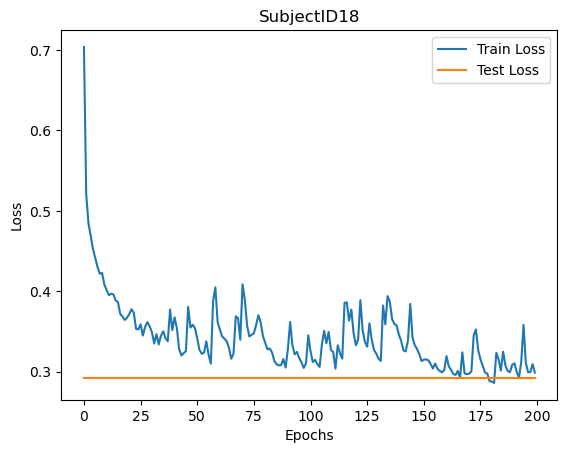

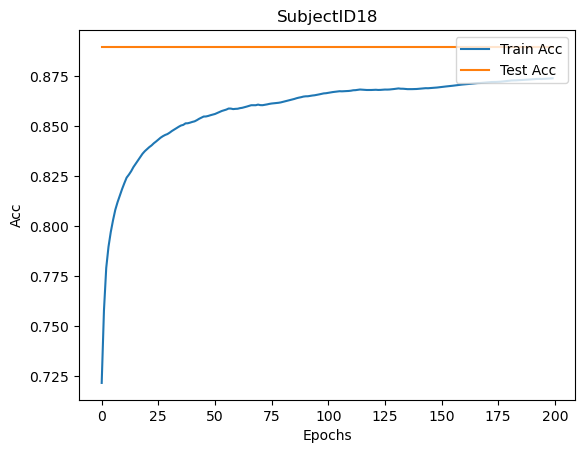


Subject 19
| epoch   0 | 0.0870 s/epoch | train loss 0.7434
| epoch   1 | 0.0863 s/epoch | train loss 0.5397
| epoch   2 | 0.0867 s/epoch | train loss 0.4924
| epoch   3 | 0.0869 s/epoch | train loss 0.4722
| epoch   4 | 0.0868 s/epoch | train loss 0.4520
| epoch   5 | 0.0867 s/epoch | train loss 0.4503
| epoch   6 | 0.0886 s/epoch | train loss 0.4367
| epoch   7 | 0.0876 s/epoch | train loss 0.4431
| epoch   8 | 0.0882 s/epoch | train loss 0.4296
| epoch   9 | 0.0864 s/epoch | train loss 0.4347
| epoch  10 | 0.0870 s/epoch | train loss 0.4312
| epoch  11 | 0.0878 s/epoch | train loss 0.4200
| epoch  12 | 0.0862 s/epoch | train loss 0.4036
| epoch  13 | 0.0870 s/epoch | train loss 0.4017
| epoch  14 | 0.0875 s/epoch | train loss 0.3844
| epoch  15 | 0.0870 s/epoch | train loss 0.3885
| epoch  16 | 0.0876 s/epoch | train loss 0.3792
| epoch  17 | 0.0873 s/epoch | train loss 0.3800
| epoch  18 | 0.0873 s/epoch | train loss 0.3993
| epoch  19 | 0.0873 s/epoch | train loss 0.3898
| epoch 

| epoch 167 | 0.0991 s/epoch | train loss 0.2917
| epoch 168 | 0.0984 s/epoch | train loss 0.2924
| epoch 169 | 0.0989 s/epoch | train loss 0.2923
| epoch 170 | 0.0977 s/epoch | train loss 0.2933
| epoch 171 | 0.0984 s/epoch | train loss 0.2903
| epoch 172 | 0.0975 s/epoch | train loss 0.2912
| epoch 173 | 0.0980 s/epoch | train loss 0.2893
| epoch 174 | 0.0999 s/epoch | train loss 0.3024
| epoch 175 | 0.0992 s/epoch | train loss 0.3084
| epoch 176 | 0.0975 s/epoch | train loss 0.2929
| epoch 177 | 0.0991 s/epoch | train loss 0.2835
| epoch 178 | 0.0974 s/epoch | train loss 0.2829
| epoch 179 | 0.0975 s/epoch | train loss 0.2844
| epoch 180 | 0.0975 s/epoch | train loss 0.2824
| epoch 181 | 0.0987 s/epoch | train loss 0.2800
| epoch 182 | 0.0984 s/epoch | train loss 0.2798
| epoch 183 | 0.0978 s/epoch | train loss 0.2762
| epoch 184 | 0.0975 s/epoch | train loss 0.2785
| epoch 185 | 0.0984 s/epoch | train loss 0.2801
| epoch 186 | 0.0978 s/epoch | train loss 0.2815
| epoch 187 | 0.0982

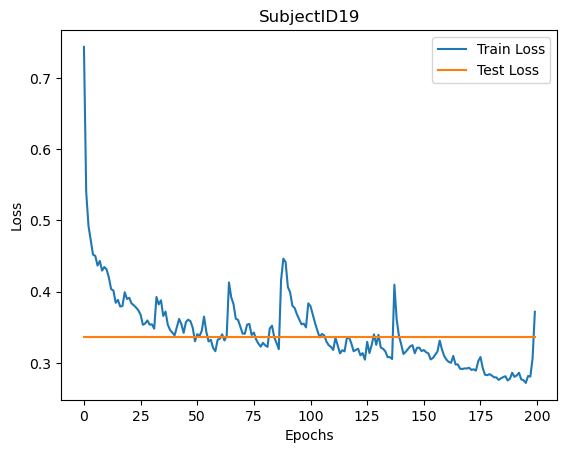

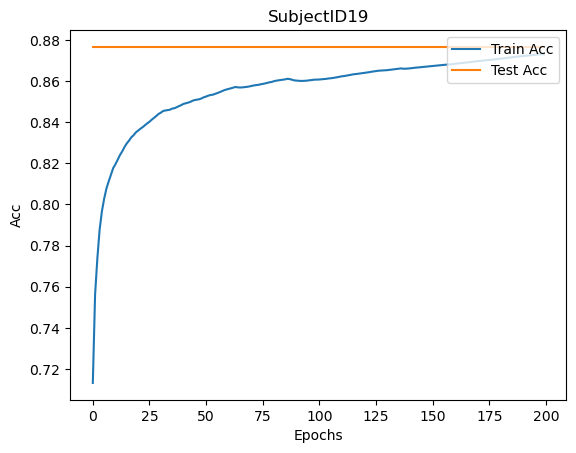


Subject 21
| epoch   0 | 0.0976 s/epoch | train loss 0.6913
| epoch   1 | 0.0985 s/epoch | train loss 0.5263
| epoch   2 | 0.0984 s/epoch | train loss 0.4872
| epoch   3 | 0.0986 s/epoch | train loss 0.4603
| epoch   4 | 0.0999 s/epoch | train loss 0.4481
| epoch   5 | 0.0987 s/epoch | train loss 0.4381
| epoch   6 | 0.0986 s/epoch | train loss 0.4265
| epoch   7 | 0.0993 s/epoch | train loss 0.4149
| epoch   8 | 0.0981 s/epoch | train loss 0.4129
| epoch   9 | 0.0982 s/epoch | train loss 0.4065
| epoch  10 | 0.0973 s/epoch | train loss 0.4095
| epoch  11 | 0.0988 s/epoch | train loss 0.4035
| epoch  12 | 0.0969 s/epoch | train loss 0.4012
| epoch  13 | 0.0979 s/epoch | train loss 0.3946
| epoch  14 | 0.0981 s/epoch | train loss 0.3921
| epoch  15 | 0.0978 s/epoch | train loss 0.3845
| epoch  16 | 0.0990 s/epoch | train loss 0.3822
| epoch  17 | 0.0982 s/epoch | train loss 0.3779
| epoch  18 | 0.0988 s/epoch | train loss 0.3718
| epoch  19 | 0.0977 s/epoch | train loss 0.3669
| epoch 

| epoch 167 | 0.0871 s/epoch | train loss 0.3417
| epoch 168 | 0.0870 s/epoch | train loss 0.3638
| epoch 169 | 0.0866 s/epoch | train loss 0.3919
| epoch 170 | 0.0885 s/epoch | train loss 0.3710
| epoch 171 | 0.0876 s/epoch | train loss 0.3474
| epoch 172 | 0.0874 s/epoch | train loss 0.3335
| epoch 173 | 0.0871 s/epoch | train loss 0.3618
| epoch 174 | 0.0867 s/epoch | train loss 0.3326
| epoch 175 | 0.0860 s/epoch | train loss 0.3251
| epoch 176 | 0.0879 s/epoch | train loss 0.3334
| epoch 177 | 0.0876 s/epoch | train loss 0.3276
| epoch 178 | 0.0878 s/epoch | train loss 0.3136
| epoch 179 | 0.0867 s/epoch | train loss 0.3098
| epoch 180 | 0.0866 s/epoch | train loss 0.3096
| epoch 181 | 0.0870 s/epoch | train loss 0.3189
| epoch 182 | 0.0868 s/epoch | train loss 0.3398
| epoch 183 | 0.0856 s/epoch | train loss 0.3654
| epoch 184 | 0.0874 s/epoch | train loss 0.3353
| epoch 185 | 0.0878 s/epoch | train loss 0.3375
| epoch 186 | 0.0865 s/epoch | train loss 0.3203
| epoch 187 | 0.0847

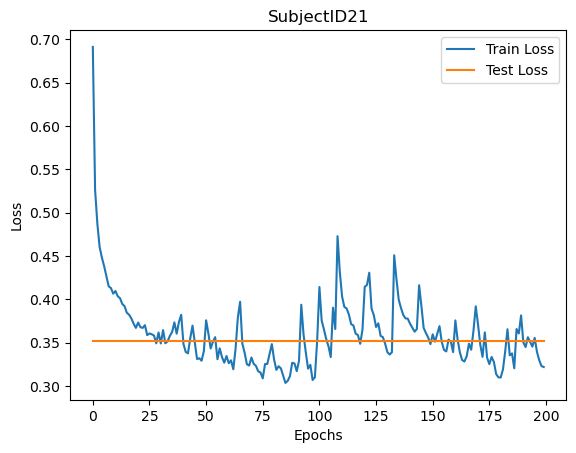

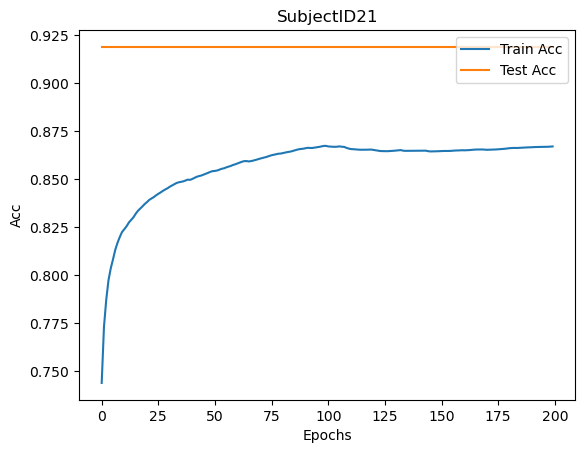


Subject 22
| epoch   0 | 0.0940 s/epoch | train loss 0.7064
| epoch   1 | 0.0956 s/epoch | train loss 0.5224
| epoch   2 | 0.0954 s/epoch | train loss 0.4796
| epoch   3 | 0.0961 s/epoch | train loss 0.4640
| epoch   4 | 0.0956 s/epoch | train loss 0.4553
| epoch   5 | 0.0966 s/epoch | train loss 0.4372
| epoch   6 | 0.0951 s/epoch | train loss 0.4307
| epoch   7 | 0.0955 s/epoch | train loss 0.4332
| epoch   8 | 0.0943 s/epoch | train loss 0.4184
| epoch   9 | 0.0951 s/epoch | train loss 0.4138
| epoch  10 | 0.0939 s/epoch | train loss 0.4186
| epoch  11 | 0.0949 s/epoch | train loss 0.4146
| epoch  12 | 0.0937 s/epoch | train loss 0.4203
| epoch  13 | 0.0945 s/epoch | train loss 0.4034
| epoch  14 | 0.0953 s/epoch | train loss 0.3987
| epoch  15 | 0.0957 s/epoch | train loss 0.3973
| epoch  16 | 0.0954 s/epoch | train loss 0.3929
| epoch  17 | 0.0963 s/epoch | train loss 0.3847
| epoch  18 | 0.0948 s/epoch | train loss 0.3764
| epoch  19 | 0.0954 s/epoch | train loss 0.3818
| epoch 

| epoch 167 | 0.0955 s/epoch | train loss 0.2582
| epoch 168 | 0.0942 s/epoch | train loss 0.2586
| epoch 169 | 0.0955 s/epoch | train loss 0.2646
| epoch 170 | 0.0949 s/epoch | train loss 0.2752
| epoch 171 | 0.0955 s/epoch | train loss 0.2627
| epoch 172 | 0.0944 s/epoch | train loss 0.2593
| epoch 173 | 0.0942 s/epoch | train loss 0.2577
| epoch 174 | 0.0968 s/epoch | train loss 0.2592
| epoch 175 | 0.0945 s/epoch | train loss 0.2659
| epoch 176 | 0.0946 s/epoch | train loss 0.2632
| epoch 177 | 0.0949 s/epoch | train loss 0.2599
| epoch 178 | 0.0953 s/epoch | train loss 0.2645
| epoch 179 | 0.0969 s/epoch | train loss 0.2722
| epoch 180 | 0.0950 s/epoch | train loss 0.2624
| epoch 181 | 0.0943 s/epoch | train loss 0.2541
| epoch 182 | 0.0965 s/epoch | train loss 0.2544
| epoch 183 | 0.0976 s/epoch | train loss 0.2528
| epoch 184 | 0.0954 s/epoch | train loss 0.2586
| epoch 185 | 0.0960 s/epoch | train loss 0.2557
| epoch 186 | 0.0954 s/epoch | train loss 0.2589
| epoch 187 | 0.0948

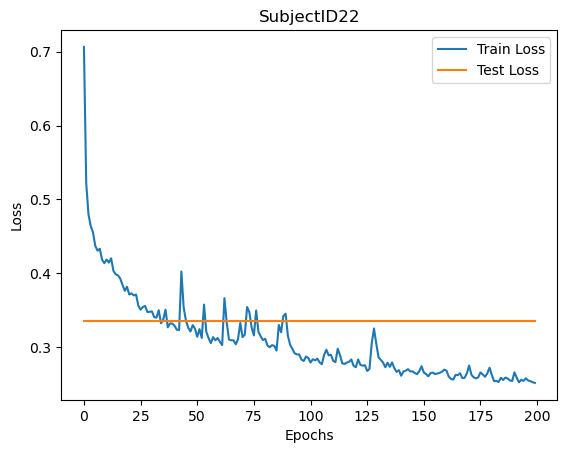

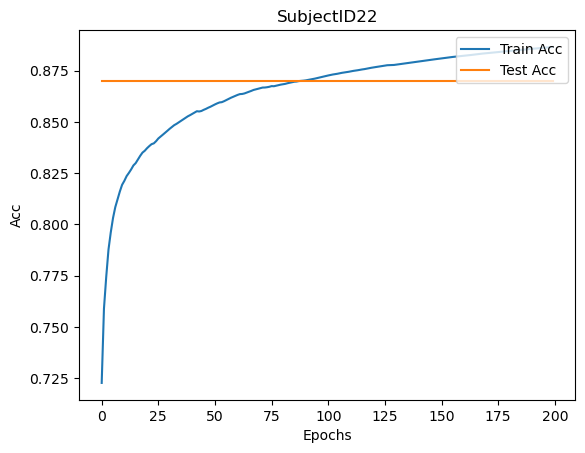


Subject 23
| epoch   0 | 0.0966 s/epoch | train loss 0.7173
| epoch   1 | 0.0947 s/epoch | train loss 0.5291
| epoch   2 | 0.0947 s/epoch | train loss 0.4843
| epoch   3 | 0.0949 s/epoch | train loss 0.4675
| epoch   4 | 0.0953 s/epoch | train loss 0.4537
| epoch   5 | 0.0947 s/epoch | train loss 0.4302
| epoch   6 | 0.0950 s/epoch | train loss 0.4302
| epoch   7 | 0.0955 s/epoch | train loss 0.4198
| epoch   8 | 0.0948 s/epoch | train loss 0.4271
| epoch   9 | 0.0936 s/epoch | train loss 0.4091
| epoch  10 | 0.0949 s/epoch | train loss 0.3960
| epoch  11 | 0.0952 s/epoch | train loss 0.3968
| epoch  12 | 0.0940 s/epoch | train loss 0.3947
| epoch  13 | 0.0941 s/epoch | train loss 0.3828
| epoch  14 | 0.0944 s/epoch | train loss 0.3786
| epoch  15 | 0.0953 s/epoch | train loss 0.3721
| epoch  16 | 0.0954 s/epoch | train loss 0.3734
| epoch  17 | 0.0931 s/epoch | train loss 0.3646
| epoch  18 | 0.0940 s/epoch | train loss 0.3710
| epoch  19 | 0.0944 s/epoch | train loss 0.3596
| epoch 

| epoch 167 | 0.0968 s/epoch | train loss 0.2723
| epoch 168 | 0.0960 s/epoch | train loss 0.2910
| epoch 169 | 0.0959 s/epoch | train loss 0.2838
| epoch 170 | 0.0943 s/epoch | train loss 0.2806
| epoch 171 | 0.0953 s/epoch | train loss 0.2860
| epoch 172 | 0.0946 s/epoch | train loss 0.2977
| epoch 173 | 0.0934 s/epoch | train loss 0.3000
| epoch 174 | 0.0950 s/epoch | train loss 0.3785
| epoch 175 | 0.0962 s/epoch | train loss 0.3287
| epoch 176 | 0.0961 s/epoch | train loss 0.3104
| epoch 177 | 0.0946 s/epoch | train loss 0.3079
| epoch 178 | 0.0950 s/epoch | train loss 0.3065
| epoch 179 | 0.0947 s/epoch | train loss 0.2994
| epoch 180 | 0.0946 s/epoch | train loss 0.2899
| epoch 181 | 0.0964 s/epoch | train loss 0.2837
| epoch 182 | 0.0959 s/epoch | train loss 0.2766
| epoch 183 | 0.0934 s/epoch | train loss 0.2734
| epoch 184 | 0.0951 s/epoch | train loss 0.2934
| epoch 185 | 0.0958 s/epoch | train loss 0.2860
| epoch 186 | 0.0957 s/epoch | train loss 0.2745
| epoch 187 | 0.0955

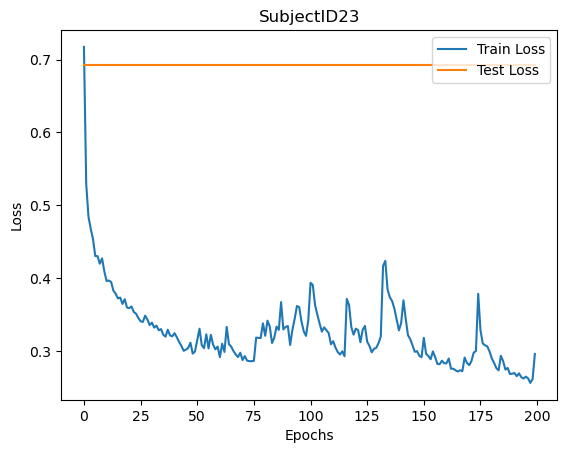

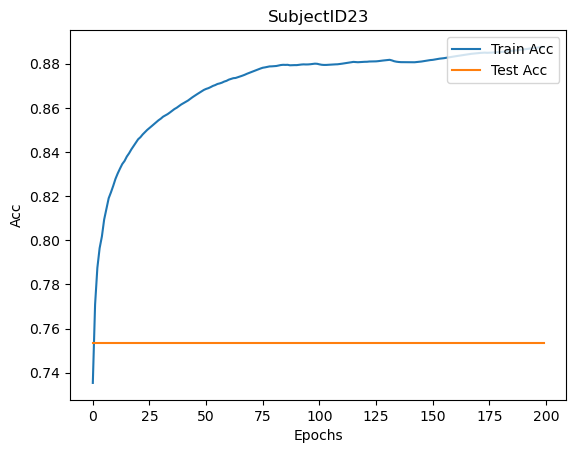

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~


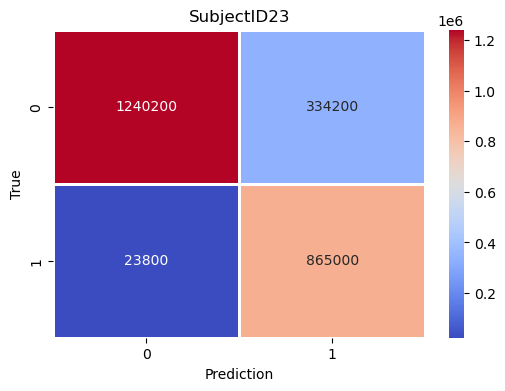

Distillation_teacher(Mobilnet)_Acc: 0.8546606040922378
Distillation_teacher(Mobilnet)_Rec: 0.9732223222322233
Distillation_teacher(Mobilnet)_Pre: 0.721314209472982
Distillation_teacher(Mobilnet)_F1: 0.8285440613026821


<Figure size 640x480 with 0 Axes>

In [17]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_teacher_student = MobileNetV3_Small_KD().to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)

#save(config['epochs'], teacher_student_model, teacher_student_optimizer, teacher_student_loss)
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])


Subject 1
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.0746 s/epoch | train loss 0.4123
| epoch   1 | 0.0748 s/epoch | train loss 0.4119
| epoch   2 | 0.0747 s/epoch | train loss 0.4115
| epoch   3 | 0.0744 s/epoch | train loss 0.4115
| epoch   4 | 0.0764 s/epoch | train loss 0.4117
| epoch   5 | 0.0748 s/epoch | train loss 0.4121
| epoch   6 | 0.0749 s/epoch | train loss 0.4119
| epoch   7 | 0.0742 s/epoch | train loss 0.4117
| epoch   8 | 0.0744 s/epoch | train loss 0.4119
| epoch   9 | 0.0741 s/epoch | train loss 0.4116
| epoch  10 | 0.0748 s/epoch | train loss 0.4119
| epoch  11 | 0.0746 s/epoch | train loss 0.4119
| epoch  12 | 0.0741 s/epoch | train loss 0.4117
| epoch  13 | 0.0750 s/epoch | train loss 0.4119
| epoch  14 | 0.0748 s/epoch | train loss 0.4119
| epoch  15 | 0.0754 s/epoch | train loss 0.4117
| epoch

| epoch 163 | 0.0756 s/epoch | train loss 0.4125
| epoch 164 | 0.0753 s/epoch | train loss 0.4123
| epoch 165 | 0.0757 s/epoch | train loss 0.4122
| epoch 166 | 0.0746 s/epoch | train loss 0.4114
| epoch 167 | 0.0750 s/epoch | train loss 0.4118
| epoch 168 | 0.0754 s/epoch | train loss 0.4118
| epoch 169 | 0.0746 s/epoch | train loss 0.4121
| epoch 170 | 0.0754 s/epoch | train loss 0.4118
| epoch 171 | 0.0742 s/epoch | train loss 0.4119
| epoch 172 | 0.0754 s/epoch | train loss 0.4117
| epoch 173 | 0.0747 s/epoch | train loss 0.4118
| epoch 174 | 0.0746 s/epoch | train loss 0.4124
| epoch 175 | 0.0750 s/epoch | train loss 0.4119
| epoch 176 | 0.0758 s/epoch | train loss 0.4116
| epoch 177 | 0.0746 s/epoch | train loss 0.4126
| epoch 178 | 0.0752 s/epoch | train loss 0.4115
| epoch 179 | 0.0739 s/epoch | train loss 0.4118
| epoch 180 | 0.0753 s/epoch | train loss 0.4118
| epoch 181 | 0.0753 s/epoch | train loss 0.4114
| epoch 182 | 0.0744 s/epoch | train loss 0.4118
| epoch 183 | 0.0747

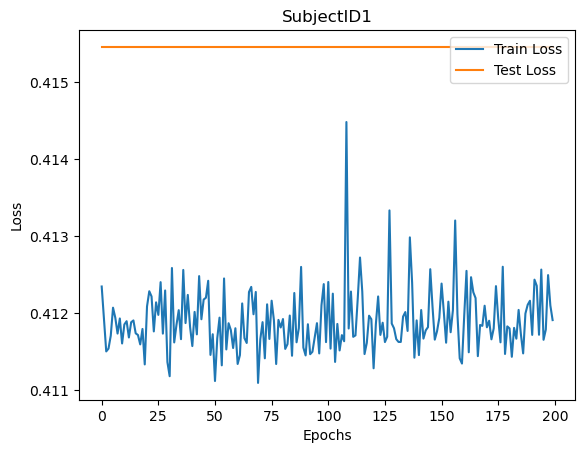

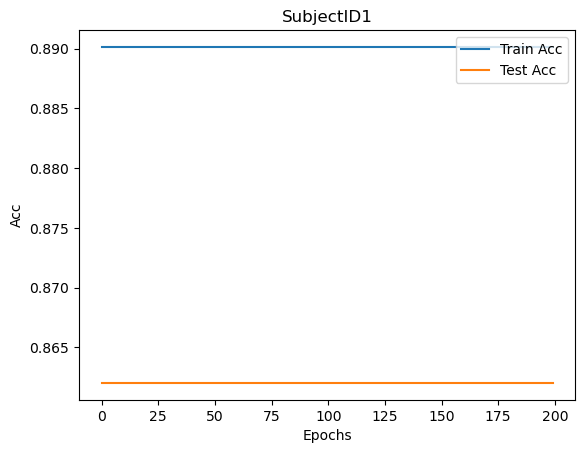


Subject 2
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.0758 s/epoch | train loss 0.4096
| epoch   1 | 0.0749 s/epoch | train loss 0.4089
| epoch   2 | 0.0758 s/epoch | train loss 0.4093
| epoch   3 | 0.0750 s/epoch | train loss 0.4088
| epoch   4 | 0.0749 s/epoch | train loss 0.4092
| epoch   5 | 0.0751 s/epoch | train loss 0.4095
| epoch   6 | 0.0752 s/epoch | train loss 0.4084
| epoch   7 | 0.0747 s/epoch | train loss 0.4087
| epoch   8 | 0.0761 s/epoch | train loss 0.4095
| epoch   9 | 0.0760 s/epoch | train loss 0.4086
| epoch  10 | 0.0749 s/epoch | train loss 0.4092
| epoch  11 | 0.0752 s/epoch | train loss 0.4093
| epoch  12 | 0.0760 s/epoch | train loss 0.4088
| epoch  13 | 0.0757 s/epoch | train loss 0.4089
| epoch  14 | 0.0754 s/epoch | train loss 0.4091
| epoch  15 | 0.0754 s/epoch | train loss 0.4096
| epoch

| epoch 163 | 0.0863 s/epoch | train loss 0.4089
| epoch 164 | 0.0872 s/epoch | train loss 0.4090
| epoch 165 | 0.0876 s/epoch | train loss 0.4091
| epoch 166 | 0.0898 s/epoch | train loss 0.4095
| epoch 167 | 0.0896 s/epoch | train loss 0.4106
| epoch 168 | 0.0862 s/epoch | train loss 0.4089
| epoch 169 | 0.0883 s/epoch | train loss 0.4107
| epoch 170 | 0.0883 s/epoch | train loss 0.4089
| epoch 171 | 0.0829 s/epoch | train loss 0.4095
| epoch 172 | 0.0893 s/epoch | train loss 0.4099
| epoch 173 | 0.0885 s/epoch | train loss 0.4088
| epoch 174 | 0.0901 s/epoch | train loss 0.4087
| epoch 175 | 0.0915 s/epoch | train loss 0.4094
| epoch 176 | 0.0920 s/epoch | train loss 0.4092
| epoch 177 | 0.0910 s/epoch | train loss 0.4097
| epoch 178 | 0.0887 s/epoch | train loss 0.4090
| epoch 179 | 0.0891 s/epoch | train loss 0.4090
| epoch 180 | 0.0887 s/epoch | train loss 0.4095
| epoch 181 | 0.0887 s/epoch | train loss 0.4097
| epoch 182 | 0.0934 s/epoch | train loss 0.4094
| epoch 183 | 0.0904

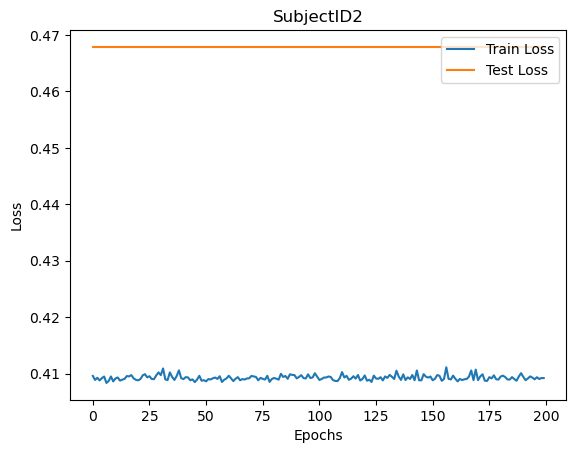

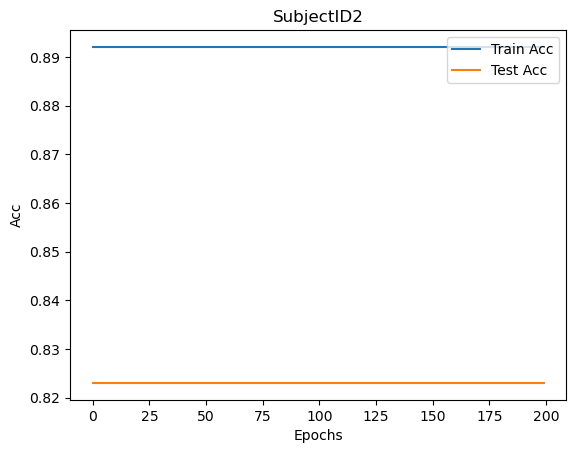


Subject 3
Conv1:Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
pool:MaxPool2d(kernel_size=[2, 1], stride=[2, 1], padding=0, dilation=1, ceil_mode=False)
Conv2:Conv2d(2, 2, kernel_size=(3, 1), stride=(1, 1))
| epoch   0 | 0.0903 s/epoch | train loss 0.4077
| epoch   1 | 0.0875 s/epoch | train loss 0.4072
| epoch   2 | 0.0899 s/epoch | train loss 0.4074
| epoch   3 | 0.0869 s/epoch | train loss 0.4075
| epoch   4 | 0.0861 s/epoch | train loss 0.4071
| epoch   5 | 0.0893 s/epoch | train loss 0.4073
| epoch   6 | 0.0859 s/epoch | train loss 0.4071
| epoch   7 | 0.0853 s/epoch | train loss 0.4086
| epoch   8 | 0.0922 s/epoch | train loss 0.4070
| epoch   9 | 0.0847 s/epoch | train loss 0.4069
| epoch  10 | 0.0884 s/epoch | train loss 0.4073
| epoch  11 | 0.0923 s/epoch | train loss 0.4075
| epoch  12 | 0.0892 s/epoch | train loss 0.4070
| epoch  13 | 0.0881 s/epoch | train loss 0.4076
| epoch  14 | 0.0830 s/epoch | train loss 0.4071
| epoch  15 | 0.0882 s/epoch | train loss 0.4073
| epoch

| epoch 163 | 0.2075 s/epoch | train loss 0.4076
| epoch 164 | 0.2137 s/epoch | train loss 0.4080
| epoch 165 | 0.2092 s/epoch | train loss 0.4075
| epoch 166 | 0.2069 s/epoch | train loss 0.4074
| epoch 167 | 0.2107 s/epoch | train loss 0.4072
| epoch 168 | 0.2098 s/epoch | train loss 0.4077
| epoch 169 | 0.2076 s/epoch | train loss 0.4071
| epoch 170 | 0.4473 s/epoch | train loss 0.4078
| epoch 171 | 0.5437 s/epoch | train loss 0.4069


In [ ]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    #model_Distillation_student = MobileNetV3_Small_KD().to(device)
    model_Distillation_student = Net_Teacher_Student(config).to(device) 
    model_Distillation_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)      

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])


In [ ]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops:',flops_student, 'params', params_student)
print('\nflops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops:',flops_teacher_student, 'params', params_teacher_student)
print('\nflops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))